# Montgomery County Traffic Accidents

## Loading Libraries

In [1]:
#import environment - capstone_git2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use('seaborn-v0_8-colorblind')
import re
from functools import reduce


import geopandas as gpd
from shapely.geometry import Point, Polygon


from haversine import haversine, Unit

import requests
import json
from scipy.stats import chi2_contingency
from scipy import stats

from  prophet import Prophet
from prophet.make_holidays import make_holidays_df
from prophet.plot import add_changepoints_to_plot

import holidays
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)

import warnings
warnings.filterwarnings("ignore")
import googlemaps

from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error 
from sklearn.cluster import KMeans

from IPython.display import Image 



In [2]:
# Loading cleaned crash data provided by the client
crashes = pd.read_excel("Crashes_locations_cleaned.xlsx") 

# Loading additional data sets 
milepoints= pd.read_csv("MDOT_SHA_Mile_Points_(100th).csv") #loading  mile poins data downloaded from state's website
boundaries= requests.get('https://services.arcgis.com/njFNhDsUCentVYJW/arcgis/rest/services/MDOT_SHA_County_Boundaries/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json').json()
url = 'https://gis.mwcog.org/wa/rest/services/TPB/EEA_RTDC/MapServer/1/query?outFields=*&where=1%3D1&f=geojson'
EEA = requests.get(url).json()

pd.set_option('display.max_columns', 100) 

## Investigating Crash Data

In [3]:
# Checking out the shape of the crash data
print(crashes.shape)

# Checking out the top five columns of the crash data
crashes.head() 

(95716, 65)


ReportNumber LocalCaseNumber         ACRSReportType  \
0  MCP11520005        15000008  Property Damage Crash   
1  MCP2686000D        15000017  Property Damage Crash   
2  MCP2783000G        15000025           Injury Crash   
3  MCP2674000D        15000016  Property Damage Crash   
4  MCP23000002        15000197  Property Damage Crash   

                  AgencyName  AtFault                CollisionType  \
0  Montgomery County Police    DRIVER            SAME DIR REAR END   
1  Montgomery County Police    DRIVER            SAME DIR REAR END   
2  Montgomery County Police    DRIVER                      HEAD ON   
3  Montgomery County Police    DRIVER  OPPOSITE DIR BOTH LEFT TURN   
4  Montgomery County Police   UNKNOWN               SINGLE VEHICLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 00:30:00              MOTORIST                  MOTORIST   
1 2015-01-01 01:10:00              MOTORIST                  MOTORIST   
2 2015-01-01 01:14:00              MOTORIST                  MOTORIST   
3 2015-01-01 01:26:00              MOTORIST                  MOTORIST   
4 2015-01-01 02:00:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         0   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             N               NaN         Y  OTHER VEHICLE            NaN   
1             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             E               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
3             W               NaN         N  OTHER VEHICLE            NaN   
4             N               NaN         N          OTHER            NaN   

  ReportCountyLocation NonTraffic OffRoadDescription     IntegerchangeArea  \
0           Montgomery         NO                NaN  INTERSECTION RELATED   
1           Montgomery         NO                NaN     ON RAMP EXIT AREA   
2           Montgomery         NO                NaN                   NaN   
3           Montgomery         NO                NaN          INTERSECTION   
4           Montgomery         NO                NaN                   NaN   

   InterchangeIdentification       IntersectionType              Junction  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION RELATED   
1                        NaN         T-INTERSECTION   INTERCHANGE RELATED   
2                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
3                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
4                        NaN                    NaN

In [4]:
crashes.tail()

ReportNumber LocalCaseNumber         ACRSReportType  \
95711   DD5649003K       230074413           Injury Crash   
95712  MCP2302000G       230074415  Property Damage Crash   
95713   EJ78710072       230074429  Property Damage Crash   
95714  MCP3300002L       230074431  Property Damage Crash   
95715  MCP15540064       230074436  Property Damage Crash   

                      AgencyName AtFault            CollisionType  \
95711  Rockville Police Departme  DRIVER                    OTHER   
95712  Montgomery County Police   DRIVER  STRAIGHT MOVEMENT ANGLE   
95713  Gaithersburg Police Depar  DRIVER        SAME DIR REAR END   
95714  Montgomery County Police   DRIVER        HEAD ON LEFT TURN   
95715  Montgomery County Police   DRIVER           SINGLE VEHICLE   

            CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
95711 2023-12-31 17:25:00            PEDESTRIAN                PEDESTRIAN   
95712 2023-12-31 17:26:00              MOTORIST                  MOTORIST   
95713 2023-12-31 21:19:00              MOTORIST                  MOTORIST   
95714 2023-12-31 22:00:00              MOTORIST                  MOTORIST   
95715 2023-12-31 22:15:00              MOTORIST                  MOTORIST   

       CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  \
95711                     4   True        False          False   
95712                     1  False        False          False   
95713                     1  False        False          False   
95714                     1  False        False          False   
95715                     1  False        False          False   

       BIKE_INVOLVED_KSI  BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  \
95711              False                    0          True              True   
95712              False                    0         False             False   
95713              False                    0         False             False   
95714              False                    0         False             False   
95715              False                    0         False             False   

       PED_HIGHEST_INJURY  MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  \
95711                   4                        1                      1   
95712                   0                        1                      1   
95713                   0                        1                      1   
95714                   0                        1                      1   
95715                   0                        1                      1   

       PASSENGER_HIGHEST_INJURY LaneDirection FixedObjectStruck HitAndRun  \
95711                         0             E               NaN         N   
95712                         0             E               NaN         N   
95713                         0             W               NaN         N   
95714                         1             S               NaN         N   
95715                         1             S             DITCH         N   

       HarmfulEvent1 HarmfulEvent2 ReportCountyLocation NonTraffic  \
95711     PEDESTRIAN           NaN           Montgomery         NO   
95712  OTHER VEHICLE           NaN           Montgomery         NO   
95713  OTHER VEHICLE           NaN           Montgomery         NO   
95714  OTHER VEHICLE           NaN           Montgomery         NO   
95715       OFF ROAD  FIXED OBJECT           Montgomery         NO   

      OffRoadDescription     IntegerchangeArea  InterchangeIdentification  \
95711                NaN          INTERSECTION                        NaN   
95712                NaN          INTERSECTION                        NaN   
95713                NaN  INTERSECTION RELATED                        NaN   
95714                NaN                   NaN                        NaN   
95715                NaN                   NaN                        NaN   

            IntersectionType              Junction  LaneNumber    P

In [5]:
# Getting more information about the crash data
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95716 entries, 0 to 95715
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ReportNumber               95716 non-null  object        
 1   LocalCaseNumber            95716 non-null  object        
 2   ACRSReportType             95716 non-null  object        
 3   AgencyName                 95716 non-null  object        
 4   AtFault                    95716 non-null  object        
 5   CollisionType              95218 non-null  object        
 6   CrashDateTime              95716 non-null  datetime64[ns]
 7   NON_MOTORIST_INVOLVED      95716 non-null  object        
 8   NON_MOTORIST_INVOLVED_KSI  95716 non-null  object        
 9   CRASH_HIGHEST_INJURY       95716 non-null  int64         
 10  KSI                        95716 non-null  bool          
 11  FATAL_CRASH                95716 non-null  bool          
 12  BIKE

In [6]:
df=crashes.copy()

In [7]:
# Checking for duplicated values
df.duplicated().sum()

0

In [8]:
# Checking for the number of unique values of each variable
df.nunique(axis=0)

ReportNumber        95716
LocalCaseNumber     95615
ACRSReportType          3
AgencyName             10
AtFault                13
                    ...  
RoadGrade               8
Ramp                    0
SurfaceCondition       11
TrafficControl         11
Weather                12
Length: 65, dtype: int64

In [9]:
# Selecting only traffic accidents
df=df[df.NonTraffic == 'NO']

In [10]:
# Removing trailing spaces in the road names
df['ROAD_NAME']=df['ROAD_NAME'].str.strip()

In [11]:
# Creating a dictionary to standardize road name abbreviations
replacement = {r'(?:^|\W)AVENUE(?:$|\W\Z)':' AVE ', 
            r'(?:^|\W)STREET(?:$|\W\Z)':' ST ', 
            r'(?:^|\W)CT.(?:$|\W\Z)':' CT ',
               r'(?:^|\W)COURT(?:$|\W\Z)':'CT ',
               r'(?:^|\W)CIRCLE(?:$|\W\Z)':' CIR ',
               r'(?:^|\W)ROAD(?:$|\W\Z)':' RD ',
               r'(?:^|\W)DRIVE(?:$|\W\Z)': ' DR ',
              r'(?:^|\W)DR.(?:$|\W\Z)': ' DR ',
               r'(?:^|\W)PLACE(?:$|\W\Z)':' PL ',
               r'(?:^|\W)PL.(?:$|\W\Z)':' PL ',
               r'(?:^|\W)AVE.(?:$|\W\Z)':' AVE ',
               r'(?:^|\W)AV(?:$|\W\Z)':' AVE ',
               r'(?:^|\W)LANE(?:$|\W\Z)':' LA ',
               r'(?:^|\W)LN(?:$|\W\Z)':' LA ',
               r'(?:^|\W)BOULEVARD(?:$|\W\Z)':' BLVD ',
               r'(?:^|\W)ST.(?:$|\W\Z)':' ST ',
              r'(?:^|\W)BLV(?:$|\W\Z)':' BLVD ',
               r'(?:^|\W)BLVD.(?:$|\W\Z)':' BLVD ',
               r'(?:^|\W)TERRACE(?:$|\W\Z)':' TERR ',
               r'(?:^|\W)TER(?:$|\W\Z)':' TERR ',
              r'(?:^|\W)PARKWY(?:$|\W\Z)':' PKWY ',
              r'(?:^|\W)PARKWAY(?:$|\W\Z)':' PKWY ',
               r'(?:^|\W)PWK(?:$|\W\Z)':' PKWY ',
               r'(?:^|\W)PWKY(?:$|\W\Z)':' PKWY '}

# Applying the appreviations to road names
df['ROAD_NAME_CLEAN']=df['ROAD_NAME'].replace(replacement, regex=True)

In [12]:
# Getting value counts for the milepointsdisunits
df['MilePointDistUnits'].value_counts()

MilePointDistUnits
FEET       77733
MILES       5241
UNKNOWN      425
Name: count, dtype: int64

In [13]:
# Converting the mileopoint distances from feet to miles
feet_to_miles= 0.0001893939
df['milepointdistanceinmiles'] = df['MilePointDistance']
df.loc[((df['MilePointDistUnits']=='FEET'), 'milepointdistanceinmiles')]= df['MilePointDistance'] * feet_to_miles
df.loc[((df['MilePointDistUnits']=='UNKNOWN'), 'milepointdistanceinmiles')]= df['MilePointDistance'] 

In [14]:
# Calculating adjusted milepoint based on distance of accident from milepoint
# If less than 0.01 miles or more than 2 miles, then leave at milepoint
# Ignore 0.0 milepoints that lack a logmile direction
# If adjusted milepoint is negative, leave at original milepoint
df['milespointadjusted']= df['MILEPOINT']
df.loc[(df['LOGMILE_DIR'].isna()) & (df['MILEPOINT']==0), 'milespointadjusted']= df['MILEPOINT']
df.loc[(df['LOGMILE_DIR'] != df['MilePointDirection']) & ((df['milepointdistanceinmiles']>.01) & (df['milepointdistanceinmiles']<2)), 'milespointadjusted']= df['MILEPOINT'] - df['milepointdistanceinmiles']
df.loc[(df['LOGMILE_DIR']== df['MilePointDirection']) & ((df['milepointdistanceinmiles']>.01) & (df['milepointdistanceinmiles']<2)), 'milespointadjusted']= df['MILEPOINT'] + df['milepointdistanceinmiles']
df.loc[(df['milespointadjusted'] < 0), 'milespointadjusted'] = df['MILEPOINT']

In [15]:
df['milespointadjusted'].describe()

count    83389.000000
mean         3.938095
std          5.381512
min          0.000000
25%          0.440000
50%          1.868939
75%          5.071061
max        300.151515
Name: milespointadjusted, dtype: float64

In [16]:
# Getting information about the milepoints data set
milepoints.shape

(593747, 37)

In [17]:
milepoints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593747 entries, 0 to 593746
Data columns (total 37 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   X                   593747 non-null  float64
 1   Y                   593747 non-null  float64
 2   OBJECTID            593747 non-null  int64  
 3   ID_MP               593747 non-null  float64
 4   COUNTY              593747 non-null  int64  
 5   ROAD_NAME           484934 non-null  object 
 6   ID_PREFIX           593747 non-null  object 
 7   ID_RTE_NO           593747 non-null  int64  
 8   MP_SUFFIX           4352 non-null    object 
 9   MP_DIRECTION        528061 non-null  object 
 10  CAL_DIRECTION       528061 non-null  object 
 11  CARDINALITY         593747 non-null  int64  
 12  MAIN_LINE           528061 non-null  float64
 13  EXIT_NUMBER         7620 non-null    object 
 14  RAMP_NUMBER         7620 non-null    float64
 15  ASSOC_ID_PREFIX     7620 non-null 

In [18]:
hundredth=milepoints.copy()

In [19]:
# Stripping trailling spaces in the road names
hundredth['ROAD_NAME']=hundredth['ROAD_NAME'].str.strip()

In [20]:
hundredth['ID_MP'] = hundredth['ID_MP'].astype('float64')

In [21]:
hundredth.head()

X          Y  OBJECTID  ID_MP  COUNTY  ROAD_NAME ID_PREFIX  \
0 -77.232780  39.311731   6874821   1.90      15  MOXLEY RD        CO   
1 -77.232780  39.311731   6874822   1.90      15  MOXLEY RD        CO   
2 -77.232947  39.311670   6874823   1.91      15  MOXLEY RD        CO   
3 -77.233117  39.311614   6874824   1.92      15  MOXLEY RD        CO   
4 -77.233288  39.311559   6874825   1.93      15  MOXLEY RD        CO   

   ID_RTE_NO MP_SUFFIX MP_DIRECTION CAL_DIRECTION  CARDINALITY  MAIN_LINE  \
0          1       NaN            S             S            1        1.0   
1          1       NaN            S             S            1        1.0   
2          1       NaN            S             S            1        1.0   
3          1       NaN            S             S            1        1.0   
4          1       NaN            S             S            1        1.0   

  EXIT_NUMBER  RAMP_NUMBER ASSOC_ID_PREFIX              ROUTE_ID  MUN_SORT  \
0         NaN          NaN             NaN  15000CO00001--1-----         0   
1         NaN          NaN             NaN  15000CO00001--1-----         0   
2         NaN          NaN             NaN  15000CO00001--1-----         0   
3         NaN          NaN             NaN  15000CO00001--1-----         0   
4         NaN          NaN             NaN  15000CO00001--1-----         0   

   IS_INTERSECTION       X_COORD        Y_COORD  LONGITUDE   LATITUDE  \
0                0  1.246469e+06  599206.055448 -77.232780  39.311731   
1                0  1.246469e+06  599206.055448 -77.232780  39.311731   
2                0  1.246421e+06  599184.023012 -77.232947  39.311670   
3                0  1.246373e+06  599163.672331 -77.233117  39.311614   
4                0  1.246324e+06  599143.784576 -77.233288  39.311559   

   GLOBAL_SEGMENT_ID  SUB_ROUTE_ID  GLOBAL_ROUTE_ID  STATE_MP  STMP_SEQ  \
0                NaN           NaN              NaN        -1        -1   
1                NaN           NaN              NaN        -1        -1   
2                NaN           NaN              NaN        -1        -1   
3                NaN           NaN              NaN        -1        -1   
4                NaN           NaN              NaN        -1        -1   

  AT_ROUTE_ROAD_NAME AT_ROUTE_ID AGOL_POPUP                           ROUTEID  \
0                NaN         NaN       CO-1  15000CO00001  01SS**************   
1                NaN         NaN       CO-1  15000CO00001  01SS**************   
2                NaN         NaN       CO-1  15000CO00001  01SS**************   
3                NaN         NaN       CO-1  15000CO00001  01SS**************   
4                NaN         NaN       CO-1  15000CO00001  01SS**************   

   DISTRICT  MAINT_SHOP MAINT_SHOP_DESC  GOVT_CONTROL      GOVT_CONTROL_DESC  
0         3         0.0             NaN           2.0  County Highway Agency  
1         3         0.0             NaN           2.0  County Highway Agency  
2         3         0.0             NaN           2.0  County Highway Agency  
3         3         0.0             NaN           2.0  County Highway Agency  
4         3         0.0             NaN           2.0  County Highway Agency

In [22]:
hundredth.tail()

X          Y  OBJECTID  ID_MP  COUNTY ROAD_NAME ID_PREFIX  \
593742 -77.197837  39.161957   7468611   0.32      15       NaN        BK   
593743 -77.201127  39.162846   7468612   0.53      15       NaN        BK   
593744 -77.053372  39.148121   7468613   0.27      15       NaN        BK   
593745 -77.050267  39.146522   7468614   0.47      15       NaN        BK   
593746 -77.056759  39.165556   7468615   0.14      15       NaN        BK   

        ID_RTE_NO MP_SUFFIX MP_DIRECTION CAL_DIRECTION  CARDINALITY  \
593742        140       NaN          NaN           NaN            1   
593743        140       NaN          NaN           NaN            1   
593744        156       NaN          NaN           NaN            1   
593745        156       NaN          NaN           NaN            1   
593746        176       NaN          NaN           NaN            1   

        MAIN_LINE EXIT_NUMBER  RAMP_NUMBER ASSOC_ID_PREFIX  \
593742        NaN         NaN          NaN             NaN   
593743        NaN         NaN          NaN             NaN   
593744        NaN         NaN          NaN             NaN   
593745        NaN         NaN          NaN             NaN   
593746        NaN         NaN          NaN             NaN   

                    ROUTE_ID  MUN_SORT  IS_INTERSECTION       X_COORD  \
593742  15000BK00140--1-----         0                0  1.256237e+06   
593743  15000BK00140--1-----         0                0  1.255305e+06   
593744  15000BK00156--1-----         0                0  1.297197e+06   
593745  15000BK00156--1-----         0                0  1.298077e+06   
593746  15000BK00176--1-----         0                0  1.296240e+06   

              Y_COORD  LONGITUDE   LATITUDE  GLOBAL_SEGMENT_ID  SUB_ROUTE_ID  \
593742  544631.088811 -77.197837  39.161957                NaN           NaN   
593743  544957.165587 -77.201127  39.162846                NaN           NaN   
593744  539535.418556 -77.053372  39.148121                NaN           NaN   
593745  538952.741900 -77.050267  39.146522                NaN           NaN   
593746  545886.466550 -77.056759  39.165556                NaN           NaN   

        GLOBAL_ROUTE_ID  STATE_MP  STMP_SEQ AT_ROUTE_ROAD_NAME AT_ROUTE_ID  \
593742              NaN        -1        -1                NaN         NaN   
593743              NaN        -1        -1                NaN         NaN   
593744              NaN        -1        -1                NaN         NaN   
593745              NaN        -1        -1                NaN         NaN   
593746              NaN        -1        -1                NaN         NaN   

       AGOL_POPUP ROUTEID  DISTRICT  MAINT_SHOP MAINT_SHOP_DESC  GOVT_CONTROL  \
593742     BK-140     NaN         3         NaN             NaN           NaN   
593743     BK-140     NaN         3         NaN             NaN           NaN   
593744     BK-156     NaN         3         NaN             NaN           NaN   
593745     BK-156     NaN         3         NaN             NaN           NaN   
593746     BK-176     NaN         3         NaN             NaN           NaN   

       GOVT_CONTROL_DESC  
593742               NaN  
593743               NaN  
593744               NaN  
593745               NaN  
593746               NaN

In [23]:
# Checking for any duplicated entries
hundredth.OBJECTID.duplicated().sum()

0

In [24]:
# Replacing the county number with the county name
hundredth['COUNTY'] = hundredth['COUNTY'].replace(to_replace=15, value='Montgomery')

In [25]:
# Getting the number of municipal area codes in the crash data set
df['MUNICIPAL_AREA_CODE'].value_counts()

MUNICIPAL_AREA_CODE
ROCKVILLE              6420
GAITHERSBURG           5801
TAKOMA PARK            1383
KENSINGTON              368
MONTGOMERY VILLAGE      159
CHEVY CHASE VILLAGE      99
POOLESVILLE              83
WASHINGTON GROVE         81
CHEVY CHASE VIEW         74
LAYTONSVILLE             59
CHEVY CHASE #4           58
FRIENDSHIP HEIGHTS       33
GARRETT PARK             33
CHEVY CHASE #3           30
SOMERSET                 18
CHEVY CHASE #5           17
BROOKEVILLE              17
BARNESVILLE              15
NORTH CHEVY CHASE        12
MATINS ADDITION           8
GLEN ECHO                 5
OAKMONT                   3
DRUMMOND                  1
Name: count, dtype: int64

In [26]:
# Creating a dictionary to replace the municipal name with numbers in the milepoint data set
municipal_replacement = {'ROCKVILLE':	'130',
'GAITHERSBURG':	'63',
'TAKOMA PARK':	'143',
'KENSINGTON':	'85',
'MONTGOMERY VILLAGE':	'504',
'CHEVY CHASE VILLAGE':	'33',
'POOLESVILLE':	'120',
'WASHINGTON GROVE':	'153',
'CHEVY CHASE VIEW':	'32',
'LAYTONSVILLE':	'90',
'CHEVY CHASE #4':	'30',
'FRIENDSHIP HEIGHTS':	'58',
'GARRETT PARK':	'66',
'CHEVY CHASE #3':	'29',
'SOMERSET':	'140',
'CHEVY CHASE #5':	'31',
'BROOKEVILLE':	'15',
'BARNESVILLE':	'5',
'NORTH CHEVY CHASE':	'111',
'MATINS ADDITION': '97',
'GLEN ECHO':	'68',
'OAKMONT':	'114',
'DRUMMOND':	'46'
}

# Renaming the municipal area codes and making numeric
df['MUNICIPAL_AREA_CODE']=df['MUNICIPAL_AREA_CODE'].replace(municipal_replacement, regex=True)
df['MUNICIPAL_AREA_CODE']=pd.to_numeric(df['MUNICIPAL_AREA_CODE'], errors='coerce')

## Matching crash location data with milepoint data

In [27]:
### Matching with no modifications to either data set

In [28]:
# Joining crash data with mile points data with no modifications to the mile points data set
matched = df.merge(hundredth, how='left',left_on=['milespointadjusted','LOGMILE_DIR', 'ReportCountyLocation', 'ROUTE_TYPE', 'ROUTE_SUFFIX', 'ROUTE_NUMBER','ROAD_NAME_CLEAN', 'MUNICIPAL_AREA_CODE'],right_on=['ID_MP', 'MP_DIRECTION', 'COUNTY', 'ID_PREFIX', 'MP_SUFFIX', 'ID_RTE_NO','ROAD_NAME', 'MUN_SORT'])
matched.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0  MCP11520005        15000008  Property Damage Crash   
1  MCP2686000D        15000017  Property Damage Crash   
2  MCP2783000G        15000025           Injury Crash   
3  MCP2674000D        15000016  Property Damage Crash   
4  MCP23000002        15000197  Property Damage Crash   

                  AgencyName  AtFault                CollisionType  \
0  Montgomery County Police    DRIVER            SAME DIR REAR END   
1  Montgomery County Police    DRIVER            SAME DIR REAR END   
2  Montgomery County Police    DRIVER                      HEAD ON   
3  Montgomery County Police    DRIVER  OPPOSITE DIR BOTH LEFT TURN   
4  Montgomery County Police   UNKNOWN               SINGLE VEHICLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 00:30:00              MOTORIST                  MOTORIST   
1 2015-01-01 01:10:00              MOTORIST                  MOTORIST   
2 2015-01-01 01:14:00              MOTORIST                  MOTORIST   
3 2015-01-01 01:26:00              MOTORIST                  MOTORIST   
4 2015-01-01 02:00:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         0   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             N               NaN         Y  OTHER VEHICLE            NaN   
1             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             E               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
3             W               NaN         N  OTHER VEHICLE            NaN   
4             N               NaN         N          OTHER            NaN   

  ReportCountyLocation NonTraffic OffRoadDescription     IntegerchangeArea  \
0           Montgomery         NO                NaN  INTERSECTION RELATED   
1           Montgomery         NO                NaN     ON RAMP EXIT AREA   
2           Montgomery         NO                NaN                   NaN   
3           Montgomery         NO                NaN          INTERSECTION   
4           Montgomery         NO                NaN                   NaN   

   InterchangeIdentification       IntersectionType              Junction  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION RELATED   
1                        NaN         T-INTERSECTION   INTERCHANGE RELATED   
2                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
3                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
4                        NaN                    NaN

In [29]:
# Checking for duplicate report numbers
matched.ReportNumber.duplicated().sum()

3

In [30]:
# Deleting rows with duplicated report numbers
matched=matched.drop_duplicates(subset=['ReportNumber'], keep='first')
matched.ReportNumber.duplicated().sum()

0

In [31]:
# Counting number of crashes that remain to be matched
matched.LATITUDE.isnull().sum()

82391

In [32]:
matched.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0  MCP11520005        15000008  Property Damage Crash   
1  MCP2686000D        15000017  Property Damage Crash   
2  MCP2783000G        15000025           Injury Crash   
3  MCP2674000D        15000016  Property Damage Crash   
4  MCP23000002        15000197  Property Damage Crash   

                  AgencyName  AtFault                CollisionType  \
0  Montgomery County Police    DRIVER            SAME DIR REAR END   
1  Montgomery County Police    DRIVER            SAME DIR REAR END   
2  Montgomery County Police    DRIVER                      HEAD ON   
3  Montgomery County Police    DRIVER  OPPOSITE DIR BOTH LEFT TURN   
4  Montgomery County Police   UNKNOWN               SINGLE VEHICLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 00:30:00              MOTORIST                  MOTORIST   
1 2015-01-01 01:10:00              MOTORIST                  MOTORIST   
2 2015-01-01 01:14:00              MOTORIST                  MOTORIST   
3 2015-01-01 01:26:00              MOTORIST                  MOTORIST   
4 2015-01-01 02:00:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         0   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             N               NaN         Y  OTHER VEHICLE            NaN   
1             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             E               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
3             W               NaN         N  OTHER VEHICLE            NaN   
4             N               NaN         N          OTHER            NaN   

  ReportCountyLocation NonTraffic OffRoadDescription     IntegerchangeArea  \
0           Montgomery         NO                NaN  INTERSECTION RELATED   
1           Montgomery         NO                NaN     ON RAMP EXIT AREA   
2           Montgomery         NO                NaN                   NaN   
3           Montgomery         NO                NaN          INTERSECTION   
4           Montgomery         NO                NaN                   NaN   

   InterchangeIdentification       IntersectionType              Junction  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION RELATED   
1                        NaN         T-INTERSECTION   INTERCHANGE RELATED   
2                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
3                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
4                        NaN                    NaN

In [33]:
# Creating a dataframe from the unmatched crashes
unmatched = matched.query('LATITUDE.isnull()').drop(columns=['ID_MP',
 'MP_DIRECTION',
 'COUNTY',
 'ID_PREFIX',
 'MP_SUFFIX',
 'ID_RTE_NO',
 'ROAD_NAME_y',
 'LATITUDE',
 'LONGITUDE', 'MUN_SORT'])

In [34]:
unmatched.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0  MCP11520005        15000008  Property Damage Crash   
1  MCP2686000D        15000017  Property Damage Crash   
2  MCP2783000G        15000025           Injury Crash   
3  MCP2674000D        15000016  Property Damage Crash   
4  MCP23000002        15000197  Property Damage Crash   

                  AgencyName  AtFault                CollisionType  \
0  Montgomery County Police    DRIVER            SAME DIR REAR END   
1  Montgomery County Police    DRIVER            SAME DIR REAR END   
2  Montgomery County Police    DRIVER                      HEAD ON   
3  Montgomery County Police    DRIVER  OPPOSITE DIR BOTH LEFT TURN   
4  Montgomery County Police   UNKNOWN               SINGLE VEHICLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 00:30:00              MOTORIST                  MOTORIST   
1 2015-01-01 01:10:00              MOTORIST                  MOTORIST   
2 2015-01-01 01:14:00              MOTORIST                  MOTORIST   
3 2015-01-01 01:26:00              MOTORIST                  MOTORIST   
4 2015-01-01 02:00:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         0   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             N               NaN         Y  OTHER VEHICLE            NaN   
1             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             E               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
3             W               NaN         N  OTHER VEHICLE            NaN   
4             N               NaN         N          OTHER            NaN   

  ReportCountyLocation NonTraffic OffRoadDescription     IntegerchangeArea  \
0           Montgomery         NO                NaN  INTERSECTION RELATED   
1           Montgomery         NO                NaN     ON RAMP EXIT AREA   
2           Montgomery         NO                NaN                   NaN   
3           Montgomery         NO                NaN          INTERSECTION   
4           Montgomery         NO                NaN                   NaN   

   InterchangeIdentification       IntersectionType              Junction  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION RELATED   
1                        NaN         T-INTERSECTION   INTERCHANGE RELATED   
2                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
3                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
4                        NaN                    NaN

### Matching after rounding milepoints in both datasets to three decimal places

In [35]:
hundredth_copy=milepoints.copy()
hundredth_copy['ID_MP'] = hundredth_copy['ID_MP'].astype('float64')
hundredth_copy['COUNTY'] = hundredth_copy['COUNTY'].replace(to_replace=15, value='Montgomery')

In [36]:
# Rounding milepoints to three decimal places
unmatched['milespointadjusted'] = unmatched['milespointadjusted'].apply(lambda x: '{:.3f}'.format(x)).astype('float64')
hundredth_copy['ID_MP'] = hundredth_copy['ID_MP'].apply(lambda x: '{:.3f}'.format(x)).astype('float64')

# Matching remaining unmatched crashes to milepoints
matched2 = pd.merge(unmatched,hundredth_copy, how='left',left_on=['milespointadjusted','LOGMILE_DIR', 'ReportCountyLocation', 'ROUTE_TYPE', 'ROUTE_SUFFIX', 'ROUTE_NUMBER','ROAD_NAME_CLEAN', 'MUNICIPAL_AREA_CODE'],right_on=['ID_MP', 'MP_DIRECTION', 'COUNTY', 'ID_PREFIX', 'MP_SUFFIX', 'ID_RTE_NO','ROAD_NAME', 'MUN_SORT'])
matched2.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0  MCP11520005        15000008  Property Damage Crash   
1  MCP2686000D        15000017  Property Damage Crash   
2  MCP2783000G        15000025           Injury Crash   
3  MCP2674000D        15000016  Property Damage Crash   
4  MCP23000002        15000197  Property Damage Crash   

                  AgencyName  AtFault                CollisionType  \
0  Montgomery County Police    DRIVER            SAME DIR REAR END   
1  Montgomery County Police    DRIVER            SAME DIR REAR END   
2  Montgomery County Police    DRIVER                      HEAD ON   
3  Montgomery County Police    DRIVER  OPPOSITE DIR BOTH LEFT TURN   
4  Montgomery County Police   UNKNOWN               SINGLE VEHICLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 00:30:00              MOTORIST                  MOTORIST   
1 2015-01-01 01:10:00              MOTORIST                  MOTORIST   
2 2015-01-01 01:14:00              MOTORIST                  MOTORIST   
3 2015-01-01 01:26:00              MOTORIST                  MOTORIST   
4 2015-01-01 02:00:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         0   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             N               NaN         Y  OTHER VEHICLE            NaN   
1             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             E               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
3             W               NaN         N  OTHER VEHICLE            NaN   
4             N               NaN         N          OTHER            NaN   

  ReportCountyLocation NonTraffic OffRoadDescription     IntegerchangeArea  \
0           Montgomery         NO                NaN  INTERSECTION RELATED   
1           Montgomery         NO                NaN     ON RAMP EXIT AREA   
2           Montgomery         NO                NaN                   NaN   
3           Montgomery         NO                NaN          INTERSECTION   
4           Montgomery         NO                NaN                   NaN   

   InterchangeIdentification       IntersectionType              Junction  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION RELATED   
1                        NaN         T-INTERSECTION   INTERCHANGE RELATED   
2                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
3                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
4                        NaN                    NaN

In [37]:
# Checking for duplicate report numbers
matched2.ReportNumber.duplicated().sum()

75

In [38]:
# Deleting rows with duplicated report numbers
matched2=matched2.drop_duplicates(subset=['ReportNumber', 'LocalCaseNumber'], keep='first')
matched2.ReportNumber.duplicated().sum()

0

In [39]:
# Counting number of crashes that remain to be matched
matched2.LATITUDE.isnull().sum()

79154

In [40]:
matched2.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0  MCP11520005        15000008  Property Damage Crash   
1  MCP2686000D        15000017  Property Damage Crash   
2  MCP2783000G        15000025           Injury Crash   
3  MCP2674000D        15000016  Property Damage Crash   
4  MCP23000002        15000197  Property Damage Crash   

                  AgencyName  AtFault                CollisionType  \
0  Montgomery County Police    DRIVER            SAME DIR REAR END   
1  Montgomery County Police    DRIVER            SAME DIR REAR END   
2  Montgomery County Police    DRIVER                      HEAD ON   
3  Montgomery County Police    DRIVER  OPPOSITE DIR BOTH LEFT TURN   
4  Montgomery County Police   UNKNOWN               SINGLE VEHICLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 00:30:00              MOTORIST                  MOTORIST   
1 2015-01-01 01:10:00              MOTORIST                  MOTORIST   
2 2015-01-01 01:14:00              MOTORIST                  MOTORIST   
3 2015-01-01 01:26:00              MOTORIST                  MOTORIST   
4 2015-01-01 02:00:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         0   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             N               NaN         Y  OTHER VEHICLE            NaN   
1             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             E               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
3             W               NaN         N  OTHER VEHICLE            NaN   
4             N               NaN         N          OTHER            NaN   

  ReportCountyLocation NonTraffic OffRoadDescription     IntegerchangeArea  \
0           Montgomery         NO                NaN  INTERSECTION RELATED   
1           Montgomery         NO                NaN     ON RAMP EXIT AREA   
2           Montgomery         NO                NaN                   NaN   
3           Montgomery         NO                NaN          INTERSECTION   
4           Montgomery         NO                NaN                   NaN   

   InterchangeIdentification       IntersectionType              Junction  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION RELATED   
1                        NaN         T-INTERSECTION   INTERCHANGE RELATED   
2                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
3                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
4                        NaN                    NaN

In [41]:
# Removing suffixes from matched column names
matched2 = matched2[matched2.columns[~matched2.columns.str.endswith('_x')]]
matched2 = matched2[matched2.columns[~matched2.columns.str.endswith('_y')]]

In [42]:
matched2.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0  MCP11520005        15000008  Property Damage Crash   
1  MCP2686000D        15000017  Property Damage Crash   
2  MCP2783000G        15000025           Injury Crash   
3  MCP2674000D        15000016  Property Damage Crash   
4  MCP23000002        15000197  Property Damage Crash   

                  AgencyName  AtFault                CollisionType  \
0  Montgomery County Police    DRIVER            SAME DIR REAR END   
1  Montgomery County Police    DRIVER            SAME DIR REAR END   
2  Montgomery County Police    DRIVER                      HEAD ON   
3  Montgomery County Police    DRIVER  OPPOSITE DIR BOTH LEFT TURN   
4  Montgomery County Police   UNKNOWN               SINGLE VEHICLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 00:30:00              MOTORIST                  MOTORIST   
1 2015-01-01 01:10:00              MOTORIST                  MOTORIST   
2 2015-01-01 01:14:00              MOTORIST                  MOTORIST   
3 2015-01-01 01:26:00              MOTORIST                  MOTORIST   
4 2015-01-01 02:00:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         0   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             N               NaN         Y  OTHER VEHICLE            NaN   
1             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             E               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
3             W               NaN         N  OTHER VEHICLE            NaN   
4             N               NaN         N          OTHER            NaN   

  ReportCountyLocation NonTraffic OffRoadDescription     IntegerchangeArea  \
0           Montgomery         NO                NaN  INTERSECTION RELATED   
1           Montgomery         NO                NaN     ON RAMP EXIT AREA   
2           Montgomery         NO                NaN                   NaN   
3           Montgomery         NO                NaN          INTERSECTION   
4           Montgomery         NO                NaN                   NaN   

   InterchangeIdentification       IntersectionType              Junction  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION RELATED   
1                        NaN         T-INTERSECTION   INTERCHANGE RELATED   
2                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
3                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
4                        NaN                    NaN

In [43]:
# Creating a dataframe with any remaining unmatched columns
unmatched2 = matched2.query('LATITUDE.isnull()').drop(columns=['ID_MP',
 'MP_DIRECTION',
 'COUNTY',
 'ID_PREFIX',
 'MP_SUFFIX',
 'ID_RTE_NO',
 'LATITUDE',                                                      
 'LONGITUDE', 'MUN_SORT', 'ROAD_NAME'])

In [44]:
unmatched2.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0  MCP11520005        15000008  Property Damage Crash   
1  MCP2686000D        15000017  Property Damage Crash   
2  MCP2783000G        15000025           Injury Crash   
3  MCP2674000D        15000016  Property Damage Crash   
4  MCP23000002        15000197  Property Damage Crash   

                  AgencyName  AtFault                CollisionType  \
0  Montgomery County Police    DRIVER            SAME DIR REAR END   
1  Montgomery County Police    DRIVER            SAME DIR REAR END   
2  Montgomery County Police    DRIVER                      HEAD ON   
3  Montgomery County Police    DRIVER  OPPOSITE DIR BOTH LEFT TURN   
4  Montgomery County Police   UNKNOWN               SINGLE VEHICLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 00:30:00              MOTORIST                  MOTORIST   
1 2015-01-01 01:10:00              MOTORIST                  MOTORIST   
2 2015-01-01 01:14:00              MOTORIST                  MOTORIST   
3 2015-01-01 01:26:00              MOTORIST                  MOTORIST   
4 2015-01-01 02:00:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         0   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             N               NaN         Y  OTHER VEHICLE            NaN   
1             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             E               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
3             W               NaN         N  OTHER VEHICLE            NaN   
4             N               NaN         N          OTHER            NaN   

  ReportCountyLocation NonTraffic OffRoadDescription     IntegerchangeArea  \
0           Montgomery         NO                NaN  INTERSECTION RELATED   
1           Montgomery         NO                NaN     ON RAMP EXIT AREA   
2           Montgomery         NO                NaN                   NaN   
3           Montgomery         NO                NaN          INTERSECTION   
4           Montgomery         NO                NaN                   NaN   

   InterchangeIdentification       IntersectionType              Junction  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION RELATED   
1                        NaN         T-INTERSECTION   INTERCHANGE RELATED   
2                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
3                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
4                        NaN                    NaN

### Matching remaining unmatched crashes after rounding milepoints in both datasets to two decimal places

In [45]:
# Rounding milepoints
unmatched2['milespointadjusted'] = unmatched2['milespointadjusted'].apply(lambda x: '{:.2f}'.format(x)).astype('float64')
hundredth_copy['ID_MP'] = hundredth_copy['ID_MP'].apply(lambda x: '{:.2f}'.format(x)).astype('float64')

# Matching remaining unmatched crashes
matched3 = pd.merge(unmatched2,hundredth_copy, how='left',left_on=['milespointadjusted','LOGMILE_DIR', 'ReportCountyLocation', 'ROUTE_TYPE', 'ROUTE_SUFFIX', 'ROUTE_NUMBER','ROAD_NAME_CLEAN', 'MUNICIPAL_AREA_CODE'],right_on=['ID_MP', 'MP_DIRECTION', 'COUNTY', 'ID_PREFIX', 'MP_SUFFIX', 'ID_RTE_NO','ROAD_NAME', 'MUN_SORT'])
matched3.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0  MCP11520005        15000008  Property Damage Crash   
1  MCP2686000D        15000017  Property Damage Crash   
2  MCP2783000G        15000025           Injury Crash   
3  MCP2674000D        15000016  Property Damage Crash   
4  MCP23000002        15000197  Property Damage Crash   

                  AgencyName  AtFault                CollisionType  \
0  Montgomery County Police    DRIVER            SAME DIR REAR END   
1  Montgomery County Police    DRIVER            SAME DIR REAR END   
2  Montgomery County Police    DRIVER                      HEAD ON   
3  Montgomery County Police    DRIVER  OPPOSITE DIR BOTH LEFT TURN   
4  Montgomery County Police   UNKNOWN               SINGLE VEHICLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 00:30:00              MOTORIST                  MOTORIST   
1 2015-01-01 01:10:00              MOTORIST                  MOTORIST   
2 2015-01-01 01:14:00              MOTORIST                  MOTORIST   
3 2015-01-01 01:26:00              MOTORIST                  MOTORIST   
4 2015-01-01 02:00:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         0   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             N               NaN         Y  OTHER VEHICLE            NaN   
1             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             E               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
3             W               NaN         N  OTHER VEHICLE            NaN   
4             N               NaN         N          OTHER            NaN   

  ReportCountyLocation NonTraffic OffRoadDescription     IntegerchangeArea  \
0           Montgomery         NO                NaN  INTERSECTION RELATED   
1           Montgomery         NO                NaN     ON RAMP EXIT AREA   
2           Montgomery         NO                NaN                   NaN   
3           Montgomery         NO                NaN          INTERSECTION   
4           Montgomery         NO                NaN                   NaN   

   InterchangeIdentification       IntersectionType              Junction  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION RELATED   
1                        NaN         T-INTERSECTION   INTERCHANGE RELATED   
2                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
3                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
4                        NaN                    NaN

In [46]:
# Checking for duplicate report numbers
matched3.ReportNumber.duplicated().sum()

229

In [47]:
# Deleting rows with duplicated report numbers
matched3=matched3.drop_duplicates(subset=['ReportNumber'], keep='first')
matched3.ReportNumber.duplicated().sum()

0

In [48]:
# Counting number of crashes that remain to be matched
matched3.LATITUDE.isnull().sum()

77875

In [49]:
matched3.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0  MCP11520005        15000008  Property Damage Crash   
1  MCP2686000D        15000017  Property Damage Crash   
2  MCP2783000G        15000025           Injury Crash   
3  MCP2674000D        15000016  Property Damage Crash   
4  MCP23000002        15000197  Property Damage Crash   

                  AgencyName  AtFault                CollisionType  \
0  Montgomery County Police    DRIVER            SAME DIR REAR END   
1  Montgomery County Police    DRIVER            SAME DIR REAR END   
2  Montgomery County Police    DRIVER                      HEAD ON   
3  Montgomery County Police    DRIVER  OPPOSITE DIR BOTH LEFT TURN   
4  Montgomery County Police   UNKNOWN               SINGLE VEHICLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 00:30:00              MOTORIST                  MOTORIST   
1 2015-01-01 01:10:00              MOTORIST                  MOTORIST   
2 2015-01-01 01:14:00              MOTORIST                  MOTORIST   
3 2015-01-01 01:26:00              MOTORIST                  MOTORIST   
4 2015-01-01 02:00:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         0   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             N               NaN         Y  OTHER VEHICLE            NaN   
1             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             E               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
3             W               NaN         N  OTHER VEHICLE            NaN   
4             N               NaN         N          OTHER            NaN   

  ReportCountyLocation NonTraffic OffRoadDescription     IntegerchangeArea  \
0           Montgomery         NO                NaN  INTERSECTION RELATED   
1           Montgomery         NO                NaN     ON RAMP EXIT AREA   
2           Montgomery         NO                NaN                   NaN   
3           Montgomery         NO                NaN          INTERSECTION   
4           Montgomery         NO                NaN                   NaN   

   InterchangeIdentification       IntersectionType              Junction  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION RELATED   
1                        NaN         T-INTERSECTION   INTERCHANGE RELATED   
2                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
3                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
4                        NaN                    NaN

In [50]:
# Removing suffixes from matched column names
matched2 = matched2[matched2.columns[~matched2.columns.str.endswith('_x')]]
matched2 = matched2[matched2.columns[~matched2.columns.str.endswith('_y')]]

In [51]:
# Creating a dataframe with unmatched crashes
unmatched3 = matched3.query('LATITUDE.isnull()').drop(columns=['ID_MP',
 'MP_DIRECTION',
 'COUNTY',
 'ID_PREFIX',
 'MP_SUFFIX',
 'ID_RTE_NO',
 'ROAD_NAME',
 'LATITUDE',
 'LONGITUDE', 'MUN_SORT'])

In [52]:
unmatched3.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0  MCP11520005        15000008  Property Damage Crash   
1  MCP2686000D        15000017  Property Damage Crash   
2  MCP2783000G        15000025           Injury Crash   
3  MCP2674000D        15000016  Property Damage Crash   
4  MCP23000002        15000197  Property Damage Crash   

                  AgencyName  AtFault                CollisionType  \
0  Montgomery County Police    DRIVER            SAME DIR REAR END   
1  Montgomery County Police    DRIVER            SAME DIR REAR END   
2  Montgomery County Police    DRIVER                      HEAD ON   
3  Montgomery County Police    DRIVER  OPPOSITE DIR BOTH LEFT TURN   
4  Montgomery County Police   UNKNOWN               SINGLE VEHICLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 00:30:00              MOTORIST                  MOTORIST   
1 2015-01-01 01:10:00              MOTORIST                  MOTORIST   
2 2015-01-01 01:14:00              MOTORIST                  MOTORIST   
3 2015-01-01 01:26:00              MOTORIST                  MOTORIST   
4 2015-01-01 02:00:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         0   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             N               NaN         Y  OTHER VEHICLE            NaN   
1             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             E               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
3             W               NaN         N  OTHER VEHICLE            NaN   
4             N               NaN         N          OTHER            NaN   

  ReportCountyLocation NonTraffic OffRoadDescription     IntegerchangeArea  \
0           Montgomery         NO                NaN  INTERSECTION RELATED   
1           Montgomery         NO                NaN     ON RAMP EXIT AREA   
2           Montgomery         NO                NaN                   NaN   
3           Montgomery         NO                NaN          INTERSECTION   
4           Montgomery         NO                NaN                   NaN   

   InterchangeIdentification       IntersectionType              Junction  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION RELATED   
1                        NaN         T-INTERSECTION   INTERCHANGE RELATED   
2                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
3                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
4                        NaN                    NaN

There are a high number of null values for MUNICIPAL_AREA_CODE and the ROUTE_SUFFIX so they will not be used in the next round of merging

### Matching crash data set after dropping MUNICIPAL_AREA_CODE and ROUTE_SUFFIX from the keys and with milepoints at three decimal places

In [53]:
hundredth_copy=milepoints.copy()
hundredth_copy['ID_MP'] = hundredth_copy['ID_MP'].astype('float64')
hundredth_copy['COUNTY'] = hundredth_copy['COUNTY'].replace(to_replace=15, value='Montgomery')

In [54]:
# Matching remaining unmatched crashes
unmatched3['milespointadjusted'] = unmatched3['milespointadjusted'].apply(lambda x: '{:.3f}'.format(x)).astype('float64')
hundredth_copy['ID_MP'] = hundredth_copy['ID_MP'].apply(lambda x: '{:.3f}'.format(x)).astype('float64')
matched4 = pd.merge(unmatched3,hundredth_copy, how='left',left_on=['milespointadjusted','LOGMILE_DIR', 'ReportCountyLocation', 'ROUTE_TYPE', 'ROUTE_NUMBER','ROAD_NAME_CLEAN' ],right_on=['ID_MP', 'MP_DIRECTION', 'COUNTY', 'ID_PREFIX', 'ID_RTE_NO','ROAD_NAME'])
matched4.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0  MCP11520005        15000008  Property Damage Crash   
1  MCP2686000D        15000017  Property Damage Crash   
2  MCP2783000G        15000025           Injury Crash   
3  MCP2674000D        15000016  Property Damage Crash   
4  MCP23000002        15000197  Property Damage Crash   

                  AgencyName  AtFault                CollisionType  \
0  Montgomery County Police    DRIVER            SAME DIR REAR END   
1  Montgomery County Police    DRIVER            SAME DIR REAR END   
2  Montgomery County Police    DRIVER                      HEAD ON   
3  Montgomery County Police    DRIVER  OPPOSITE DIR BOTH LEFT TURN   
4  Montgomery County Police   UNKNOWN               SINGLE VEHICLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 00:30:00              MOTORIST                  MOTORIST   
1 2015-01-01 01:10:00              MOTORIST                  MOTORIST   
2 2015-01-01 01:14:00              MOTORIST                  MOTORIST   
3 2015-01-01 01:26:00              MOTORIST                  MOTORIST   
4 2015-01-01 02:00:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         0   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             N               NaN         Y  OTHER VEHICLE            NaN   
1             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             E               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
3             W               NaN         N  OTHER VEHICLE            NaN   
4             N               NaN         N          OTHER            NaN   

  ReportCountyLocation NonTraffic OffRoadDescription     IntegerchangeArea  \
0           Montgomery         NO                NaN  INTERSECTION RELATED   
1           Montgomery         NO                NaN     ON RAMP EXIT AREA   
2           Montgomery         NO                NaN                   NaN   
3           Montgomery         NO                NaN          INTERSECTION   
4           Montgomery         NO                NaN                   NaN   

   InterchangeIdentification       IntersectionType              Junction  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION RELATED   
1                        NaN         T-INTERSECTION   INTERCHANGE RELATED   
2                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
3                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
4                        NaN                    NaN

In [55]:
# Checking for duplicate report numbers
matched4.ReportNumber.duplicated().sum()


3370

In [56]:
# Deleting rows with duplicated report numbers
matched4=matched4.drop_duplicates(subset=['ReportNumber', 'LocalCaseNumber'], keep='first')
matched4.ReportNumber.duplicated().sum()

0

In [57]:
# Counting number of crashes that remain to be matched
matched4.LATITUDE.isnull().sum()

4143

In [58]:
matched4.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0  MCP11520005        15000008  Property Damage Crash   
1  MCP2686000D        15000017  Property Damage Crash   
2  MCP2783000G        15000025           Injury Crash   
3  MCP2674000D        15000016  Property Damage Crash   
4  MCP23000002        15000197  Property Damage Crash   

                  AgencyName  AtFault                CollisionType  \
0  Montgomery County Police    DRIVER            SAME DIR REAR END   
1  Montgomery County Police    DRIVER            SAME DIR REAR END   
2  Montgomery County Police    DRIVER                      HEAD ON   
3  Montgomery County Police    DRIVER  OPPOSITE DIR BOTH LEFT TURN   
4  Montgomery County Police   UNKNOWN               SINGLE VEHICLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 00:30:00              MOTORIST                  MOTORIST   
1 2015-01-01 01:10:00              MOTORIST                  MOTORIST   
2 2015-01-01 01:14:00              MOTORIST                  MOTORIST   
3 2015-01-01 01:26:00              MOTORIST                  MOTORIST   
4 2015-01-01 02:00:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         0   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             N               NaN         Y  OTHER VEHICLE            NaN   
1             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             E               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
3             W               NaN         N  OTHER VEHICLE            NaN   
4             N               NaN         N          OTHER            NaN   

  ReportCountyLocation NonTraffic OffRoadDescription     IntegerchangeArea  \
0           Montgomery         NO                NaN  INTERSECTION RELATED   
1           Montgomery         NO                NaN     ON RAMP EXIT AREA   
2           Montgomery         NO                NaN                   NaN   
3           Montgomery         NO                NaN          INTERSECTION   
4           Montgomery         NO                NaN                   NaN   

   InterchangeIdentification       IntersectionType              Junction  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION RELATED   
1                        NaN         T-INTERSECTION   INTERCHANGE RELATED   
2                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
3                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
4                        NaN                    NaN

In [59]:
# Dropping columns suffixes
matched4 = matched4[matched4.columns[~matched4.columns.str.endswith('_x')]]
matched4 = matched4[matched4.columns[~matched4.columns.str.endswith('_y')]]

In [60]:
# Creating dataframe with remaining unmatched columns
unmatched4 = matched4.query('LATITUDE.isnull()').drop(columns=['ID_MP',
 'MP_DIRECTION',
 'COUNTY',
 'ID_PREFIX',
 'MP_SUFFIX',
 'ID_RTE_NO',
 'ROAD_NAME',
 'LATITUDE',
 'LONGITUDE'])

In [61]:
unmatched4.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
7    EJ78480009        15000107  Property Damage Crash   
21   EJ7852000P        15000279  Property Damage Crash   
39  MCP2776000N        15000368           Injury Crash   
79  MCP20590015        15000578  Property Damage Crash   
91  MCP1220001T        15000683  Property Damage Crash   

                   AgencyName AtFault             CollisionType  \
7   Gaithersburg Police Depar  DRIVER                     OTHER   
21  Gaithersburg Police Depar  DRIVER         SAME DIR REAR END   
39  Montgomery County Police   DRIVER   STRAIGHT MOVEMENT ANGLE   
79  Montgomery County Police   DRIVER            SINGLE VEHICLE   
91  Montgomery County Police   DRIVER  SAME DIRECTION SIDESWIPE   

         CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
7  2015-01-01 04:00:00              MOTORIST                  MOTORIST   
21 2015-01-01 17:00:00              MOTORIST                  MOTORIST   
39 2015-01-03 01:05:00              MOTORIST                  MOTORIST   
79 2015-01-04 14:14:00              MOTORIST                  MOTORIST   
91 2015-01-05 09:54:00              MOTORIST                  MOTORIST   

    CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  \
7                      1  False        False          False   
21                     1  False        False          False   
39                     3  False        False          False   
79                     1  False        False          False   
91                     1  False        False          False   

    BIKE_INVOLVED_KSI  BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  \
7               False                    0         False             False   
21              False                    0         False             False   
39              False                    0         False             False   
79              False                    0         False             False   
91              False                    0         False             False   

    PED_HIGHEST_INJURY  MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  \
7                    0                        1                      1   
21                   0                        1                      1   
39                   0                        3                      3   
79                   0                        1                      1   
91                   0                        1                      1   

    PASSENGER_HIGHEST_INJURY LaneDirection   FixedObjectStruck HitAndRun  \
7                          0             N                 NaN         Y   
21                         0             N                 NaN         Y   
39                         1             N                 NaN         N   
79                         0             E  LIGHT SUPPORT POLE         N   
91                         0             E                 NaN         N   

     HarmfulEvent1   HarmfulEvent2 ReportCountyLocation NonTraffic  \
7   PARKED VEHICLE  PARKED VEHICLE           Montgomery         NO   
21  PARKED VEHICLE             NaN           Montgomery         NO   
39   OTHER VEHICLE             NaN           Montgomery         NO   
79    FIXED OBJECT             NaN           Montgomery         NO   
91   OTHER VEHICLE             NaN           Montgomery         NO   

   OffRoadDescription IntegerchangeArea  InterchangeIdentification  \
7                 NaN               NaN                        NaN   
21                NaN               NaN                        NaN   
39                NaN      INTERSECTION                        NaN   
79                NaN               NaN                        NaN   
91                NaN               NaN                        NaN   

         IntersectionType          Junction  LaneNumber    POL_LAT    POL_LON  \
7                     NaN               NaN         NaN  39.140313 -77.201803   
21                    NaN               NaN         

#### Dropping milepoints to two decimal places

In [62]:
unmatched4['milespointadjusted'] = unmatched4['milespointadjusted'].apply(lambda x: '{:.2f}'.format(x)).astype('float64')
hundredth_copy['ID_MP'] = hundredth_copy['ID_MP'].apply(lambda x: '{:.2f}'.format(x)).astype('float64')
matched5 = pd.merge(unmatched4,hundredth_copy, how='left',left_on=['milespointadjusted','LOGMILE_DIR', 'ReportCountyLocation', 'ROUTE_TYPE', 'ROUTE_NUMBER','ROAD_NAME_CLEAN' ],right_on=['ID_MP', 'MP_DIRECTION', 'COUNTY', 'ID_PREFIX', 'ID_RTE_NO','ROAD_NAME'])
matched5.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   EJ78480009        15000107  Property Damage Crash   
1   EJ7852000P        15000279  Property Damage Crash   
2  MCP2776000N        15000368           Injury Crash   
3  MCP20590015        15000578  Property Damage Crash   
4  MCP1220001T        15000683  Property Damage Crash   

                  AgencyName AtFault             CollisionType  \
0  Gaithersburg Police Depar  DRIVER                     OTHER   
1  Gaithersburg Police Depar  DRIVER         SAME DIR REAR END   
2  Montgomery County Police   DRIVER   STRAIGHT MOVEMENT ANGLE   
3  Montgomery County Police   DRIVER            SINGLE VEHICLE   
4  Montgomery County Police   DRIVER  SAME DIRECTION SIDESWIPE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 04:00:00              MOTORIST                  MOTORIST   
1 2015-01-01 17:00:00              MOTORIST                  MOTORIST   
2 2015-01-03 01:05:00              MOTORIST                  MOTORIST   
3 2015-01-04 14:14:00              MOTORIST                  MOTORIST   
4 2015-01-05 09:54:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         1   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection   FixedObjectStruck HitAndRun   HarmfulEvent1   HarmfulEvent2  \
0             N                 NaN         Y  PARKED VEHICLE  PARKED VEHICLE   
1             N                 NaN         Y  PARKED VEHICLE             NaN   
2             N                 NaN         N   OTHER VEHICLE             NaN   
3             E  LIGHT SUPPORT POLE         N    FIXED OBJECT             NaN   
4             E                 NaN         N   OTHER VEHICLE             NaN   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN      INTERSECTION   
3           Montgomery         NO                NaN               NaN   
4           Montgomery         NO                NaN               NaN   

   InterchangeIdentification       IntersectionType          Junction  \
0                        NaN                    NaN               NaN   
1                        NaN                    NaN               NaN   
2                        NaN  FOUR-WAY INTERSECTION      INTERSECTION   
3                        NaN                    NaN  NON INTERSECTION   
4                        NaN                    NaN  NON INTERSECTION   

   LaneNumber    POL_

In [63]:
# Checking for duplicate report numbers
matched5.ReportNumber.duplicated().sum()

0

In [64]:
# Deleting rows with duplicated report numbers
matched5.drop_duplicates(subset=['ReportNumber'], keep="first")
matched5.ReportNumber.duplicated().sum()

0

In [65]:
# Counting number of crashes that remain to be matched
matched5.LATITUDE.isnull().sum()

3782

In [66]:
matched5.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   EJ78480009        15000107  Property Damage Crash   
1   EJ7852000P        15000279  Property Damage Crash   
2  MCP2776000N        15000368           Injury Crash   
3  MCP20590015        15000578  Property Damage Crash   
4  MCP1220001T        15000683  Property Damage Crash   

                  AgencyName AtFault             CollisionType  \
0  Gaithersburg Police Depar  DRIVER                     OTHER   
1  Gaithersburg Police Depar  DRIVER         SAME DIR REAR END   
2  Montgomery County Police   DRIVER   STRAIGHT MOVEMENT ANGLE   
3  Montgomery County Police   DRIVER            SINGLE VEHICLE   
4  Montgomery County Police   DRIVER  SAME DIRECTION SIDESWIPE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 04:00:00              MOTORIST                  MOTORIST   
1 2015-01-01 17:00:00              MOTORIST                  MOTORIST   
2 2015-01-03 01:05:00              MOTORIST                  MOTORIST   
3 2015-01-04 14:14:00              MOTORIST                  MOTORIST   
4 2015-01-05 09:54:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         1   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection   FixedObjectStruck HitAndRun   HarmfulEvent1   HarmfulEvent2  \
0             N                 NaN         Y  PARKED VEHICLE  PARKED VEHICLE   
1             N                 NaN         Y  PARKED VEHICLE             NaN   
2             N                 NaN         N   OTHER VEHICLE             NaN   
3             E  LIGHT SUPPORT POLE         N    FIXED OBJECT             NaN   
4             E                 NaN         N   OTHER VEHICLE             NaN   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN      INTERSECTION   
3           Montgomery         NO                NaN               NaN   
4           Montgomery         NO                NaN               NaN   

   InterchangeIdentification       IntersectionType          Junction  \
0                        NaN                    NaN               NaN   
1                        NaN                    NaN               NaN   
2                        NaN  FOUR-WAY INTERSECTION      INTERSECTION   
3                        NaN                    NaN  NON INTERSECTION   
4                        NaN                    NaN  NON INTERSECTION   

   LaneNumber    POL_

In [67]:
#Dropping columns suffixes
matched5 = matched5[matched5.columns[~matched5.columns.str.endswith('_x')]]
matched5 = matched5[matched5.columns[~matched5.columns.str.endswith('_y')]]

In [68]:
# Creating dataframe with remaining unmatched crashes
unmatched5 = matched5.query('LATITUDE.isnull()').drop(columns=['ID_MP',
 'MP_DIRECTION',
 'COUNTY',
 'ID_PREFIX',
 'MP_SUFFIX',
 'ID_RTE_NO',
 'ROAD_NAME',
 'LATITUDE',
 'LONGITUDE'])

In [69]:
unmatched5.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   EJ78480009        15000107  Property Damage Crash   
1   EJ7852000P        15000279  Property Damage Crash   
2  MCP2776000N        15000368           Injury Crash   
3  MCP20590015        15000578  Property Damage Crash   
4  MCP1220001T        15000683  Property Damage Crash   

                  AgencyName AtFault             CollisionType  \
0  Gaithersburg Police Depar  DRIVER                     OTHER   
1  Gaithersburg Police Depar  DRIVER         SAME DIR REAR END   
2  Montgomery County Police   DRIVER   STRAIGHT MOVEMENT ANGLE   
3  Montgomery County Police   DRIVER            SINGLE VEHICLE   
4  Montgomery County Police   DRIVER  SAME DIRECTION SIDESWIPE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 04:00:00              MOTORIST                  MOTORIST   
1 2015-01-01 17:00:00              MOTORIST                  MOTORIST   
2 2015-01-03 01:05:00              MOTORIST                  MOTORIST   
3 2015-01-04 14:14:00              MOTORIST                  MOTORIST   
4 2015-01-05 09:54:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         1   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection   FixedObjectStruck HitAndRun   HarmfulEvent1   HarmfulEvent2  \
0             N                 NaN         Y  PARKED VEHICLE  PARKED VEHICLE   
1             N                 NaN         Y  PARKED VEHICLE             NaN   
2             N                 NaN         N   OTHER VEHICLE             NaN   
3             E  LIGHT SUPPORT POLE         N    FIXED OBJECT             NaN   
4             E                 NaN         N   OTHER VEHICLE             NaN   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN      INTERSECTION   
3           Montgomery         NO                NaN               NaN   
4           Montgomery         NO                NaN               NaN   

   InterchangeIdentification       IntersectionType          Junction  \
0                        NaN                    NaN               NaN   
1                        NaN                    NaN               NaN   
2                        NaN  FOUR-WAY INTERSECTION      INTERSECTION   
3                        NaN                    NaN  NON INTERSECTION   
4                        NaN                    NaN  NON INTERSECTION   

   LaneNumber    POL_

### Matching remaining unmatched locations after rounding milepoints in both datasets to 3 decimal places, and only matching on 'milespointadjusted','LOGMILE_DIR', 'ReportCountyLocation', 'ROAD_NAME_CLEAN'

In [70]:
hundredth_copy=milepoints.copy()
hundredth_copy['ID_MP'] = hundredth_copy['ID_MP'].astype('float64')
hundredth_copy['COUNTY'] = hundredth_copy['COUNTY'].replace(to_replace=15, value='Montgomery')

In [71]:
#Rounding milepoints to 3 decimal places
unmatched5['milespointadjusted'] = unmatched5['milespointadjusted'].apply(lambda x: '{:.3f}'.format(x)).astype('float64')
hundredth_copy['ID_MP'] = hundredth_copy['ID_MP'].apply(lambda x: '{:.3f}'.format(x)).astype('float64')

# Matching unmatched crashes
matched6 = pd.merge(unmatched5,hundredth_copy, how='left',left_on=['milespointadjusted','LOGMILE_DIR', 'ReportCountyLocation', 'ROAD_NAME_CLEAN'],right_on=['ID_MP', 'MP_DIRECTION', 'COUNTY','ROAD_NAME'])
matched6.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   EJ78480009        15000107  Property Damage Crash   
1   EJ7852000P        15000279  Property Damage Crash   
2  MCP2776000N        15000368           Injury Crash   
3  MCP20590015        15000578  Property Damage Crash   
4  MCP1220001T        15000683  Property Damage Crash   

                  AgencyName AtFault             CollisionType  \
0  Gaithersburg Police Depar  DRIVER                     OTHER   
1  Gaithersburg Police Depar  DRIVER         SAME DIR REAR END   
2  Montgomery County Police   DRIVER   STRAIGHT MOVEMENT ANGLE   
3  Montgomery County Police   DRIVER            SINGLE VEHICLE   
4  Montgomery County Police   DRIVER  SAME DIRECTION SIDESWIPE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 04:00:00              MOTORIST                  MOTORIST   
1 2015-01-01 17:00:00              MOTORIST                  MOTORIST   
2 2015-01-03 01:05:00              MOTORIST                  MOTORIST   
3 2015-01-04 14:14:00              MOTORIST                  MOTORIST   
4 2015-01-05 09:54:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         1   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection   FixedObjectStruck HitAndRun   HarmfulEvent1   HarmfulEvent2  \
0             N                 NaN         Y  PARKED VEHICLE  PARKED VEHICLE   
1             N                 NaN         Y  PARKED VEHICLE             NaN   
2             N                 NaN         N   OTHER VEHICLE             NaN   
3             E  LIGHT SUPPORT POLE         N    FIXED OBJECT             NaN   
4             E                 NaN         N   OTHER VEHICLE             NaN   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN      INTERSECTION   
3           Montgomery         NO                NaN               NaN   
4           Montgomery         NO                NaN               NaN   

   InterchangeIdentification       IntersectionType          Junction  \
0                        NaN                    NaN               NaN   
1                        NaN                    NaN               NaN   
2                        NaN  FOUR-WAY INTERSECTION      INTERSECTION   
3                        NaN                    NaN  NON INTERSECTION   
4                        NaN                    NaN  NON INTERSECTION   

   LaneNumber    POL_

In [72]:
# Checking for duplicate report numbers
matched6.ReportNumber.duplicated().sum()

463

In [73]:
# Deleting rows with duplicated report numbers
matched6=matched6.drop_duplicates(subset=['ReportNumber', 'LocalCaseNumber'], keep='first')
matched6.ReportNumber.duplicated().sum()

0

In [74]:
# Counting number of crashes that remain to be matched
matched6.LATITUDE.isnull().sum()

2709

In [75]:
# Dropping columns with suffixes
matched6 = matched6[matched6.columns[~matched6.columns.str.endswith('_x')]]
matched6 = matched6[matched6.columns[~matched6.columns.str.endswith('_y')]]

In [76]:
unmatched6 = matched6.query('LATITUDE.isnull()').drop(columns=['ID_MP',
 'MP_DIRECTION',
 'COUNTY',
 'ID_PREFIX',
 'MP_SUFFIX',
 'ID_RTE_NO',
 'ROAD_NAME',
 'LATITUDE',
 'LONGITUDE', 'MUN_SORT'])

In [77]:
unmatched6.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0    EJ78480009        15000107  Property Damage Crash   
1    EJ7852000P        15000279  Property Damage Crash   
2   MCP2776000N        15000368           Injury Crash   
6   MCP20460031        15000860  Property Damage Crash   
10  MCP20460032        15000863  Property Damage Crash   

                   AgencyName AtFault             CollisionType  \
0   Gaithersburg Police Depar  DRIVER                     OTHER   
1   Gaithersburg Police Depar  DRIVER         SAME DIR REAR END   
2   Montgomery County Police   DRIVER   STRAIGHT MOVEMENT ANGLE   
6   Montgomery County Police   DRIVER         SAME DIR REAR END   
10  Montgomery County Police   DRIVER  SAME DIRECTION SIDESWIPE   

         CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0  2015-01-01 04:00:00              MOTORIST                  MOTORIST   
1  2015-01-01 17:00:00              MOTORIST                  MOTORIST   
2  2015-01-03 01:05:00              MOTORIST                  MOTORIST   
6  2015-01-06 09:06:00              MOTORIST                  MOTORIST   
10 2015-01-06 10:13:00              MOTORIST                  MOTORIST   

    CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  \
0                      1  False        False          False   
1                      1  False        False          False   
2                      3  False        False          False   
6                      1  False        False          False   
10                     1  False        False          False   

    BIKE_INVOLVED_KSI  BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  \
0               False                    0         False             False   
1               False                    0         False             False   
2               False                    0         False             False   
6               False                    0         False             False   
10              False                    0         False             False   

    PED_HIGHEST_INJURY  MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  \
0                    0                        1                      1   
1                    0                        1                      1   
2                    0                        3                      3   
6                    0                        1                      1   
10                   0                        1                      1   

    PASSENGER_HIGHEST_INJURY LaneDirection FixedObjectStruck HitAndRun  \
0                          0             N               NaN         Y   
1                          0             N               NaN         Y   
2                          1             N               NaN         N   
6                          0             N               NaN         N   
10                         0             N               NaN         N   

     HarmfulEvent1   HarmfulEvent2 ReportCountyLocation NonTraffic  \
0   PARKED VEHICLE  PARKED VEHICLE           Montgomery         NO   
1   PARKED VEHICLE             NaN           Montgomery         NO   
2    OTHER VEHICLE             NaN           Montgomery         NO   
6    OTHER VEHICLE             NaN           Montgomery         NO   
10   OTHER VEHICLE             NaN           Montgomery         NO   

   OffRoadDescription IntegerchangeArea  InterchangeIdentification  \
0                 NaN               NaN                        NaN   
1                 NaN               NaN                        NaN   
2                 NaN      INTERSECTION                        NaN   
6                 NaN               NaN                        NaN   
10                NaN               NaN                        NaN   

         IntersectionType      Junction  LaneNumber    POL_LAT    POL_LON  \
0                     NaN           NaN         NaN  39.140313 -77.201803   
1                     NaN           NaN         NaN  39.126302 -77.20419

#### Matching remaining unmatched locations after rounding milepoints in both datasets to 2 decimal places, and only matching on 'milespointadjusted','LOGMILE_DIR', 'ReportCountyLocation', 'ROAD_NAME_CLEAN'

In [78]:
# Rounding milepoints in both datasets
unmatched6['milespointadjusted'] = unmatched6['milespointadjusted'].apply(lambda x: '{:.2f}'.format(x)).astype('float64')
hundredth_copy['ID_MP'] = hundredth_copy['ID_MP'].apply(lambda x: '{:.2f}'.format(x)).astype('float64')

#Matching unmatched crashes
matched7 = pd.merge(unmatched6,hundredth_copy, how='left',left_on=['milespointadjusted','LOGMILE_DIR', 'ReportCountyLocation', 'ROAD_NAME_CLEAN'],right_on=['ID_MP', 'MP_DIRECTION', 'COUNTY','ROAD_NAME'])
matched7.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   EJ78480009        15000107  Property Damage Crash   
1   EJ7852000P        15000279  Property Damage Crash   
2  MCP2776000N        15000368           Injury Crash   
3  MCP20460031        15000860  Property Damage Crash   
4  MCP20460032        15000863  Property Damage Crash   

                  AgencyName AtFault             CollisionType  \
0  Gaithersburg Police Depar  DRIVER                     OTHER   
1  Gaithersburg Police Depar  DRIVER         SAME DIR REAR END   
2  Montgomery County Police   DRIVER   STRAIGHT MOVEMENT ANGLE   
3  Montgomery County Police   DRIVER         SAME DIR REAR END   
4  Montgomery County Police   DRIVER  SAME DIRECTION SIDESWIPE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 04:00:00              MOTORIST                  MOTORIST   
1 2015-01-01 17:00:00              MOTORIST                  MOTORIST   
2 2015-01-03 01:05:00              MOTORIST                  MOTORIST   
3 2015-01-06 09:06:00              MOTORIST                  MOTORIST   
4 2015-01-06 10:13:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         1   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection FixedObjectStruck HitAndRun   HarmfulEvent1   HarmfulEvent2  \
0             N               NaN         Y  PARKED VEHICLE  PARKED VEHICLE   
1             N               NaN         Y  PARKED VEHICLE             NaN   
2             N               NaN         N   OTHER VEHICLE             NaN   
3             N               NaN         N   OTHER VEHICLE             NaN   
4             N               NaN         N   OTHER VEHICLE             NaN   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN      INTERSECTION   
3           Montgomery         NO                NaN               NaN   
4           Montgomery         NO                NaN               NaN   

   InterchangeIdentification       IntersectionType      Junction  LaneNumber  \
0                        NaN                    NaN           NaN         NaN   
1                        NaN                    NaN           NaN         NaN   
2                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
3                        NaN                    NaN           NaN         1.0   
4                        NaN                    NaN           NaN  

In [79]:
# Checking for duplicate report numbers
matched7.ReportNumber.duplicated().sum()

0

In [80]:
# Counting number of crashes that remain to be matched
matched7.LATITUDE.isnull().sum()

2705

In [81]:
matched7.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   EJ78480009        15000107  Property Damage Crash   
1   EJ7852000P        15000279  Property Damage Crash   
2  MCP2776000N        15000368           Injury Crash   
3  MCP20460031        15000860  Property Damage Crash   
4  MCP20460032        15000863  Property Damage Crash   

                  AgencyName AtFault             CollisionType  \
0  Gaithersburg Police Depar  DRIVER                     OTHER   
1  Gaithersburg Police Depar  DRIVER         SAME DIR REAR END   
2  Montgomery County Police   DRIVER   STRAIGHT MOVEMENT ANGLE   
3  Montgomery County Police   DRIVER         SAME DIR REAR END   
4  Montgomery County Police   DRIVER  SAME DIRECTION SIDESWIPE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 04:00:00              MOTORIST                  MOTORIST   
1 2015-01-01 17:00:00              MOTORIST                  MOTORIST   
2 2015-01-03 01:05:00              MOTORIST                  MOTORIST   
3 2015-01-06 09:06:00              MOTORIST                  MOTORIST   
4 2015-01-06 10:13:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         1   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection FixedObjectStruck HitAndRun   HarmfulEvent1   HarmfulEvent2  \
0             N               NaN         Y  PARKED VEHICLE  PARKED VEHICLE   
1             N               NaN         Y  PARKED VEHICLE             NaN   
2             N               NaN         N   OTHER VEHICLE             NaN   
3             N               NaN         N   OTHER VEHICLE             NaN   
4             N               NaN         N   OTHER VEHICLE             NaN   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN      INTERSECTION   
3           Montgomery         NO                NaN               NaN   
4           Montgomery         NO                NaN               NaN   

   InterchangeIdentification       IntersectionType      Junction  LaneNumber  \
0                        NaN                    NaN           NaN         NaN   
1                        NaN                    NaN           NaN         NaN   
2                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
3                        NaN                    NaN           NaN         1.0   
4                        NaN                    NaN           NaN  

In [82]:
#Creating dataframe with remaining unmatched
unmatched7 = matched7.query('LATITUDE.isnull()').drop(columns=['ID_MP',
 'MP_DIRECTION',
 'COUNTY',
 'ID_PREFIX',
 'MP_SUFFIX',
 'ID_RTE_NO',
 'ROAD_NAME',
 'LATITUDE',
 'LONGITUDE', 'MUN_SORT'])

In [83]:
unmatched7.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   EJ78480009        15000107  Property Damage Crash   
1   EJ7852000P        15000279  Property Damage Crash   
2  MCP2776000N        15000368           Injury Crash   
3  MCP20460031        15000860  Property Damage Crash   
4  MCP20460032        15000863  Property Damage Crash   

                  AgencyName AtFault             CollisionType  \
0  Gaithersburg Police Depar  DRIVER                     OTHER   
1  Gaithersburg Police Depar  DRIVER         SAME DIR REAR END   
2  Montgomery County Police   DRIVER   STRAIGHT MOVEMENT ANGLE   
3  Montgomery County Police   DRIVER         SAME DIR REAR END   
4  Montgomery County Police   DRIVER  SAME DIRECTION SIDESWIPE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 04:00:00              MOTORIST                  MOTORIST   
1 2015-01-01 17:00:00              MOTORIST                  MOTORIST   
2 2015-01-03 01:05:00              MOTORIST                  MOTORIST   
3 2015-01-06 09:06:00              MOTORIST                  MOTORIST   
4 2015-01-06 10:13:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         1   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection FixedObjectStruck HitAndRun   HarmfulEvent1   HarmfulEvent2  \
0             N               NaN         Y  PARKED VEHICLE  PARKED VEHICLE   
1             N               NaN         Y  PARKED VEHICLE             NaN   
2             N               NaN         N   OTHER VEHICLE             NaN   
3             N               NaN         N   OTHER VEHICLE             NaN   
4             N               NaN         N   OTHER VEHICLE             NaN   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN      INTERSECTION   
3           Montgomery         NO                NaN               NaN   
4           Montgomery         NO                NaN               NaN   

   InterchangeIdentification       IntersectionType      Junction  LaneNumber  \
0                        NaN                    NaN           NaN         NaN   
1                        NaN                    NaN           NaN         NaN   
2                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
3                        NaN                    NaN           NaN         1.0   
4                        NaN                    NaN           NaN  

### Using Google Maps to geocode unmatached crashes from 2023

In [84]:
#Creating dataframe with only unmatched crashes from 2023
togeocode=unmatched7.query('CrashDateTime.dt.year==2023')

togeocode

ReportNumber LocalCaseNumber         ACRSReportType  \
2350  MCP2552005C       230000743  Property Damage Crash   
2351  MCP33760006       230000783           Injury Crash   
2352   EJ7872001Q       230000822  Property Damage Crash   
2353  MCP3330000V       230000922  Property Damage Crash   
2354  MCP23300042       230001065           Injury Crash   
...           ...             ...                    ...   
2704  MCP33090027       230073253  Property Damage Crash   
2705  MCP2270002L       230073654  Property Damage Crash   
2706   DM85220015       230073912  Property Damage Crash   
2707  MCP3256002S       230074164  Property Damage Crash   
2708  MCP2203007Z       230074348  Property Damage Crash   

                     AgencyName  AtFault                 CollisionType  \
2350  Montgomery County Police   UNKNOWN       STRAIGHT MOVEMENT ANGLE   
2351  Montgomery County Police    DRIVER       STRAIGHT MOVEMENT ANGLE   
2352  Gaithersburg Police Depar   DRIVER             SAME DIR REAR END   
2353  Montgomery County Police    DRIVER                         OTHER   
2354  Montgomery County Police    DRIVER                         OTHER   
...                         ...      ...                           ...   
2704  Montgomery County Police    DRIVER                SINGLE VEHICLE   
2705  Montgomery County Police    DRIVER                SINGLE VEHICLE   
2706  Takoma Park Police Depart   DRIVER                         OTHER   
2707  Montgomery County Police    DRIVER      SAME DIRECTION SIDESWIPE   
2708  Montgomery County Police    DRIVER  OPPOSITE DIRECTION SIDESWIPE   

           CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
2350 2023-01-05 15:30:00              MOTORIST                  MOTORIST   
2351 2023-01-05 17:37:00              MOTORIST                  MOTORIST   
2352 2023-01-05 21:50:00              MOTORIST                  MOTORIST   
2353 2023-01-06 13:59:00              MOTORIST                  MOTORIST   
2354 2023-01-07 13:14:00            PEDESTRIAN                PEDESTRIAN   
...                  ...                   ...                       ...   
2704 2023-12-23 02:15:00              MOTORIST                  MOTORIST   
2705 2023-12-26 09:35:00              MOTORIST                  MOTORIST   
2706 2023-12-27 20:50:00              MOTORIST                  MOTORIST   
2707 2023-12-29 14:53:00              MOTORIST                  MOTORIST   
2708 2023-12-31 06:50:00              MOTORIST                  MOTORIST   

      CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  \
2350                     1  False        False          False   
2351                     3  False        False          False   
2352                     1  False        False          False   
2353                     1  False        False          False   
2354                     4   True        False          False   
...                    ...    ...          ...            ...   
2704                     1  False        False          False   
2705                     1  False        False          False   
2706                     1  False        False          False   
2707                     1  False        False          False   
2708                     1  False        False          False   

      BIKE_INVOLVED_KSI  BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  \
2350              False                    0         False             False   
2351              False                    0         False             False   
2352              False                    0         False             False   
2353              False                    0         False             False   
2354              False                    0          True              True   
...                 ...                  ...           ...               ...   
2704              False                    0         False             False   
2705              False                    0         False   

In [85]:
# Creating a column with intersection to geocode by combining the road name and reference road name
togeocode['intersection'] = togeocode['ROAD_NAME_CLEAN'] + ' & ' + togeocode['REFERENCE_ROADNAME'] + ', Montgomery County, MD'
intersection=togeocode['intersection'].tolist

In [86]:
# Providing API Key to access the google maps API
gmaps = googlemaps.Client(key='YOUR KEY')

In [87]:
#Creating a function to geocode each intersection:
def get_geocode(intersection):
    coords= gmaps.geocode(intersection)
    if coords:
        return coords[0]['geometry']['location']
    else:
        return None

In [88]:
# Applying function to dataframe
togeocode['coordinates'] = togeocode['intersection'].apply(get_geocode)

In [89]:
# Counting number of intersections that were not geocoded
togeocode.coordinates.isnull().sum()


5

In [90]:
# Assigning geocoded coordinates to the latitude and longitude columns

togeocode['LATITUDE'] = togeocode['coordinates'].apply(lambda x: x['lat'] if pd.notnull(x) else x)
togeocode['LONGITUDE'] = togeocode['coordinates'].apply(lambda x: x['lng'] if pd.notnull(x) else x)

In [91]:
togeocode=togeocode.drop(columns=['intersection','coordinates'])

In [92]:
# Checking unmatched addresses
togeocode2=togeocode.query('LATITUDE.isnull()')

In [93]:
togeocode2.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
2386   DD56580007       230008529  Property Damage Crash   
2430   DD5658000Q       230016949  Property Damage Crash   
2442   DD5658000R       230018276  Property Damage Crash   
2511   DD56580014       230028183  Property Damage Crash   
2669   DD5658001K       230066918  Property Damage Crash   

                     AgencyName AtFault      CollisionType  \
2386  Rockville Police Departme  DRIVER     SINGLE VEHICLE   
2430  Rockville Police Departme  DRIVER  SAME DIR REAR END   
2442  Rockville Police Departme  DRIVER              OTHER   
2511  Rockville Police Departme  DRIVER              OTHER   
2669  Rockville Police Departme  DRIVER  SAME DIR REAR END   

           CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
2386 2023-02-20 14:05:00              MOTORIST                  MOTORIST   
2430 2023-04-09 16:28:00              MOTORIST                  MOTORIST   
2442 2023-04-17 10:58:00              MOTORIST                  MOTORIST   
2511 2023-06-12 08:34:00              MOTORIST                  MOTORIST   
2669 2023-11-17 14:43:00              MOTORIST                  MOTORIST   

      CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  \
2386                     1  False        False          False   
2430                     1  False        False          False   
2442                     1  False        False          False   
2511                     1  False        False          False   
2669                     1  False        False          False   

      BIKE_INVOLVED_KSI  BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  \
2386              False                    0         False             False   
2430              False                    0         False             False   
2442              False                    0         False             False   
2511              False                    0         False             False   
2669              False                    0         False             False   

      PED_HIGHEST_INJURY  MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  \
2386                   0                        1                      1   
2430                   0                        1                      1   
2442                   0                        1                      1   
2511                   0                        1                      1   
2669                   0                        1                      1   

      PASSENGER_HIGHEST_INJURY LaneDirection FixedObjectStruck HitAndRun  \
2386                         0             U             FENCE         N   
2430                         0             E               NaN         N   
2442                         0             U               NaN         Y   
2511                         0             W               NaN         N   
2669                         0             S               NaN         N   

      HarmfulEvent1  HarmfulEvent2 ReportCountyLocation NonTraffic  \
2386   FIXED OBJECT            NaN           Montgomery         NO   
2430  OTHER VEHICLE            NaN           Montgomery         NO   
2442  OTHER VEHICLE            NaN           Montgomery         NO   
2511  OTHER VEHICLE            NaN           Montgomery         NO   
2669  OTHER VEHICLE  OTHER VEHICLE           Montgomery         NO   

     OffRoadDescription IntegerchangeArea  InterchangeIdentification  \
2386                NaN               NaN                        NaN   
2430                NaN               NaN                        NaN   
2442                NaN               NaN                        NaN   
2511                NaN               NaN                        NaN   
2669                NaN               NaN                        NaN   

     IntersectionType          Junction  LaneNumber    POL_LAT    POL_LON  \
2386              NaN  NON INTERSECTION         NaN  39.084137 -77.119346   
2430              Na

In [94]:
togeocode2['roadname'] = togeocode2['ROAD_NAME_CLEAN'] + ', Montgomery County, MD'

In [95]:
def get_geocode2(roadname):
    coords= gmaps.geocode2(roadname)
    if coords:
        return coords[0]['geometry']['location']
    else:
        return None

In [96]:
togeocode2['coordinates'] = togeocode2['roadname'].apply(get_geocode)

In [97]:
# Assigning geocoded coordinates to the latitude and longitude columns

togeocode2['LATITUDE'] = togeocode2['coordinates'].apply(lambda x: x['lat'] if pd.notnull(x) else x)
togeocode2['LONGITUDE'] = togeocode2['coordinates'].apply(lambda x: x['lng'] if pd.notnull(x) else x)

In [98]:
togeocode2=togeocode2.drop(columns=['coordinates', 'roadname'])

In [99]:
togeocode2.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
2386   DD56580007       230008529  Property Damage Crash   
2430   DD5658000Q       230016949  Property Damage Crash   
2442   DD5658000R       230018276  Property Damage Crash   
2511   DD56580014       230028183  Property Damage Crash   
2669   DD5658001K       230066918  Property Damage Crash   

                     AgencyName AtFault      CollisionType  \
2386  Rockville Police Departme  DRIVER     SINGLE VEHICLE   
2430  Rockville Police Departme  DRIVER  SAME DIR REAR END   
2442  Rockville Police Departme  DRIVER              OTHER   
2511  Rockville Police Departme  DRIVER              OTHER   
2669  Rockville Police Departme  DRIVER  SAME DIR REAR END   

           CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
2386 2023-02-20 14:05:00              MOTORIST                  MOTORIST   
2430 2023-04-09 16:28:00              MOTORIST                  MOTORIST   
2442 2023-04-17 10:58:00              MOTORIST                  MOTORIST   
2511 2023-06-12 08:34:00              MOTORIST                  MOTORIST   
2669 2023-11-17 14:43:00              MOTORIST                  MOTORIST   

      CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  \
2386                     1  False        False          False   
2430                     1  False        False          False   
2442                     1  False        False          False   
2511                     1  False        False          False   
2669                     1  False        False          False   

      BIKE_INVOLVED_KSI  BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  \
2386              False                    0         False             False   
2430              False                    0         False             False   
2442              False                    0         False             False   
2511              False                    0         False             False   
2669              False                    0         False             False   

      PED_HIGHEST_INJURY  MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  \
2386                   0                        1                      1   
2430                   0                        1                      1   
2442                   0                        1                      1   
2511                   0                        1                      1   
2669                   0                        1                      1   

      PASSENGER_HIGHEST_INJURY LaneDirection FixedObjectStruck HitAndRun  \
2386                         0             U             FENCE         N   
2430                         0             E               NaN         N   
2442                         0             U               NaN         Y   
2511                         0             W               NaN         N   
2669                         0             S               NaN         N   

      HarmfulEvent1  HarmfulEvent2 ReportCountyLocation NonTraffic  \
2386   FIXED OBJECT            NaN           Montgomery         NO   
2430  OTHER VEHICLE            NaN           Montgomery         NO   
2442  OTHER VEHICLE            NaN           Montgomery         NO   
2511  OTHER VEHICLE            NaN           Montgomery         NO   
2669  OTHER VEHICLE  OTHER VEHICLE           Montgomery         NO   

     OffRoadDescription IntegerchangeArea  InterchangeIdentification  \
2386                NaN               NaN                        NaN   
2430                NaN               NaN                        NaN   
2442                NaN               NaN                        NaN   
2511                NaN               NaN                        NaN   
2669                NaN               NaN                        NaN   

     IntersectionType          Junction  LaneNumber    POL_LAT    POL_LON  \
2386              NaN  NON INTERSECTION         NaN  39.084137 -77.119346   
2430              Na

### Combining matched data into one dataframe

#### Round 1 merge

In [100]:
# Round 1 merge
clean_crash = crashes.merge(matched, on='ReportNumber', how='left', suffixes=('_original', '_new'))
clean_crash=clean_crash.reset_index(drop=True)
clean_crash.head()

ReportNumber LocalCaseNumber_original ACRSReportType_original  \
0  MCP11520005                 15000008   Property Damage Crash   
1  MCP2686000D                 15000017   Property Damage Crash   
2  MCP2783000G                 15000025            Injury Crash   
3  MCP2674000D                 15000016   Property Damage Crash   
4  MCP23000002                 15000197   Property Damage Crash   

         AgencyName_original AtFault_original       CollisionType_original  \
0  Montgomery County Police            DRIVER            SAME DIR REAR END   
1  Montgomery County Police            DRIVER            SAME DIR REAR END   
2  Montgomery County Police            DRIVER                      HEAD ON   
3  Montgomery County Police            DRIVER  OPPOSITE DIR BOTH LEFT TURN   
4  Montgomery County Police           UNKNOWN               SINGLE VEHICLE   

  CrashDateTime_original NON_MOTORIST_INVOLVED_original  \
0    2015-01-01 00:30:00                       MOTORIST   
1    2015-01-01 01:10:00                       MOTORIST   
2    2015-01-01 01:14:00                       MOTORIST   
3    2015-01-01 01:26:00                       MOTORIST   
4    2015-01-01 02:00:00                       MOTORIST   

  NON_MOTORIST_INVOLVED_KSI_original  CRASH_HIGHEST_INJURY_original  \
0                           MOTORIST                              1   
1                           MOTORIST                              1   
2                           MOTORIST                              3   
3                           MOTORIST                              1   
4                           MOTORIST                              1   

   KSI_original  FATAL_CRASH_original  BIKE_INVOLVED_original  \
0         False                 False                   False   
1         False                 False                   False   
2         False                 False                   False   
3         False                 False                   False   
4         False                 False                   False   

   BIKE_INVOLVED_KSI_original  BIKE_HIGHEST_INJURY_original  \
0                       False                             0   
1                       False                             0   
2                       False                             0   
3                       False                             0   
4                       False                             0   

   PED_INVOLVED_original  PED_INVOLVED_KSI_original  \
0                  False                      False   
1                  False                      False   
2                  False                      False   
3                  False                      False   
4                  False                      False   

   PED_HIGHEST_INJURY_original  MOTORIST_HIGHEST_INJURY_original  \
0                            0                                 1   
1                            0                                 1   
2                            0                                 3   
3                            0                                 1   
4                            0                                 1   

   DRIVER_HIGHEST_INJURY_original  PASSENGER_HIGHEST_INJURY_original  \
0                               1                                  0   
1                               1                                  0   
2                               3                                  0   
3                               1                                  0   
4                               1                                  0   

  LaneDirection_original FixedObjectStruck_original HitAndRun_original  \
0                      N                        NaN                  Y   
1                      S                        NaN                  N   
2                      E                        NaN                  N   
3                      W                        NaN                  N   
4                      N           

In [101]:
# Removing the columns ending in new, and removing 'original' suffix from column names 
clean_crash = clean_crash[clean_crash.columns[~clean_crash.columns.str.endswith('_new')]]
clean_crash.columns=clean_crash.columns.str.replace('_original', '')

In [102]:
# Checking for duplicates
clean_crash.ReportNumber.duplicated().sum()

0

In [103]:
clean_crash.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0  MCP11520005        15000008  Property Damage Crash   
1  MCP2686000D        15000017  Property Damage Crash   
2  MCP2783000G        15000025           Injury Crash   
3  MCP2674000D        15000016  Property Damage Crash   
4  MCP23000002        15000197  Property Damage Crash   

                  AgencyName  AtFault                CollisionType  \
0  Montgomery County Police    DRIVER            SAME DIR REAR END   
1  Montgomery County Police    DRIVER            SAME DIR REAR END   
2  Montgomery County Police    DRIVER                      HEAD ON   
3  Montgomery County Police    DRIVER  OPPOSITE DIR BOTH LEFT TURN   
4  Montgomery County Police   UNKNOWN               SINGLE VEHICLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-01 00:30:00              MOTORIST                  MOTORIST   
1 2015-01-01 01:10:00              MOTORIST                  MOTORIST   
2 2015-01-01 01:14:00              MOTORIST                  MOTORIST   
3 2015-01-01 01:26:00              MOTORIST                  MOTORIST   
4 2015-01-01 02:00:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     3  False        False          False              False   
3                     1  False        False          False              False   
4                     1  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         0   
2                        3                      3                         0   
3                        1                      1                         0   
4                        1                      1                         0   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             N               NaN         Y  OTHER VEHICLE            NaN   
1             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             E               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
3             W               NaN         N  OTHER VEHICLE            NaN   
4             N               NaN         N          OTHER            NaN   

  ReportCountyLocation NonTraffic OffRoadDescription     IntegerchangeArea  \
0           Montgomery         NO                NaN  INTERSECTION RELATED   
1           Montgomery         NO                NaN     ON RAMP EXIT AREA   
2           Montgomery         NO                NaN                   NaN   
3           Montgomery         NO                NaN          INTERSECTION   
4           Montgomery         NO                NaN                   NaN   

   InterchangeIdentification       IntersectionType              Junction  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION RELATED   
1                        NaN         T-INTERSECTION   INTERCHANGE RELATED   
2                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
3                        NaN  FOUR-WAY INTERSECTION          INTERSECTION   
4                        NaN                    NaN

#### Round 2 merge


In [104]:
# Round 2 merge
clean_crash = clean_crash.merge(matched2, on='ReportNumber', how='outer', suffixes=('_original', '_new'))

clean_crash.head()

ReportNumber LocalCaseNumber_original ACRSReportType_original  \
0   DD5502000M                 15004827   Property Damage Crash   
1   DD5502000N                 15008023   Property Damage Crash   
2   DD5502000P                 15008027   Property Damage Crash   
3   DD5502000Q                 15008053   Property Damage Crash   
4   DD5502000R                 15008214            Injury Crash   

         AgencyName_original AtFault_original    CollisionType_original  \
0  Rockville Police Departme           DRIVER         HEAD ON LEFT TURN   
1  Rockville Police Departme           DRIVER         SAME DIR REAR END   
2  Rockville Police Departme           DRIVER  SAME DIRECTION LEFT TURN   
3  Rockville Police Departme           DRIVER   STRAIGHT MOVEMENT ANGLE   
4  Rockville Police Departme           DRIVER   STRAIGHT MOVEMENT ANGLE   

  CrashDateTime_original NON_MOTORIST_INVOLVED_original  \
0    2015-01-30 12:16:00                       MOTORIST   
1    2015-02-18 14:52:00                       MOTORIST   
2    2015-02-18 15:10:00                       MOTORIST   
3    2015-02-18 17:28:00                       MOTORIST   
4    2015-02-19 15:14:00                       MOTORIST   

  NON_MOTORIST_INVOLVED_KSI_original  CRASH_HIGHEST_INJURY_original  \
0                           MOTORIST                              1   
1                           MOTORIST                              1   
2                           MOTORIST                              1   
3                           MOTORIST                              1   
4                           MOTORIST                              3   

   KSI_original  FATAL_CRASH_original  BIKE_INVOLVED_original  \
0         False                 False                   False   
1         False                 False                   False   
2         False                 False                   False   
3         False                 False                   False   
4         False                 False                   False   

   BIKE_INVOLVED_KSI_original  BIKE_HIGHEST_INJURY_original  \
0                       False                             0   
1                       False                             0   
2                       False                             0   
3                       False                             0   
4                       False                             0   

   PED_INVOLVED_original  PED_INVOLVED_KSI_original  \
0                  False                      False   
1                  False                      False   
2                  False                      False   
3                  False                      False   
4                  False                      False   

   PED_HIGHEST_INJURY_original  MOTORIST_HIGHEST_INJURY_original  \
0                            0                                 1   
1                            0                                 1   
2                            0                                 1   
3                            0                                 1   
4                            0                                 3   

   DRIVER_HIGHEST_INJURY_original  PASSENGER_HIGHEST_INJURY_original  \
0                               1                                  0   
1                               1                                  1   
2                               1                                  0   
3                               1                                  0   
4                               3                                  2   

  LaneDirection_original FixedObjectStruck_original HitAndRun_original  \
0                      E                        NaN                  N   
1                      W                        NaN                  N   
2                      W                        NaN                  N   
3                      S                        NaN                  N   
4                      W                        NaN  

In [105]:
# Filling in null values in clean_crash with values from matched2
clean_crash['LATITUDE_original']=clean_crash['LATITUDE_original'].fillna(clean_crash['LATITUDE_new'])
clean_crash['LONGITUDE_original']=clean_crash['LONGITUDE_original'].fillna(clean_crash['LONGITUDE_new'])

clean_crash.head()

ReportNumber LocalCaseNumber_original ACRSReportType_original  \
0   DD5502000M                 15004827   Property Damage Crash   
1   DD5502000N                 15008023   Property Damage Crash   
2   DD5502000P                 15008027   Property Damage Crash   
3   DD5502000Q                 15008053   Property Damage Crash   
4   DD5502000R                 15008214            Injury Crash   

         AgencyName_original AtFault_original    CollisionType_original  \
0  Rockville Police Departme           DRIVER         HEAD ON LEFT TURN   
1  Rockville Police Departme           DRIVER         SAME DIR REAR END   
2  Rockville Police Departme           DRIVER  SAME DIRECTION LEFT TURN   
3  Rockville Police Departme           DRIVER   STRAIGHT MOVEMENT ANGLE   
4  Rockville Police Departme           DRIVER   STRAIGHT MOVEMENT ANGLE   

  CrashDateTime_original NON_MOTORIST_INVOLVED_original  \
0    2015-01-30 12:16:00                       MOTORIST   
1    2015-02-18 14:52:00                       MOTORIST   
2    2015-02-18 15:10:00                       MOTORIST   
3    2015-02-18 17:28:00                       MOTORIST   
4    2015-02-19 15:14:00                       MOTORIST   

  NON_MOTORIST_INVOLVED_KSI_original  CRASH_HIGHEST_INJURY_original  \
0                           MOTORIST                              1   
1                           MOTORIST                              1   
2                           MOTORIST                              1   
3                           MOTORIST                              1   
4                           MOTORIST                              3   

   KSI_original  FATAL_CRASH_original  BIKE_INVOLVED_original  \
0         False                 False                   False   
1         False                 False                   False   
2         False                 False                   False   
3         False                 False                   False   
4         False                 False                   False   

   BIKE_INVOLVED_KSI_original  BIKE_HIGHEST_INJURY_original  \
0                       False                             0   
1                       False                             0   
2                       False                             0   
3                       False                             0   
4                       False                             0   

   PED_INVOLVED_original  PED_INVOLVED_KSI_original  \
0                  False                      False   
1                  False                      False   
2                  False                      False   
3                  False                      False   
4                  False                      False   

   PED_HIGHEST_INJURY_original  MOTORIST_HIGHEST_INJURY_original  \
0                            0                                 1   
1                            0                                 1   
2                            0                                 1   
3                            0                                 1   
4                            0                                 3   

   DRIVER_HIGHEST_INJURY_original  PASSENGER_HIGHEST_INJURY_original  \
0                               1                                  0   
1                               1                                  1   
2                               1                                  0   
3                               1                                  0   
4                               3                                  2   

  LaneDirection_original FixedObjectStruck_original HitAndRun_original  \
0                      E                        NaN                  N   
1                      W                        NaN                  N   
2                      W                        NaN                  N   
3                      S                        NaN                  N   
4                      W                        NaN  

In [106]:
# Removing the columns ending in new, and removing 'original' suffix from column names 
clean_crash = clean_crash[clean_crash.columns[~clean_crash.columns.str.endswith('_new')]]
clean_crash.columns=clean_crash.columns.str.replace('_original', '')

clean_crash.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   DD5502000M        15004827  Property Damage Crash   
1   DD5502000N        15008023  Property Damage Crash   
2   DD5502000P        15008027  Property Damage Crash   
3   DD5502000Q        15008053  Property Damage Crash   
4   DD5502000R        15008214           Injury Crash   

                  AgencyName AtFault             CollisionType  \
0  Rockville Police Departme  DRIVER         HEAD ON LEFT TURN   
1  Rockville Police Departme  DRIVER         SAME DIR REAR END   
2  Rockville Police Departme  DRIVER  SAME DIRECTION LEFT TURN   
3  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   
4  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-30 12:16:00              MOTORIST                  MOTORIST   
1 2015-02-18 14:52:00              MOTORIST                  MOTORIST   
2 2015-02-18 15:10:00              MOTORIST                  MOTORIST   
3 2015-02-18 17:28:00              MOTORIST                  MOTORIST   
4 2015-02-19 15:14:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     1  False        False          False              False   
3                     1  False        False          False              False   
4                     3  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         1   
2                        1                      1                         0   
3                        1                      1                         0   
4                        3                      3                         2   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             E               NaN         N  OTHER VEHICLE            NaN   
1             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             W               NaN         N  OTHER VEHICLE            NaN   
3             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
4             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN               NaN   
3           Montgomery         NO                NaN      INTERSECTION   
4           Montgomery         NO                NaN      INTERSECTION   

   InterchangeIdentification       IntersectionType      Junction  LaneNumber  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
1                        NaN  FOUR-WAY INTERSECTION           NaN         2.0   
2                        NaN                    NaN           NaN         1.0   
3                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
4                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         NaN  

In [107]:
#Checking for duplicates
clean_crash.ReportNumber.duplicated().sum()

0

In [108]:
clean_crash.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   DD5502000M        15004827  Property Damage Crash   
1   DD5502000N        15008023  Property Damage Crash   
2   DD5502000P        15008027  Property Damage Crash   
3   DD5502000Q        15008053  Property Damage Crash   
4   DD5502000R        15008214           Injury Crash   

                  AgencyName AtFault             CollisionType  \
0  Rockville Police Departme  DRIVER         HEAD ON LEFT TURN   
1  Rockville Police Departme  DRIVER         SAME DIR REAR END   
2  Rockville Police Departme  DRIVER  SAME DIRECTION LEFT TURN   
3  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   
4  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-30 12:16:00              MOTORIST                  MOTORIST   
1 2015-02-18 14:52:00              MOTORIST                  MOTORIST   
2 2015-02-18 15:10:00              MOTORIST                  MOTORIST   
3 2015-02-18 17:28:00              MOTORIST                  MOTORIST   
4 2015-02-19 15:14:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     1  False        False          False              False   
3                     1  False        False          False              False   
4                     3  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         1   
2                        1                      1                         0   
3                        1                      1                         0   
4                        3                      3                         2   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             E               NaN         N  OTHER VEHICLE            NaN   
1             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             W               NaN         N  OTHER VEHICLE            NaN   
3             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
4             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN               NaN   
3           Montgomery         NO                NaN      INTERSECTION   
4           Montgomery         NO                NaN      INTERSECTION   

   InterchangeIdentification       IntersectionType      Junction  LaneNumber  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
1                        NaN  FOUR-WAY INTERSECTION           NaN         2.0   
2                        NaN                    NaN           NaN         1.0   
3                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
4                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         NaN  

#### Round 3 merge


In [109]:
#Round 3 merge
clean_crash = clean_crash.merge(matched3, on='ReportNumber', how='left', suffixes=('_original', '_new'))



#Filling in null values in clean_crash with values from matched3
clean_crash['LATITUDE_original']=clean_crash['LATITUDE_original'].fillna(clean_crash['LATITUDE_new'])
clean_crash['LONGITUDE_original']=clean_crash['LONGITUDE_original'].fillna(clean_crash['LONGITUDE_new'])

# Removing the columns ending in new, and removing 'original' suffix from column names 
clean_crash = clean_crash[clean_crash.columns[~clean_crash.columns.str.endswith('_new')]]
clean_crash.columns=clean_crash.columns.str.replace('_original', '')


#Checking for duplicates
clean_crash.ReportNumber.duplicated().sum()

0

In [110]:
clean_crash.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   DD5502000M        15004827  Property Damage Crash   
1   DD5502000N        15008023  Property Damage Crash   
2   DD5502000P        15008027  Property Damage Crash   
3   DD5502000Q        15008053  Property Damage Crash   
4   DD5502000R        15008214           Injury Crash   

                  AgencyName AtFault             CollisionType  \
0  Rockville Police Departme  DRIVER         HEAD ON LEFT TURN   
1  Rockville Police Departme  DRIVER         SAME DIR REAR END   
2  Rockville Police Departme  DRIVER  SAME DIRECTION LEFT TURN   
3  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   
4  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-30 12:16:00              MOTORIST                  MOTORIST   
1 2015-02-18 14:52:00              MOTORIST                  MOTORIST   
2 2015-02-18 15:10:00              MOTORIST                  MOTORIST   
3 2015-02-18 17:28:00              MOTORIST                  MOTORIST   
4 2015-02-19 15:14:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     1  False        False          False              False   
3                     1  False        False          False              False   
4                     3  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         1   
2                        1                      1                         0   
3                        1                      1                         0   
4                        3                      3                         2   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             E               NaN         N  OTHER VEHICLE            NaN   
1             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             W               NaN         N  OTHER VEHICLE            NaN   
3             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
4             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN               NaN   
3           Montgomery         NO                NaN      INTERSECTION   
4           Montgomery         NO                NaN      INTERSECTION   

   InterchangeIdentification       IntersectionType      Junction  LaneNumber  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
1                        NaN  FOUR-WAY INTERSECTION           NaN         2.0   
2                        NaN                    NaN           NaN         1.0   
3                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
4                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         NaN  

#### Round 4 merge


In [111]:
#Round 4 merge
clean_crash = clean_crash.merge(matched4, on='ReportNumber', how='left', suffixes=('_original', '_new'))

# Filling in null values in clean_crash with values from matched4
clean_crash['LATITUDE_original']=clean_crash['LATITUDE_original'].fillna(clean_crash['LATITUDE_new'])
clean_crash['LONGITUDE_original']=clean_crash['LONGITUDE_original'].fillna(clean_crash['LONGITUDE_new'])

# Removing the columns ending in new, and removing 'original' suffix from column names 
clean_crash = clean_crash[clean_crash.columns[~clean_crash.columns.str.endswith('_new')]]
clean_crash.columns=clean_crash.columns.str.replace('_original', '')


# Checking for duplicates
clean_crash.ReportNumber.duplicated().sum()

0

In [112]:
clean_crash.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   DD5502000M        15004827  Property Damage Crash   
1   DD5502000N        15008023  Property Damage Crash   
2   DD5502000P        15008027  Property Damage Crash   
3   DD5502000Q        15008053  Property Damage Crash   
4   DD5502000R        15008214           Injury Crash   

                  AgencyName AtFault             CollisionType  \
0  Rockville Police Departme  DRIVER         HEAD ON LEFT TURN   
1  Rockville Police Departme  DRIVER         SAME DIR REAR END   
2  Rockville Police Departme  DRIVER  SAME DIRECTION LEFT TURN   
3  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   
4  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-30 12:16:00              MOTORIST                  MOTORIST   
1 2015-02-18 14:52:00              MOTORIST                  MOTORIST   
2 2015-02-18 15:10:00              MOTORIST                  MOTORIST   
3 2015-02-18 17:28:00              MOTORIST                  MOTORIST   
4 2015-02-19 15:14:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     1  False        False          False              False   
3                     1  False        False          False              False   
4                     3  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         1   
2                        1                      1                         0   
3                        1                      1                         0   
4                        3                      3                         2   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             E               NaN         N  OTHER VEHICLE            NaN   
1             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             W               NaN         N  OTHER VEHICLE            NaN   
3             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
4             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN               NaN   
3           Montgomery         NO                NaN      INTERSECTION   
4           Montgomery         NO                NaN      INTERSECTION   

   InterchangeIdentification       IntersectionType      Junction  LaneNumber  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
1                        NaN  FOUR-WAY INTERSECTION           NaN         2.0   
2                        NaN                    NaN           NaN         1.0   
3                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
4                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         NaN  

#### Round 5 merge


In [113]:
#Round 5 merge
clean_crash = clean_crash.merge(matched5, on='ReportNumber', how='left', suffixes=('_original', '_new'))

# Filling in null values in clean_crash with values from matched5
clean_crash['LATITUDE_original']=clean_crash['LATITUDE_original'].fillna(clean_crash['LATITUDE_new'])
clean_crash['LONGITUDE_original']=clean_crash['LONGITUDE_original'].fillna(clean_crash['LONGITUDE_new'])

# Removing the columns ending in new, and removing 'original' suffix from column names 
clean_crash = clean_crash[clean_crash.columns[~clean_crash.columns.str.endswith('_new')]]
clean_crash.columns=clean_crash.columns.str.replace('_original', '')


# Checking for duplicates
clean_crash.ReportNumber.duplicated().sum()

0

In [114]:
clean_crash.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   DD5502000M        15004827  Property Damage Crash   
1   DD5502000N        15008023  Property Damage Crash   
2   DD5502000P        15008027  Property Damage Crash   
3   DD5502000Q        15008053  Property Damage Crash   
4   DD5502000R        15008214           Injury Crash   

                  AgencyName AtFault             CollisionType  \
0  Rockville Police Departme  DRIVER         HEAD ON LEFT TURN   
1  Rockville Police Departme  DRIVER         SAME DIR REAR END   
2  Rockville Police Departme  DRIVER  SAME DIRECTION LEFT TURN   
3  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   
4  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-30 12:16:00              MOTORIST                  MOTORIST   
1 2015-02-18 14:52:00              MOTORIST                  MOTORIST   
2 2015-02-18 15:10:00              MOTORIST                  MOTORIST   
3 2015-02-18 17:28:00              MOTORIST                  MOTORIST   
4 2015-02-19 15:14:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     1  False        False          False              False   
3                     1  False        False          False              False   
4                     3  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         1   
2                        1                      1                         0   
3                        1                      1                         0   
4                        3                      3                         2   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             E               NaN         N  OTHER VEHICLE            NaN   
1             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             W               NaN         N  OTHER VEHICLE            NaN   
3             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
4             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN               NaN   
3           Montgomery         NO                NaN      INTERSECTION   
4           Montgomery         NO                NaN      INTERSECTION   

   InterchangeIdentification       IntersectionType      Junction  LaneNumber  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
1                        NaN  FOUR-WAY INTERSECTION           NaN         2.0   
2                        NaN                    NaN           NaN         1.0   
3                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
4                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         NaN  

#### Round 6 merge


In [115]:
#Round 6 merge
clean_crash = clean_crash.merge(matched6, on='ReportNumber', how='left', suffixes=('_original', '_new'))

# Filling in null values in clean_crash with values from matched5
clean_crash['LATITUDE_original']=clean_crash['LATITUDE_original'].fillna(clean_crash['LATITUDE_new'])
clean_crash['LONGITUDE_original']=clean_crash['LONGITUDE_original'].fillna(clean_crash['LONGITUDE_new'])

# Removing the columns ending in new, and removing 'original' suffix from column names 
clean_crash = clean_crash[clean_crash.columns[~clean_crash.columns.str.endswith('_new')]]
clean_crash.columns=clean_crash.columns.str.replace('_original', '')


# Checking for duplicates
clean_crash.ReportNumber.duplicated().sum()

0

In [116]:
clean_crash.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   DD5502000M        15004827  Property Damage Crash   
1   DD5502000N        15008023  Property Damage Crash   
2   DD5502000P        15008027  Property Damage Crash   
3   DD5502000Q        15008053  Property Damage Crash   
4   DD5502000R        15008214           Injury Crash   

                  AgencyName AtFault             CollisionType  \
0  Rockville Police Departme  DRIVER         HEAD ON LEFT TURN   
1  Rockville Police Departme  DRIVER         SAME DIR REAR END   
2  Rockville Police Departme  DRIVER  SAME DIRECTION LEFT TURN   
3  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   
4  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-30 12:16:00              MOTORIST                  MOTORIST   
1 2015-02-18 14:52:00              MOTORIST                  MOTORIST   
2 2015-02-18 15:10:00              MOTORIST                  MOTORIST   
3 2015-02-18 17:28:00              MOTORIST                  MOTORIST   
4 2015-02-19 15:14:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     1  False        False          False              False   
3                     1  False        False          False              False   
4                     3  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         1   
2                        1                      1                         0   
3                        1                      1                         0   
4                        3                      3                         2   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             E               NaN         N  OTHER VEHICLE            NaN   
1             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             W               NaN         N  OTHER VEHICLE            NaN   
3             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
4             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN               NaN   
3           Montgomery         NO                NaN      INTERSECTION   
4           Montgomery         NO                NaN      INTERSECTION   

   InterchangeIdentification       IntersectionType      Junction  LaneNumber  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
1                        NaN  FOUR-WAY INTERSECTION           NaN         2.0   
2                        NaN                    NaN           NaN         1.0   
3                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
4                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         NaN  

#### Round 7 merge


In [117]:
#Round 7 merge
clean_crash = clean_crash.merge(matched7, on='ReportNumber', how='left', suffixes=('_original', '_new'))

# Filling in null values in clean_crash with values from matched7
clean_crash['LATITUDE_original']=clean_crash['LATITUDE_original'].fillna(clean_crash['LATITUDE_new'])
clean_crash['LONGITUDE_original']=clean_crash['LONGITUDE_original'].fillna(clean_crash['LONGITUDE_new'])

# Removing the columns ending in new, and removing 'original' suffix from column names 
clean_crash = clean_crash[clean_crash.columns[~clean_crash.columns.str.endswith('_new')]]
clean_crash.columns=clean_crash.columns.str.replace('_original', '')


# Checking for duplicates
clean_crash.ReportNumber.duplicated().sum()

0

In [118]:
clean_crash.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   DD5502000M        15004827  Property Damage Crash   
1   DD5502000N        15008023  Property Damage Crash   
2   DD5502000P        15008027  Property Damage Crash   
3   DD5502000Q        15008053  Property Damage Crash   
4   DD5502000R        15008214           Injury Crash   

                  AgencyName AtFault             CollisionType  \
0  Rockville Police Departme  DRIVER         HEAD ON LEFT TURN   
1  Rockville Police Departme  DRIVER         SAME DIR REAR END   
2  Rockville Police Departme  DRIVER  SAME DIRECTION LEFT TURN   
3  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   
4  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-30 12:16:00              MOTORIST                  MOTORIST   
1 2015-02-18 14:52:00              MOTORIST                  MOTORIST   
2 2015-02-18 15:10:00              MOTORIST                  MOTORIST   
3 2015-02-18 17:28:00              MOTORIST                  MOTORIST   
4 2015-02-19 15:14:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     1  False        False          False              False   
3                     1  False        False          False              False   
4                     3  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         1   
2                        1                      1                         0   
3                        1                      1                         0   
4                        3                      3                         2   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             E               NaN         N  OTHER VEHICLE            NaN   
1             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             W               NaN         N  OTHER VEHICLE            NaN   
3             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
4             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN               NaN   
3           Montgomery         NO                NaN      INTERSECTION   
4           Montgomery         NO                NaN      INTERSECTION   

   InterchangeIdentification       IntersectionType      Junction  LaneNumber  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
1                        NaN  FOUR-WAY INTERSECTION           NaN         2.0   
2                        NaN                    NaN           NaN         1.0   
3                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
4                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         NaN  

#### Round 8 merge


In [119]:
#Round  8 merge
clean_crash = clean_crash.merge(togeocode, on='ReportNumber', how='left', suffixes=('_original', '_new'))

# Filling in null values in clean_crash with values from matched7
clean_crash['LATITUDE_original']=clean_crash['LATITUDE_original'].fillna(clean_crash['LATITUDE_new'])
clean_crash['LONGITUDE_original']=clean_crash['LONGITUDE_original'].fillna(clean_crash['LONGITUDE_new'])

# Removing the columns ending in new, and removing 'original' suffix from column names 
clean_crash = clean_crash[clean_crash.columns[~clean_crash.columns.str.endswith('_new')]]
clean_crash.columns=clean_crash.columns.str.replace('_original', '')


# Checking for duplicates
clean_crash.ReportNumber.duplicated().sum()

0

In [120]:
clean_crash.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   DD5502000M        15004827  Property Damage Crash   
1   DD5502000N        15008023  Property Damage Crash   
2   DD5502000P        15008027  Property Damage Crash   
3   DD5502000Q        15008053  Property Damage Crash   
4   DD5502000R        15008214           Injury Crash   

                  AgencyName AtFault             CollisionType  \
0  Rockville Police Departme  DRIVER         HEAD ON LEFT TURN   
1  Rockville Police Departme  DRIVER         SAME DIR REAR END   
2  Rockville Police Departme  DRIVER  SAME DIRECTION LEFT TURN   
3  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   
4  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-30 12:16:00              MOTORIST                  MOTORIST   
1 2015-02-18 14:52:00              MOTORIST                  MOTORIST   
2 2015-02-18 15:10:00              MOTORIST                  MOTORIST   
3 2015-02-18 17:28:00              MOTORIST                  MOTORIST   
4 2015-02-19 15:14:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     1  False        False          False              False   
3                     1  False        False          False              False   
4                     3  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         1   
2                        1                      1                         0   
3                        1                      1                         0   
4                        3                      3                         2   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             E               NaN         N  OTHER VEHICLE            NaN   
1             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             W               NaN         N  OTHER VEHICLE            NaN   
3             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
4             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN               NaN   
3           Montgomery         NO                NaN      INTERSECTION   
4           Montgomery         NO                NaN      INTERSECTION   

   InterchangeIdentification       IntersectionType      Junction  LaneNumber  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
1                        NaN  FOUR-WAY INTERSECTION           NaN         2.0   
2                        NaN                    NaN           NaN         1.0   
3                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
4                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         NaN  

#### Round 9 merge


In [121]:
#Round  9 merge
clean_crash = clean_crash.merge(togeocode2, on='ReportNumber', how='left', suffixes=('_original', '_new'))

# Filling in null values in clean_crash with values from matched7
clean_crash['LATITUDE_original']=clean_crash['LATITUDE_original'].fillna(clean_crash['LATITUDE_new'])
clean_crash['LONGITUDE_original']=clean_crash['LONGITUDE_original'].fillna(clean_crash['LONGITUDE_new'])

# Removing the columns ending in new, and removing 'original' suffix from column names 
clean_crash = clean_crash[clean_crash.columns[~clean_crash.columns.str.endswith('_new')]]
clean_crash.columns=clean_crash.columns.str.replace('_original', '')


# Checking for duplicates
clean_crash.ReportNumber.duplicated().sum()

0

In [122]:
clean_crash.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   DD5502000M        15004827  Property Damage Crash   
1   DD5502000N        15008023  Property Damage Crash   
2   DD5502000P        15008027  Property Damage Crash   
3   DD5502000Q        15008053  Property Damage Crash   
4   DD5502000R        15008214           Injury Crash   

                  AgencyName AtFault             CollisionType  \
0  Rockville Police Departme  DRIVER         HEAD ON LEFT TURN   
1  Rockville Police Departme  DRIVER         SAME DIR REAR END   
2  Rockville Police Departme  DRIVER  SAME DIRECTION LEFT TURN   
3  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   
4  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-30 12:16:00              MOTORIST                  MOTORIST   
1 2015-02-18 14:52:00              MOTORIST                  MOTORIST   
2 2015-02-18 15:10:00              MOTORIST                  MOTORIST   
3 2015-02-18 17:28:00              MOTORIST                  MOTORIST   
4 2015-02-19 15:14:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     1  False        False          False              False   
3                     1  False        False          False              False   
4                     3  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         1   
2                        1                      1                         0   
3                        1                      1                         0   
4                        3                      3                         2   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             E               NaN         N  OTHER VEHICLE            NaN   
1             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             W               NaN         N  OTHER VEHICLE            NaN   
3             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
4             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN               NaN   
3           Montgomery         NO                NaN      INTERSECTION   
4           Montgomery         NO                NaN      INTERSECTION   

   InterchangeIdentification       IntersectionType      Junction  LaneNumber  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
1                        NaN  FOUR-WAY INTERSECTION           NaN         2.0   
2                        NaN                    NaN           NaN         1.0   
3                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
4                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         NaN  

In [123]:
# Dropping unneeded columns 

clean_crash=clean_crash[['ReportNumber', 'LocalCaseNumber', 'ACRSReportType', 'AgencyName', 'AtFault', 'CollisionType', 'CrashDateTime', 'NON_MOTORIST_INVOLVED', 'NON_MOTORIST_INVOLVED_KSI', 'CRASH_HIGHEST_INJURY', 'KSI', 'FATAL_CRASH', 'BIKE_INVOLVED', 'BIKE_INVOLVED_KSI', 'BIKE_HIGHEST_INJURY', 'PED_INVOLVED', 'PED_INVOLVED_KSI', 'PED_HIGHEST_INJURY', 'MOTORIST_HIGHEST_INJURY', 'DRIVER_HIGHEST_INJURY', 'PASSENGER_HIGHEST_INJURY', 'LaneDirection', 'FixedObjectStruck', 'HitAndRun', 'HarmfulEvent1', 'HarmfulEvent2', 'ReportCountyLocation', 'NonTraffic', 'OffRoadDescription', 'IntegerchangeArea', 'InterchangeIdentification', 'IntersectionType', 'Junction', 'LaneNumber', 'POL_LAT', 'POL_LON', 'FINAL_LAT', 'FINAL_LON', 'LaneType', 'Light', 'MilePointDirection', 'MilePointDistance', 'MilePointDistUnits', 'NumberOfLanes', 'LOGMILE_DIR', 'MILEPOINT', 'MUNICIPAL', 'MUNICIPAL_AREA_CODE', 'REFERENCE_MUNI', 'ROUTE_TYPE', 'ROUTE_SUFFIX', 'ROUTE_NUMBER', 'ROAD_NAME', 'REFERENCE_ROUTE_TYPE', 'REFERENCE_ROUTE_SUFFIX', 'REFERENCE_ROUTE_NUMBER', 'REFERENCE_ROADNAME', 'RoadAlignment', 'RoadCondition', 'RoadDivision', 'RoadGrade', 'Ramp', 'SurfaceCondition', 'TrafficControl', 'Weather',  'ROAD_NAME_CLEAN', 'milepointdistanceinmiles', 'milespointadjusted', 'LONGITUDE', 'LATITUDE']] 

In [124]:
clean_crash.to_csv('cleaned_data.csv')
clean_crash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95716 entries, 0 to 95715
Data columns (total 70 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ReportNumber               95716 non-null  object        
 1   LocalCaseNumber            95716 non-null  object        
 2   ACRSReportType             95716 non-null  object        
 3   AgencyName                 95716 non-null  object        
 4   AtFault                    95716 non-null  object        
 5   CollisionType              95218 non-null  object        
 6   CrashDateTime              95716 non-null  datetime64[ns]
 7   NON_MOTORIST_INVOLVED      95716 non-null  object        
 8   NON_MOTORIST_INVOLVED_KSI  95716 non-null  object        
 9   CRASH_HIGHEST_INJURY       95716 non-null  int64         
 10  KSI                        95716 non-null  bool          
 11  FATAL_CRASH                95716 non-null  bool          
 12  BIKE

#### Filling in unmatched latitude and longitude with final_lat and final_lon

In [125]:
# Filling in unmatched latitude and longitude with final_lat and final_lon
clean_crash['LATITUDE']=clean_crash['LATITUDE'].fillna(clean_crash['FINAL_LAT'])
clean_crash['LONGITUDE']=clean_crash['LONGITUDE'].fillna(clean_crash['FINAL_LON'])

In [126]:
clean_crash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95716 entries, 0 to 95715
Data columns (total 70 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ReportNumber               95716 non-null  object        
 1   LocalCaseNumber            95716 non-null  object        
 2   ACRSReportType             95716 non-null  object        
 3   AgencyName                 95716 non-null  object        
 4   AtFault                    95716 non-null  object        
 5   CollisionType              95218 non-null  object        
 6   CrashDateTime              95716 non-null  datetime64[ns]
 7   NON_MOTORIST_INVOLVED      95716 non-null  object        
 8   NON_MOTORIST_INVOLVED_KSI  95716 non-null  object        
 9   CRASH_HIGHEST_INJURY       95716 non-null  int64         
 10  KSI                        95716 non-null  bool          
 11  FATAL_CRASH                95716 non-null  bool          
 12  BIKE

In [127]:
clean_crash.query('NonTraffic=="NO"').query('LATITUDE.isnull()').count()

ReportNumber                0
LocalCaseNumber             0
ACRSReportType              0
AgencyName                  0
AtFault                     0
                           ..
ROAD_NAME_CLEAN             0
milepointdistanceinmiles    0
milespointadjusted          0
LONGITUDE                   0
LATITUDE                    0
Length: 70, dtype: int64

In [128]:
clean_crash.query('NonTraffic=="YES"').query('LATITUDE.isnull()').count()

ReportNumber                1344
LocalCaseNumber             1344
ACRSReportType              1344
AgencyName                  1344
AtFault                     1344
                            ... 
ROAD_NAME_CLEAN                0
milepointdistanceinmiles       0
milespointadjusted             0
LONGITUDE                      0
LATITUDE                       0
Length: 70, dtype: int64

In [129]:
clean_crash.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   DD5502000M        15004827  Property Damage Crash   
1   DD5502000N        15008023  Property Damage Crash   
2   DD5502000P        15008027  Property Damage Crash   
3   DD5502000Q        15008053  Property Damage Crash   
4   DD5502000R        15008214           Injury Crash   

                  AgencyName AtFault             CollisionType  \
0  Rockville Police Departme  DRIVER         HEAD ON LEFT TURN   
1  Rockville Police Departme  DRIVER         SAME DIR REAR END   
2  Rockville Police Departme  DRIVER  SAME DIRECTION LEFT TURN   
3  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   
4  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-30 12:16:00              MOTORIST                  MOTORIST   
1 2015-02-18 14:52:00              MOTORIST                  MOTORIST   
2 2015-02-18 15:10:00              MOTORIST                  MOTORIST   
3 2015-02-18 17:28:00              MOTORIST                  MOTORIST   
4 2015-02-19 15:14:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     1  False        False          False              False   
3                     1  False        False          False              False   
4                     3  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         1   
2                        1                      1                         0   
3                        1                      1                         0   
4                        3                      3                         2   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             E               NaN         N  OTHER VEHICLE            NaN   
1             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             W               NaN         N  OTHER VEHICLE            NaN   
3             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
4             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN               NaN   
3           Montgomery         NO                NaN      INTERSECTION   
4           Montgomery         NO                NaN      INTERSECTION   

   InterchangeIdentification       IntersectionType      Junction  LaneNumber  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
1                        NaN  FOUR-WAY INTERSECTION           NaN         2.0   
2                        NaN                    NaN           NaN         1.0   
3                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
4                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         NaN  

### Calculating distances between police/ACRS, final, and relocated locations and creating flags for the locations

In [130]:
# Defining and applying a function to calculate the distance from the police coordinates with the final coordinates

def dist(row):
    coord1 = (row['POL_LAT'], row['POL_LON'])
    coord2 = (row['FINAL_LAT'], row['FINAL_LON'])
    if pd.isna(row['FINAL_LAT']) & pd.isna(row['FINAL_LON']):
        pass
    else:
        return haversine(coord1, coord2, unit=Unit.FEET)


clean_crash['pol_final_dist'] = clean_crash.apply(dist, axis=1).astype(float)

In [131]:
# Flagging crashes where the distance between the police coordinates and final coordinates is more than 1000ft

clean_crash['pol_final_over_1000ft']= clean_crash['pol_final_dist']>1000
clean_crash.loc[(clean_crash['pol_final_dist'].isna()), 'pol_final_over_1000ft']= 'None'

In [132]:
clean_crash['LATITUDE'] = pd.to_numeric(clean_crash['LATITUDE'])
clean_crash['LONGITUDE'] =pd.to_numeric(clean_crash['LONGITUDE'])

In [133]:
# Defining and applying a function to calculate the distance from the police coordinates with the coordinates from the milepoints data set

def dist2(row):
    coord1 = (row['POL_LAT'], row['POL_LON'])
    coord3 = (row['LATITUDE'], row['LONGITUDE'])
    if pd.isna(row['POL_LAT']) |  pd.isna(row['LATITUDE']):
        pass
    else:
        return haversine(coord1, coord3, unit=Unit.FEET)


clean_crash['pol_adj_dist'] = clean_crash.apply(dist2, axis=1).astype(float)

In [134]:
# Flagging crashes where the distance between the police coordinates and milepoints coordinates is more than 1000ft

clean_crash['pol_adj_over_1000ft']= clean_crash['pol_adj_dist'] >1000
clean_crash.loc[(clean_crash['pol_adj_dist'].isna()), 'pol_adj_over_1000ft']= 'None'

In [135]:
# Defining and applying a function to calculate the distance from the final coordinates with the coordinates from the milepoints data set

def dist3(row):
    coord2 = (row['FINAL_LAT'], row['FINAL_LON'])
    coord3 = (row['LATITUDE'], row['LONGITUDE'])
    if pd.isna(row['FINAL_LAT']) |  pd.isna(row['LATITUDE']):
        pass
    else:
        return haversine(coord2, coord3, unit=Unit.FEET)


clean_crash['final_adj_dist'] = clean_crash.apply(dist3, axis=1).astype(float)

In [136]:
# Flagging crashes where the distance between the final coordinates and milepoints coordinates is more than 1000ft

clean_crash['final_adj_over_1000ft']= clean_crash['final_adj_dist']>1000
clean_crash.loc[(clean_crash['final_adj_dist'].isna()), 'final_adj_over_1000ft']= 'None'

In [137]:
# Getting the boundaries for Montgomery County
moco=Polygon(boundaries['features'][17]['geometry']['rings'][0])

In [138]:
# Creating a flag to determine which ACRS coordinates are in the county boundaries
def county_flag(row):
    point = Point(row['POL_LON'], row['POL_LAT'])
    return moco.contains(point)

clean_crash['in_MOCO'] = clean_crash.apply(county_flag, axis=1)

In [139]:
# Saving cleaned data set a CSV file

clean_crash.to_csv('cleaned_data_withflags.csv')

## Additional cleaning for data analysis

In [140]:
# Selecting only traffic accidents
clean_crash=clean_crash.query('NonTraffic=="NO"')

In [141]:
# Getting the value counts for agency names
clean_crash['AgencyName'].value_counts()

AgencyName
Montgomery County Police     67287
MONTGOMERY                    5145
Rockville Police Departme     4852
Gaithersburg Police Depar     3520
Takoma Park Police Depart     1394
Maryland-National Capital      596
ROCKVILLE                      314
GAITHERSBURG                   176
TAKOMA                          77
MCPARK                          38
Name: count, dtype: int64

In [142]:
# Extracting the reporting jurisdiction from the reporting number
clean_crash['Agency'] = clean_crash['ReportNumber'].str.extract('([A-Za-z]+)')

# Getting value counts for agency
clean_crash['Agency'].value_counts()

Agency
MCP    72432
DD      5166
EJ      3696
DM      1471
HA       634
Name: count, dtype: int64

In [143]:
clean_crash.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   DD5502000M        15004827  Property Damage Crash   
1   DD5502000N        15008023  Property Damage Crash   
2   DD5502000P        15008027  Property Damage Crash   
3   DD5502000Q        15008053  Property Damage Crash   
4   DD5502000R        15008214           Injury Crash   

                  AgencyName AtFault             CollisionType  \
0  Rockville Police Departme  DRIVER         HEAD ON LEFT TURN   
1  Rockville Police Departme  DRIVER         SAME DIR REAR END   
2  Rockville Police Departme  DRIVER  SAME DIRECTION LEFT TURN   
3  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   
4  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-30 12:16:00              MOTORIST                  MOTORIST   
1 2015-02-18 14:52:00              MOTORIST                  MOTORIST   
2 2015-02-18 15:10:00              MOTORIST                  MOTORIST   
3 2015-02-18 17:28:00              MOTORIST                  MOTORIST   
4 2015-02-19 15:14:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     1  False        False          False              False   
3                     1  False        False          False              False   
4                     3  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         1   
2                        1                      1                         0   
3                        1                      1                         0   
4                        3                      3                         2   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             E               NaN         N  OTHER VEHICLE            NaN   
1             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             W               NaN         N  OTHER VEHICLE            NaN   
3             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
4             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN               NaN   
3           Montgomery         NO                NaN      INTERSECTION   
4           Montgomery         NO                NaN      INTERSECTION   

   InterchangeIdentification       IntersectionType      Junction  LaneNumber  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
1                        NaN  FOUR-WAY INTERSECTION           NaN         2.0   
2                        NaN                    NaN           NaN         1.0   
3                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
4                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         NaN  

In [144]:
# Providing full names for the extracted reporting jurisdiction
# Defining data dictionary with agency names
new_agency_name= {'MCP':'Montgomery County Police',
                 'DD':'Rockville Police',
                 'EJ':'Gaithersburg Police',
                 'DM':'Takoma Park Police',
                 'HA':'Maryland-National Capital'} 

# Replacing the values in the column 
clean_crash['agency_clean']=clean_crash['Agency'].replace(new_agency_name).astype('object')

# Getting count for the newly created column
clean_crash['agency_clean'].value_counts()

agency_clean
Montgomery County Police     72432
Rockville Police              5166
Gaithersburg Police           3696
Takoma Park Police            1471
Maryland-National Capital      634
Name: count, dtype: int64

In [145]:
# Extracting year, month, day, date, and time from CrashDateTime
clean_crash['Year'] = clean_crash['CrashDateTime'].dt.year
clean_crash['Month']=clean_crash['CrashDateTime'].dt.month
clean_crash['Day']=clean_crash['CrashDateTime'].dt.day
clean_crash['Hour']=clean_crash['CrashDateTime'].dt.hour

In [146]:
clean_crash.head()

ReportNumber LocalCaseNumber         ACRSReportType  \
0   DD5502000M        15004827  Property Damage Crash   
1   DD5502000N        15008023  Property Damage Crash   
2   DD5502000P        15008027  Property Damage Crash   
3   DD5502000Q        15008053  Property Damage Crash   
4   DD5502000R        15008214           Injury Crash   

                  AgencyName AtFault             CollisionType  \
0  Rockville Police Departme  DRIVER         HEAD ON LEFT TURN   
1  Rockville Police Departme  DRIVER         SAME DIR REAR END   
2  Rockville Police Departme  DRIVER  SAME DIRECTION LEFT TURN   
3  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   
4  Rockville Police Departme  DRIVER   STRAIGHT MOVEMENT ANGLE   

        CrashDateTime NON_MOTORIST_INVOLVED NON_MOTORIST_INVOLVED_KSI  \
0 2015-01-30 12:16:00              MOTORIST                  MOTORIST   
1 2015-02-18 14:52:00              MOTORIST                  MOTORIST   
2 2015-02-18 15:10:00              MOTORIST                  MOTORIST   
3 2015-02-18 17:28:00              MOTORIST                  MOTORIST   
4 2015-02-19 15:14:00              MOTORIST                  MOTORIST   

   CRASH_HIGHEST_INJURY    KSI  FATAL_CRASH  BIKE_INVOLVED  BIKE_INVOLVED_KSI  \
0                     1  False        False          False              False   
1                     1  False        False          False              False   
2                     1  False        False          False              False   
3                     1  False        False          False              False   
4                     3  False        False          False              False   

   BIKE_HIGHEST_INJURY  PED_INVOLVED  PED_INVOLVED_KSI  PED_HIGHEST_INJURY  \
0                    0         False             False                   0   
1                    0         False             False                   0   
2                    0         False             False                   0   
3                    0         False             False                   0   
4                    0         False             False                   0   

   MOTORIST_HIGHEST_INJURY  DRIVER_HIGHEST_INJURY  PASSENGER_HIGHEST_INJURY  \
0                        1                      1                         0   
1                        1                      1                         1   
2                        1                      1                         0   
3                        1                      1                         0   
4                        3                      3                         2   

  LaneDirection FixedObjectStruck HitAndRun  HarmfulEvent1  HarmfulEvent2  \
0             E               NaN         N  OTHER VEHICLE            NaN   
1             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
2             W               NaN         N  OTHER VEHICLE            NaN   
3             S               NaN         N  OTHER VEHICLE  OTHER VEHICLE   
4             W               NaN         N  OTHER VEHICLE  OTHER VEHICLE   

  ReportCountyLocation NonTraffic OffRoadDescription IntegerchangeArea  \
0           Montgomery         NO                NaN               NaN   
1           Montgomery         NO                NaN               NaN   
2           Montgomery         NO                NaN               NaN   
3           Montgomery         NO                NaN      INTERSECTION   
4           Montgomery         NO                NaN      INTERSECTION   

   InterchangeIdentification       IntersectionType      Junction  LaneNumber  \
0                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
1                        NaN  FOUR-WAY INTERSECTION           NaN         2.0   
2                        NaN                    NaN           NaN         1.0   
3                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         1.0   
4                        NaN  FOUR-WAY INTERSECTION  INTERSECTION         NaN  

In [147]:
# Checking value counts for light

clean_crash['Light'].value_counts()

Light
DAYLIGHT                    53654
DARK LIGHTS ON              20918
DARK NO LIGHTS               3127
DUSK                         1886
DAWN                         1803
DARK -- UNKNOWN LIGHTING      913
UNKNOWN                       328
OTHER                         127
Name: count, dtype: int64

In [148]:
# Creating new light categories
# Defining data dictionary containing new light categories
new_light= {'DARK LIGHTS ON':'Dark',
                 'DARK NO LIGHTS':'Dark',
                 'DARK -- UNKNOWN LIGHTING':'Dark',
                 'DUSK':'Twilight',
                 'DAWN':'Twilight',
                 'UNKNOWN':'Other/Unknown',
                 'OTHER': 'Other/Unknown'} 

# Replacing the values in the column 
clean_crash['new_light']=clean_crash['Light'].replace(new_light).astype('object')

# Getting count for the newly created column
clean_crash['new_light'].value_counts()

new_light
DAYLIGHT         53654
Dark             24958
Twilight          3689
Other/Unknown      455
Name: count, dtype: int64

In [149]:
# Checking value counts for surfacecondition
clean_crash['SurfaceCondition'].value_counts()

SurfaceCondition
DRY                       63778
WET                       15407
ICE                         659
SNOW                        585
UNKNOWN                     402
SLUSH                       118
OTHER                        95
MUD, DIRT, GRAVEL            34
WATER(STANDING/MOVING)       20
OIL                          15
SAND                          3
Name: count, dtype: int64

In [150]:
# Creating new surface condition categories
# Defining data dictionary containing new light categories
new_surface= {'ICE':'WET',
                 'SNOW':'WET',
                 'UNKNOWN':'OTHER/UNKNOWN',
                 'SLUSH':'WET',
                 'OTHER':'OTHER/UNKNOWN',
                 'MUD, DIRT, GRAVEL':'OTHER/UNKNOWN',
                 'WATER(STANDING/MOVING)': 'WET',
              'OIL':'WET',
                'SAND':'OTHER/UNKNOWN'} 

# Replacing the values in the column 
clean_crash['new_surface']=clean_crash['SurfaceCondition'].replace(new_surface).astype('object')

# Getting count for the newly created column
clean_crash['new_surface'].value_counts()

new_surface
DRY              63778
WET              16804
OTHER/UNKNOWN      534
Name: count, dtype: int64

In [151]:
# Checking value counts for weather
clean_crash['Weather'].value_counts()

Weather
CLEAR                       56078
RAINING                     10459
CLOUDY                       8260
SNOW                          759
FOGGY                         403
UNKNOWN                       321
WINTRY MIX                    224
OTHER                         185
SLEET                         115
SEVERE WINDS                   79
BLOWING SNOW                   60
BLOWING SAND, SOIL, DIRT        7
Name: count, dtype: int64

In [152]:
# Creating new weather categories
# Defining data dictionary containing new light categories
new_weather= {'RAINING':'PRECIPITATION',
                 'SNOW':'PRECIPITATION',
                 'FOGGY':'OTHER/UNKNOWN',
              'UNKNOWN':'OTHER/UNKNOWN',
                 'WINTRY MIX':'PRECIPITATION',
                 'OTHER':'OTHER/UNKNOWN',
                 'SLEET': 'PRECIPITATION',
              'SEVERE WINDS':'OTHER/UNKNOWN',
              'BLOWING SNOW': 'OTHER/UNKNOWN',
              'BLOWING SAND, SOIL, DIRT':'OTHER/UNKNOWN',
                } 

# Replacing the values in the column 
clean_crash['new_weather']=clean_crash['Weather'].replace(new_weather).astype('object')

# Getting count for the newly created column
clean_crash['new_weather'].value_counts()

new_weather
CLEAR            56078
PRECIPITATION    11557
CLOUDY            8260
OTHER/UNKNOWN     1055
Name: count, dtype: int64

In [153]:
covid_date_start = pd.to_datetime('2020-03-13')
covid_date_end = pd.to_datetime('2021-08-30')


clean_crash['covid_date_flag'] = 'covid'
clean_crash.loc[clean_crash['CrashDateTime']< pd.to_datetime('2020-03-13'), 'covid_date_flag'] = 'pre_covid'
clean_crash.loc[clean_crash['CrashDateTime']> pd.to_datetime('2021-08-30'), 'covid_date_flag'] = 'post_covid'

In [154]:
# Converting all column names to lower case
clean_crash.columns = clean_crash.columns.str.lower()

In [155]:
clean_crash

reportnumber localcasenumber         acrsreporttype  \
0       DD5502000M        15004827  Property Damage Crash   
1       DD5502000N        15008023  Property Damage Crash   
2       DD5502000P        15008027  Property Damage Crash   
3       DD5502000Q        15008053  Property Damage Crash   
4       DD5502000R        15008214           Injury Crash   
...            ...             ...                    ...   
95711  MCP94420038       230066292  Property Damage Crash   
95712  MCP94420039       230067764  Property Damage Crash   
95713  MCP9442003C       230069104           Injury Crash   
95714  MCP9442003D       230069969           Injury Crash   
95715  MCP9442003F       230070984  Property Damage Crash   

                      agencyname atfault                 collisiontype  \
0      Rockville Police Departme  DRIVER             HEAD ON LEFT TURN   
1      Rockville Police Departme  DRIVER             SAME DIR REAR END   
2      Rockville Police Departme  DRIVER      SAME DIRECTION LEFT TURN   
3      Rockville Police Departme  DRIVER       STRAIGHT MOVEMENT ANGLE   
4      Rockville Police Departme  DRIVER       STRAIGHT MOVEMENT ANGLE   
...                          ...     ...                           ...   
95711  Montgomery County Police   DRIVER             SAME DIR REAR END   
95712  Montgomery County Police   DRIVER             SAME DIR REAR END   
95713  Montgomery County Police   DRIVER             HEAD ON LEFT TURN   
95714  Montgomery County Police   DRIVER             SAME DIR REAR END   
95715  Montgomery County Police   DRIVER  OPPOSITE DIRECTION SIDESWIPE   

            crashdatetime non_motorist_involved non_motorist_involved_ksi  \
0     2015-01-30 12:16:00              MOTORIST                  MOTORIST   
1     2015-02-18 14:52:00              MOTORIST                  MOTORIST   
2     2015-02-18 15:10:00              MOTORIST                  MOTORIST   
3     2015-02-18 17:28:00              MOTORIST                  MOTORIST   
4     2015-02-19 15:14:00              MOTORIST                  MOTORIST   
...                   ...                   ...                       ...   
95711 2023-11-14 14:01:00              MOTORIST                  MOTORIST   
95712 2023-11-22 09:10:00              MOTORIST                  MOTORIST   
95713 2023-11-30 12:15:00              MOTORIST                  MOTORIST   
95714 2023-12-05 11:22:00              MOTORIST                  MOTORIST   
95715 2023-12-10 19:33:00              MOTORIST                  MOTORIST   

       crash_highest_injury    ksi  fatal_crash  bike_involved  \
0                         1  False        False          False   
1                         1  False        False          False   
2                         1  False        False          False   
3                         1  False        False          False   
4                         3  False        False          False   
...                     ...    ...          ...            ...   
95711                     1  False        False          False   
95712                     1  False        False          False   
95713                     2  False        False          False   
95714                     3  False        False          False   
95715                     1  False        False          False   

       bike_involved_ksi  bike_highest_injury  ped_involved  ped_involved_ksi  \
0                  False                    0         False             False   
1                  False                    0         False             False   
2                  False                    0         False             False   
3                  False                    0         False             False   
4                  False                    0         False             False   
...                  ...                  ...           ...               ...   
95711              False                    0         False             False   
95712             

In [156]:
# Converting the relocated longitudes and latitudes to a geodataframe
gdf=gpd.GeoDataFrame(clean_crash, geometry=gpd.points_from_xy(clean_crash['longitude'], clean_crash['latitude']))
gdf

reportnumber localcasenumber         acrsreporttype  \
0       DD5502000M        15004827  Property Damage Crash   
1       DD5502000N        15008023  Property Damage Crash   
2       DD5502000P        15008027  Property Damage Crash   
3       DD5502000Q        15008053  Property Damage Crash   
4       DD5502000R        15008214           Injury Crash   
...            ...             ...                    ...   
95711  MCP94420038       230066292  Property Damage Crash   
95712  MCP94420039       230067764  Property Damage Crash   
95713  MCP9442003C       230069104           Injury Crash   
95714  MCP9442003D       230069969           Injury Crash   
95715  MCP9442003F       230070984  Property Damage Crash   

                      agencyname atfault                 collisiontype  \
0      Rockville Police Departme  DRIVER             HEAD ON LEFT TURN   
1      Rockville Police Departme  DRIVER             SAME DIR REAR END   
2      Rockville Police Departme  DRIVER      SAME DIRECTION LEFT TURN   
3      Rockville Police Departme  DRIVER       STRAIGHT MOVEMENT ANGLE   
4      Rockville Police Departme  DRIVER       STRAIGHT MOVEMENT ANGLE   
...                          ...     ...                           ...   
95711  Montgomery County Police   DRIVER             SAME DIR REAR END   
95712  Montgomery County Police   DRIVER             SAME DIR REAR END   
95713  Montgomery County Police   DRIVER             HEAD ON LEFT TURN   
95714  Montgomery County Police   DRIVER             SAME DIR REAR END   
95715  Montgomery County Police   DRIVER  OPPOSITE DIRECTION SIDESWIPE   

            crashdatetime non_motorist_involved non_motorist_involved_ksi  \
0     2015-01-30 12:16:00              MOTORIST                  MOTORIST   
1     2015-02-18 14:52:00              MOTORIST                  MOTORIST   
2     2015-02-18 15:10:00              MOTORIST                  MOTORIST   
3     2015-02-18 17:28:00              MOTORIST                  MOTORIST   
4     2015-02-19 15:14:00              MOTORIST                  MOTORIST   
...                   ...                   ...                       ...   
95711 2023-11-14 14:01:00              MOTORIST                  MOTORIST   
95712 2023-11-22 09:10:00              MOTORIST                  MOTORIST   
95713 2023-11-30 12:15:00              MOTORIST                  MOTORIST   
95714 2023-12-05 11:22:00              MOTORIST                  MOTORIST   
95715 2023-12-10 19:33:00              MOTORIST                  MOTORIST   

       crash_highest_injury    ksi  fatal_crash  bike_involved  \
0                         1  False        False          False   
1                         1  False        False          False   
2                         1  False        False          False   
3                         1  False        False          False   
4                         3  False        False          False   
...                     ...    ...          ...            ...   
95711                     1  False        False          False   
95712                     1  False        False          False   
95713                     2  False        False          False   
95714                     3  False        False          False   
95715                     1  False        False          False   

       bike_involved_ksi  bike_highest_injury  ped_involved  ped_involved_ksi  \
0                  False                    0         False             False   
1                  False                    0         False             False   
2                  False                    0         False             False   
3                  False                    0         False             False   
4                  False                    0         False             False   
...                  ...                  ...           ...               ...   
95711              False                    0         False             False   
95712             

In [157]:
gdf.reportnumber.duplicated().sum()

0

In [158]:
# Dropping columns that likely will not be used in data analysis. Some dropped because of high null value and others dropped because they been used to engineer other features
columns_to_drop=[ 'localcasenumber',
                  'agencyname',
       'atfault',       
              'lanedirection',
       'fixedobjectstruck', 'hitandrun', 'harmfulevent1', 'harmfulevent2',
       'reportcountylocation', 'nontraffic', 'offroaddescription',
       'integerchangearea', 'interchangeidentification', 'intersectiontype',
       'junction', 'lanenumber',
              'light', 'milepointdirection','milepointdistance', 'milepointdistunits', 'numberoflanes','logmile_dir',
              'municipal', 'municipal_area_code','reference_muni', 
              'route_suffix', 
       'road_name', 'reference_route_type', 'reference_route_suffix',
       'reference_route_number', 'reference_roadname', 'roadalignment',
              'roaddivision', 'roadgrade', 'ramp',
       'surfacecondition', 
              'weather', 
             ]
gdf=gdf.drop(columns=columns_to_drop)

### Adding data from equity emphasis areas

In [159]:
# Extracting data from only Montgomery county
gdf_EEA = gpd.GeoDataFrame.from_features(EEA['features'])

gdf_EEA = gdf_EEA.query('Jurisdiction_Short=="Montgomery"')

In [160]:
gdf_EEA.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 232 entries, 580 to 1110
Data columns (total 60 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   geometry                     232 non-null    geometry
 1   OBJECTID                     232 non-null    int64   
 2   GEOID                        232 non-null    object  
 3   NAMELSAD                     232 non-null    object  
 4   ALAND                        232 non-null    int64   
 5   AWATER                       232 non-null    int64   
 6   Tracts                       232 non-null    object  
 7   Jurisdiction                 232 non-null    object  
 8   Jurisdiction_Short           232 non-null    object  
 9   Prcnt_LI                     232 non-null    float64 
 10  Prcnt_AABlack                232 non-null    float64 
 11  Prcnt_HispLatino             232 non-null    float64 
 12  Prcnt_Asian                  232 non-null    float64 
 13 

In [161]:
#Merging the EEA geodataframe with the crashes geodataframe
crash_sj = gpd.sjoin(gdf_EEA, gdf, how='inner', predicate='contains')

In [162]:
crash_sj.reportnumber.duplicated().sum()

0

In [163]:
crash_sj.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 83139 entries, 580 to 1110
Columns: 111 entries, geometry to covid_date_flag
dtypes: bool(7), datetime64[ns](1), float64(36), geometry(1), int32(4), int64(38), object(24)
memory usage: 65.9+ MB


In [164]:
# Filling nonEEA areas with 0
crash_sj['EEA']=crash_sj['EEA'].fillna(0)

In [165]:
crash_sj.head()

geometry  OBJECTID        GEOID  \
580  POLYGON ((-77.21871 39.08477, -77.21870 39.084...       581  24031701221   
580  POLYGON ((-77.21871 39.08477, -77.21870 39.084...       581  24031701221   
580  POLYGON ((-77.21871 39.08477, -77.21870 39.084...       581  24031701221   
580  POLYGON ((-77.21871 39.08477, -77.21870 39.084...       581  24031701221   
580  POLYGON ((-77.21871 39.08477, -77.21870 39.084...       581  24031701221   

                 NAMELSAD    ALAND  AWATER  \
580  Census Tract 7012.21  2743976    6386   
580  Census Tract 7012.21  2743976    6386   
580  Census Tract 7012.21  2743976    6386   
580  Census Tract 7012.21  2743976    6386   
580  Census Tract 7012.21  2743976    6386   

                                                Tracts       Jurisdiction  \
580  Census Tract 7012.21, Montgomery County, Maryland  Montgomery County   
580  Census Tract 7012.21, Montgomery County, Maryland  Montgomery County   
580  Census Tract 7012.21, Montgomery County, Maryland  Montgomery County   
580  Census Tract 7012.21, Montgomery County, Maryland  Montgomery County   
580  Census Tract 7012.21, Montgomery County, Maryland  Montgomery County   

    Jurisdiction_Short  Prcnt_LI  Prcnt_AABlack  Prcnt_HispLatino  \
580         Montgomery      9.76           6.72              9.85   
580         Montgomery      9.76           6.72              9.85   
580         Montgomery      9.76           6.72              9.85   
580         Montgomery      9.76           6.72              9.85   
580         Montgomery      9.76           6.72              9.85   

     Prcnt_Asian  RoC_LI  RoC_AABlack  RoC_HispLatino  RoC_Asian  EEA_LI  \
580        40.21   0.785        0.259           0.593      3.577     0.0   
580        40.21   0.785        0.259           0.593      3.577     0.0   
580        40.21   0.785        0.259           0.593      3.577     0.0   
580        40.21   0.785        0.259           0.593      3.577     0.0   
580        40.21   0.785        0.259           0.593      3.577     0.0   

     EEA_AABlack  EEA_HispLatino  EEA_Asian  EEA_RaceEthn  EEA_Index  \
580          0.0             0.0        3.0           3.0        3.0   
580          0.0             0.0        3.0           3.0        3.0   
580          0.0             0.0        3.0           3.0        3.0   
580          0.0             0.0        3.0           3.0        3.0   
580          0.0             0.0        3.0           3.0        3.0   

     TotalPop  TotalPop_PovertyLevel  LI_PovertyLev  LI_OneAndHalfPovLev  \
580      4417                   4406            357                  430   
580      4417                   4406            357                  430   
580      4417                   4406            357                  430   
580      4417                   4406            357                  430   
580      4417                   4406            357                  430   

     LI_TwicePovLev  TotalPop_RaceEthn  HispLatino  NotHispLatino  WhiteAlone  \
580             649               4417         435           3982        1697   
580             649               4417         435           3982        1697   
580             649               4417         435           3982        1697   
580             649               4417         435           3982        1697   
580             649               4417         435           3982        1697   

     AABlackalone  AIANalone  AsianAlone  NHOPIalone  OtherAlone  TwoPlus  \
580           297          9        1776           0           9      194   
580           297          9        1776           0           9      194   
580           297          9        1776           0           9      194   
580           297          9        1776           0           9      194   
580           297          9        1776           0           9      194   

     TotalPop_LangAtHome  LangAtHome_English  LangAtHome_OtherThanEnglish  \
580                 4352      

In [166]:
# Converting vision zero coordinates to point geometry and saving output to geojson file
VZ=crash_sj[['final_lat','final_lon']]

VZ=gpd.GeoDataFrame(VZ, geometry=gpd.points_from_xy(VZ['final_lon'], VZ['final_lat']))
VZ=VZ.geometry
VZ.to_file('VZ.geojson', driver='GeoJSON') 

In [167]:
# Converting relocated coordinates to point geometry and saving output to geojson file
relocated =crash_sj[['latitude','longitude']]
relocated=gpd.GeoDataFrame(relocated, geometry=gpd.points_from_xy(relocated['longitude'], relocated['latitude']))
relocated=relocated.geometry

relocated.to_file('relocated.geojson', driver='GeoJSON')

In [168]:
# Converting ACRS coordinates to point geometry and saving output to geojson file
ACRS=crash_sj[['pol_lat','pol_lon']]
ACRS=gpd.GeoDataFrame(ACRS, geometry=gpd.points_from_xy(ACRS.pol_lon, ACRS.pol_lat))
ACRS=ACRS.geometry
ACRS.to_file('ACRS.geojson', driver='GeoJSON') 

In [287]:
flagged = crash_sj.query('pol_adj_over_1000ft==True')[['pol_lat','pol_lon']]

In [170]:
crash_sj.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 83139 entries, 580 to 1110
Columns: 111 entries, geometry to covid_date_flag
dtypes: bool(7), datetime64[ns](1), float64(36), geometry(1), int32(4), int64(38), object(24)
memory usage: 65.9+ MB


In [171]:
#Dropping unneeded columns
crash_sj=crash_sj[[ 'EEA', 'acrsreporttype', 'crashdatetime', 'non_motorist_involved', 'non_motorist_involved_ksi', 'crash_highest_injury', 'ksi', 'fatal_crash', 'bike_involved', 'bike_involved_ksi', 'bike_highest_injury', 'ped_involved', 'ped_involved_ksi', 'ped_highest_injury', 'motorist_highest_injury', 'driver_highest_injury', 'passenger_highest_injury', 'pol_lat', 'pol_lon', 'final_lat', 'final_lon', 'route_type', 'route_number', 'roadcondition', 'road_name_clean', 'milepointdistanceinmiles', 'milespointadjusted', 'longitude', 'latitude', 'pol_final_dist', 'pol_final_over_1000ft', 'pol_adj_dist', 'pol_adj_over_1000ft', 'final_adj_dist', 'final_adj_over_1000ft', 'in_moco', 'agency_clean', 'year', 'month', 'day', 'hour', 'new_light', 'new_surface', 'new_weather', 'covid_date_flag']]

## Exploratory Data Analysis

In [172]:
# Summarizing numeric variables
crash_sj.describe(include=[np.number]).T

count         mean           std          min  \
EEA                       83139.0     0.268671      0.443271     0.000000   
crash_highest_injury      83139.0     1.581628      0.854499     1.000000   
bike_highest_injury       83139.0     0.034051      0.312493     0.000000   
ped_highest_injury        83139.0     0.101529      0.546762     0.000000   
motorist_highest_injury   83139.0     1.497781      0.799338     0.000000   
driver_highest_injury     83139.0     1.442259      0.768961     0.000000   
passenger_highest_injury  83139.0     0.387303      0.770970     0.000000   
pol_lat                   83139.0    39.084646      0.072712    37.720000   
pol_lon                   83139.0   -77.113431      0.098611   -79.486000   
final_lat                 73887.0    39.083714      0.071207    38.940605   
final_lon                 73887.0   -77.112638      0.094974   -77.517059   
route_number              82600.0  1181.129080   1834.624925  -121.000000   
milepointdistanceinmiles  82752.0     0.481619     12.386525     0.000000   
milespointadjusted        83129.0     3.943732      5.386582     0.000000   
longitude                 83139.0   -77.112787      0.095109   -77.516765   
latitude                  83139.0    39.084074      0.071190    38.940077   
pol_final_dist            73887.0  1438.983455  10784.435431     0.000000   
pol_adj_dist              83139.0  1464.461470  10445.463812     0.000000   
final_adj_dist            73887.0   172.072252   1445.858381     0.000000   
year                      83139.0  2018.815333      2.601348  2015.000000   
month                     83139.0     6.735070      3.481334     1.000000   
day                       83139.0    15.709066      8.771923     1.000000   
hour                      83139.0    13.150122      5.566966     0.000000   

                                  25%          50%          75%            max  
EEA                          0.000000     0.000000     1.000000       1.000000  
crash_highest_injury         1.000000     1.000000     2.000000       5.000000  
bike_highest_injury          0.000000     0.000000     0.000000       5.000000  
ped_highest_injury           0.000000     0.000000     0.000000       5.000000  
motorist_highest_injury      1.000000     1.000000     2.000000       5.000000  
driver_highest_injury        1.000000     1.000000     2.000000       5.000000  
passenger_highest_injury     0.000000     0.000000     1.000000       5.000000  
pol_lat                     39.026259    39.075991    39.140608      39.988369  
pol_lon                    -77.189788   -77.105323   -77.040168     -75.527708  
final_lat                   39.025299    39.075504    39.140083      39.352398  
final_lon                  -77.188118   -77.104691   -77.040016     -76.905373  
route_number               117.000000   320.000000  1295.000000    9130.000000  
milepointdistanceinmiles     0.000000     0.000189     0.018939     999.000000  
milespointadjusted           0.440000     1.861174     5.080000     300.151515  
longitude                  -77.188813   -77.104894   -77.040064     -76.905369  
latitude                    39.025975    39.075735    39.140209      39.352398  
pol_final_dist              57.216328   129.253255   381.149315  828808.923613  
pol_adj_dist                62.638732   137.671153   392.658649  828807.449076  
final_adj_dist               2.877569     3.527858    28.274192   82583.302949  
year                      2017.000000  2019.000000  2021.000000    2023.000000  
month                        4.000000     7.000000    10.000000      12.000000  
day                          8.000000    16.000000    23.000000      31.000000  
hour                         9.000000    14.000000    17.000000      23.000000

In [173]:
#Summarizing categorical variables
crash_sj.describe(include=['object']).T

count unique                       top   freq
acrsreporttype             83139      3     Property Damage Crash  52221
non_motorist_involved      83139      4                  MOTORIST  79014
non_motorist_involved_ksi  83139      3                  MOTORIST  82493
route_type                 82480     10                        MD  38842
roadcondition              79835     10                NO DEFECTS  78611
road_name_clean            83139   3811               GEORGIA AVE   5382
pol_final_over_1000ft      83139      3                     False  65006
pol_adj_over_1000ft        83139      2                     False  72910
final_adj_over_1000ft      83139      3                     False  71081
agency_clean               83139      5  Montgomery County Police  72251
new_light                  82497      4                  DAYLIGHT  53499
new_surface                80869      3                       DRY  63573
new_weather                76711      4                     CLEAR  55891
covid_date_flag            83139      3                 pre_covid  52355

In [174]:
crash_sj.isnull().sum()

EEA                             0
acrsreporttype                  0
crashdatetime                   0
non_motorist_involved           0
non_motorist_involved_ksi       0
crash_highest_injury            0
ksi                             0
fatal_crash                     0
bike_involved                   0
bike_involved_ksi               0
bike_highest_injury             0
ped_involved                    0
ped_involved_ksi                0
ped_highest_injury              0
motorist_highest_injury         0
driver_highest_injury           0
passenger_highest_injury        0
pol_lat                         0
pol_lon                         0
final_lat                    9252
final_lon                    9252
route_type                    659
route_number                  539
roadcondition                3304
road_name_clean                 0
milepointdistanceinmiles      387
milespointadjusted             10
longitude                       0
latitude                        0
pol_final_dist

In [175]:
crash_sj.isnull().sum()

EEA                             0
acrsreporttype                  0
crashdatetime                   0
non_motorist_involved           0
non_motorist_involved_ksi       0
crash_highest_injury            0
ksi                             0
fatal_crash                     0
bike_involved                   0
bike_involved_ksi               0
bike_highest_injury             0
ped_involved                    0
ped_involved_ksi                0
ped_highest_injury              0
motorist_highest_injury         0
driver_highest_injury           0
passenger_highest_injury        0
pol_lat                         0
pol_lon                         0
final_lat                    9252
final_lon                    9252
route_type                    659
route_number                  539
roadcondition                3304
road_name_clean                 0
milepointdistanceinmiles      387
milespointadjusted             10
longitude                       0
latitude                        0
pol_final_dist

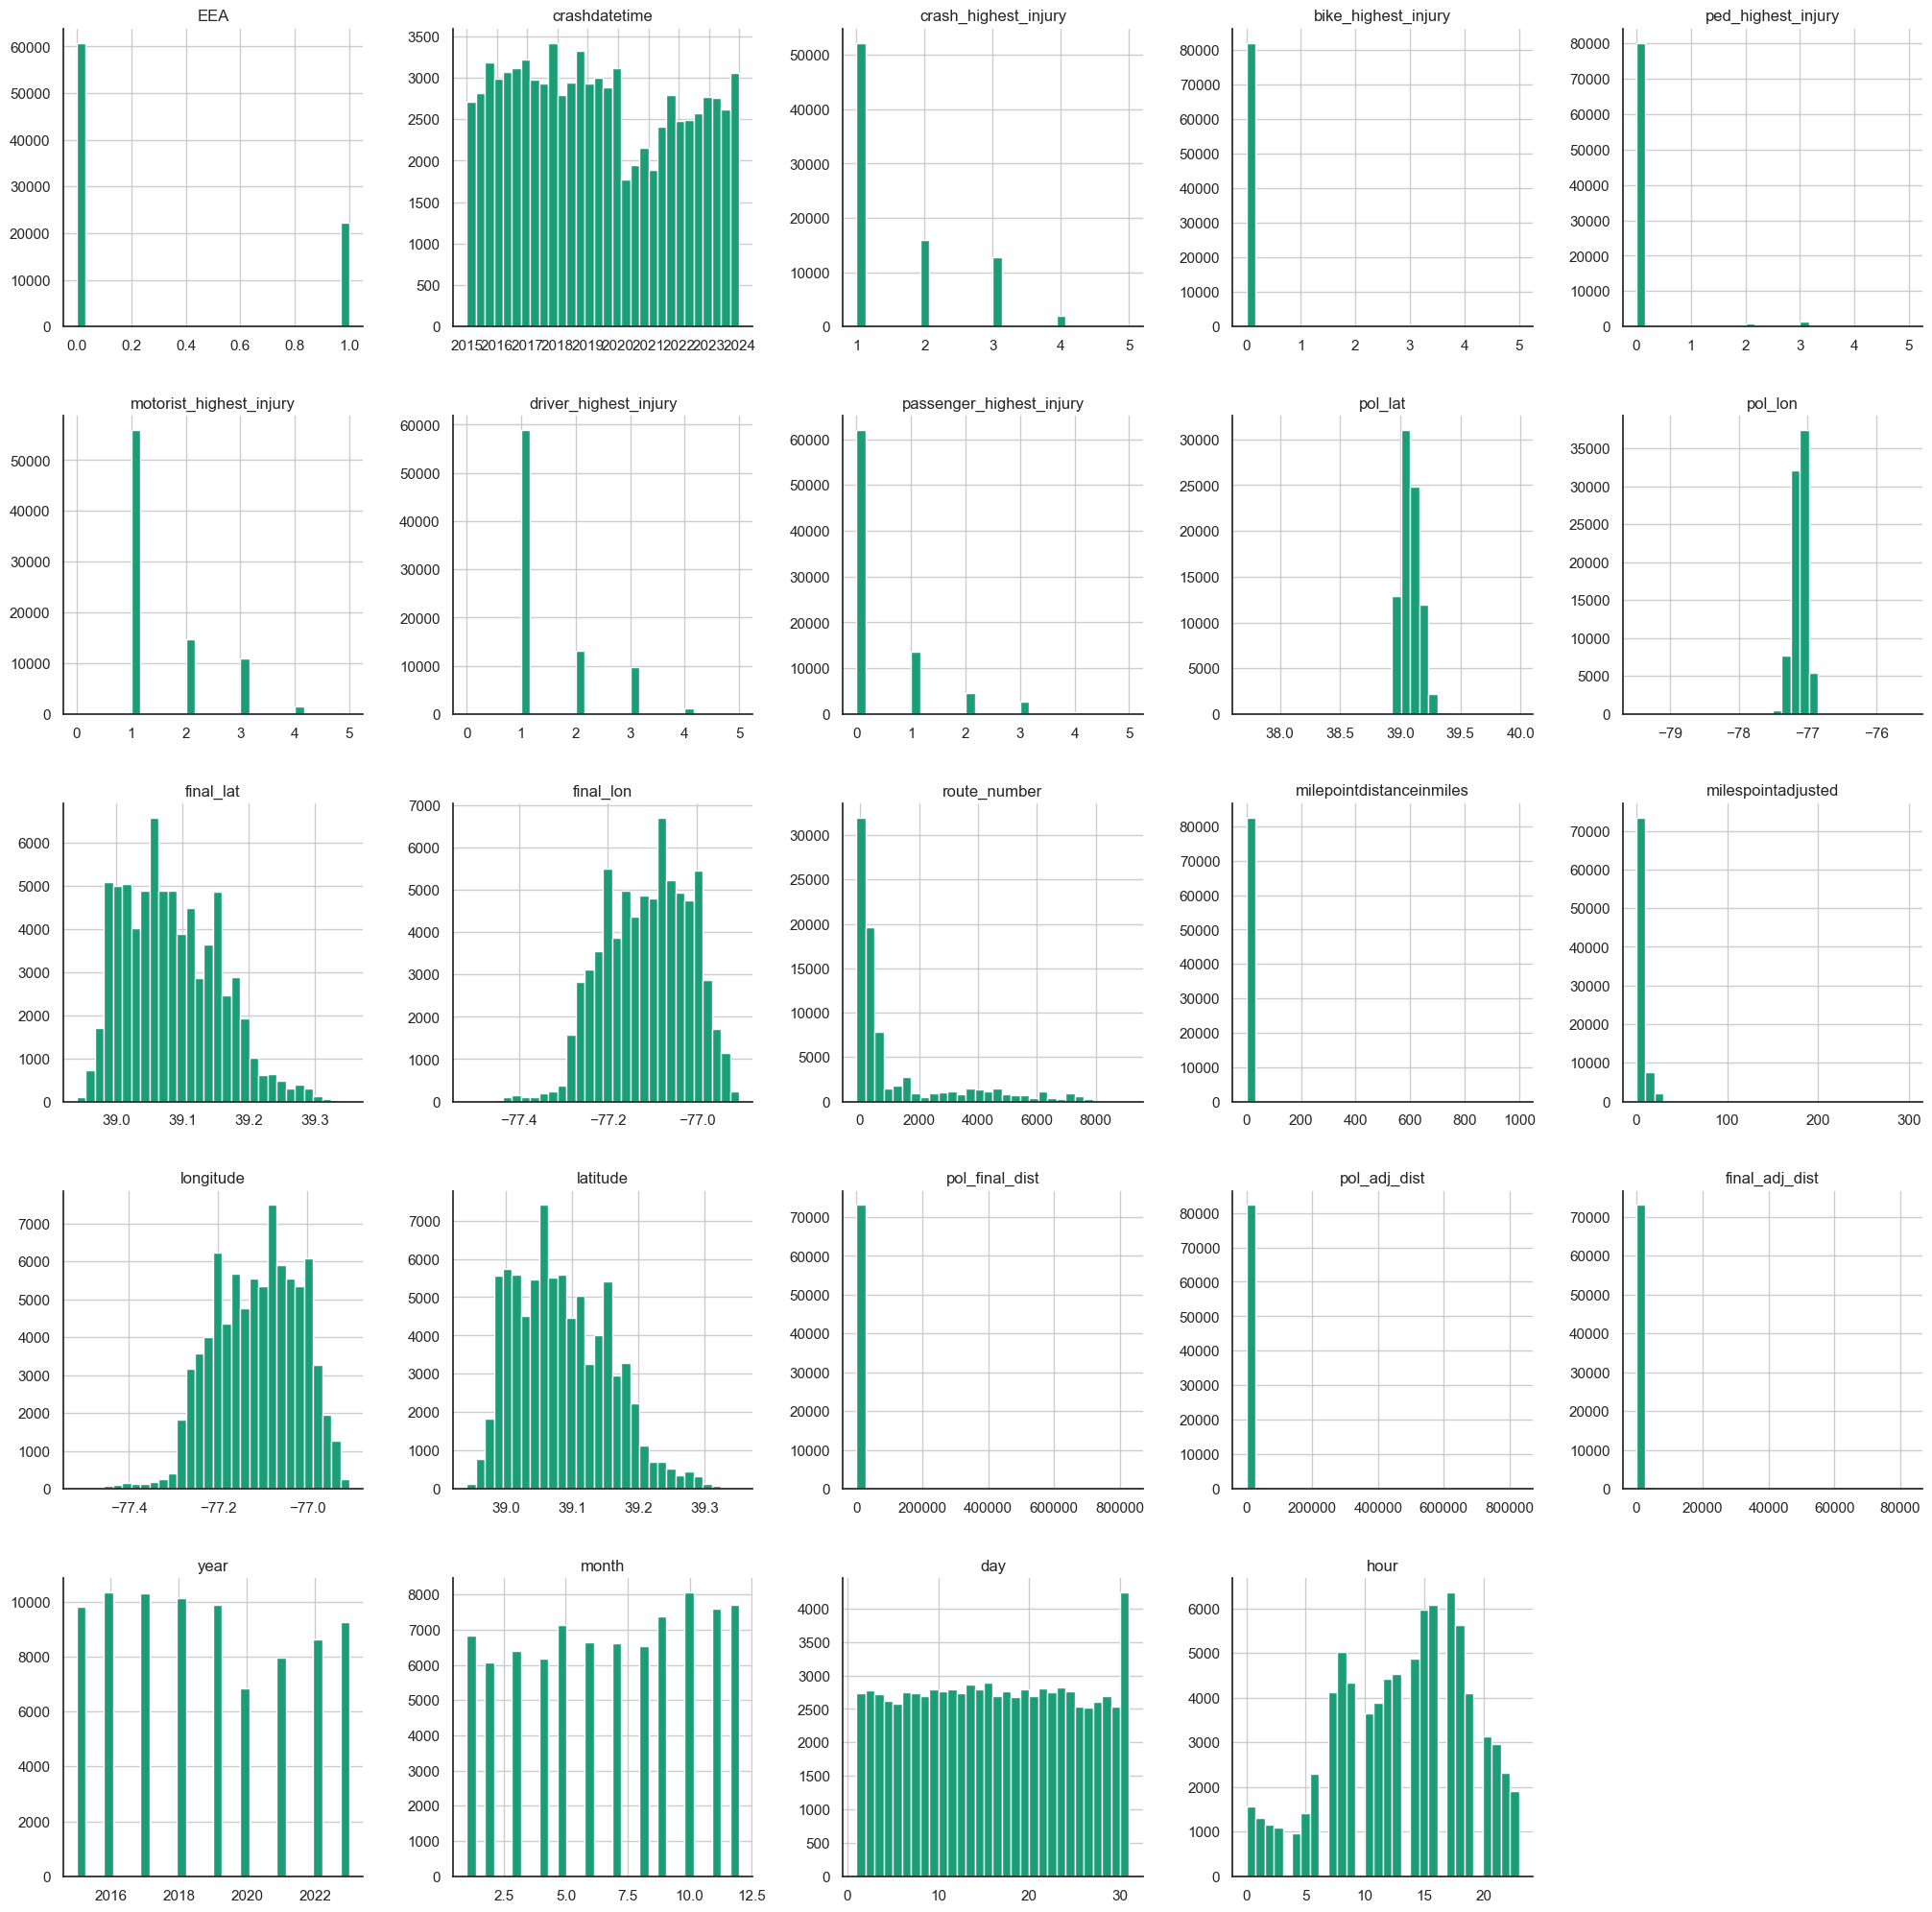

In [176]:
# Creating histogram of the numerical variables
sns.set_theme(style='white', palette="Dark2")

crash_sj.select_dtypes(exclude=[object]).hist(bins=30, figsize=(25, 25))
plt.title('Histogram of numerical values')

sns.despine(top=True, right=True)

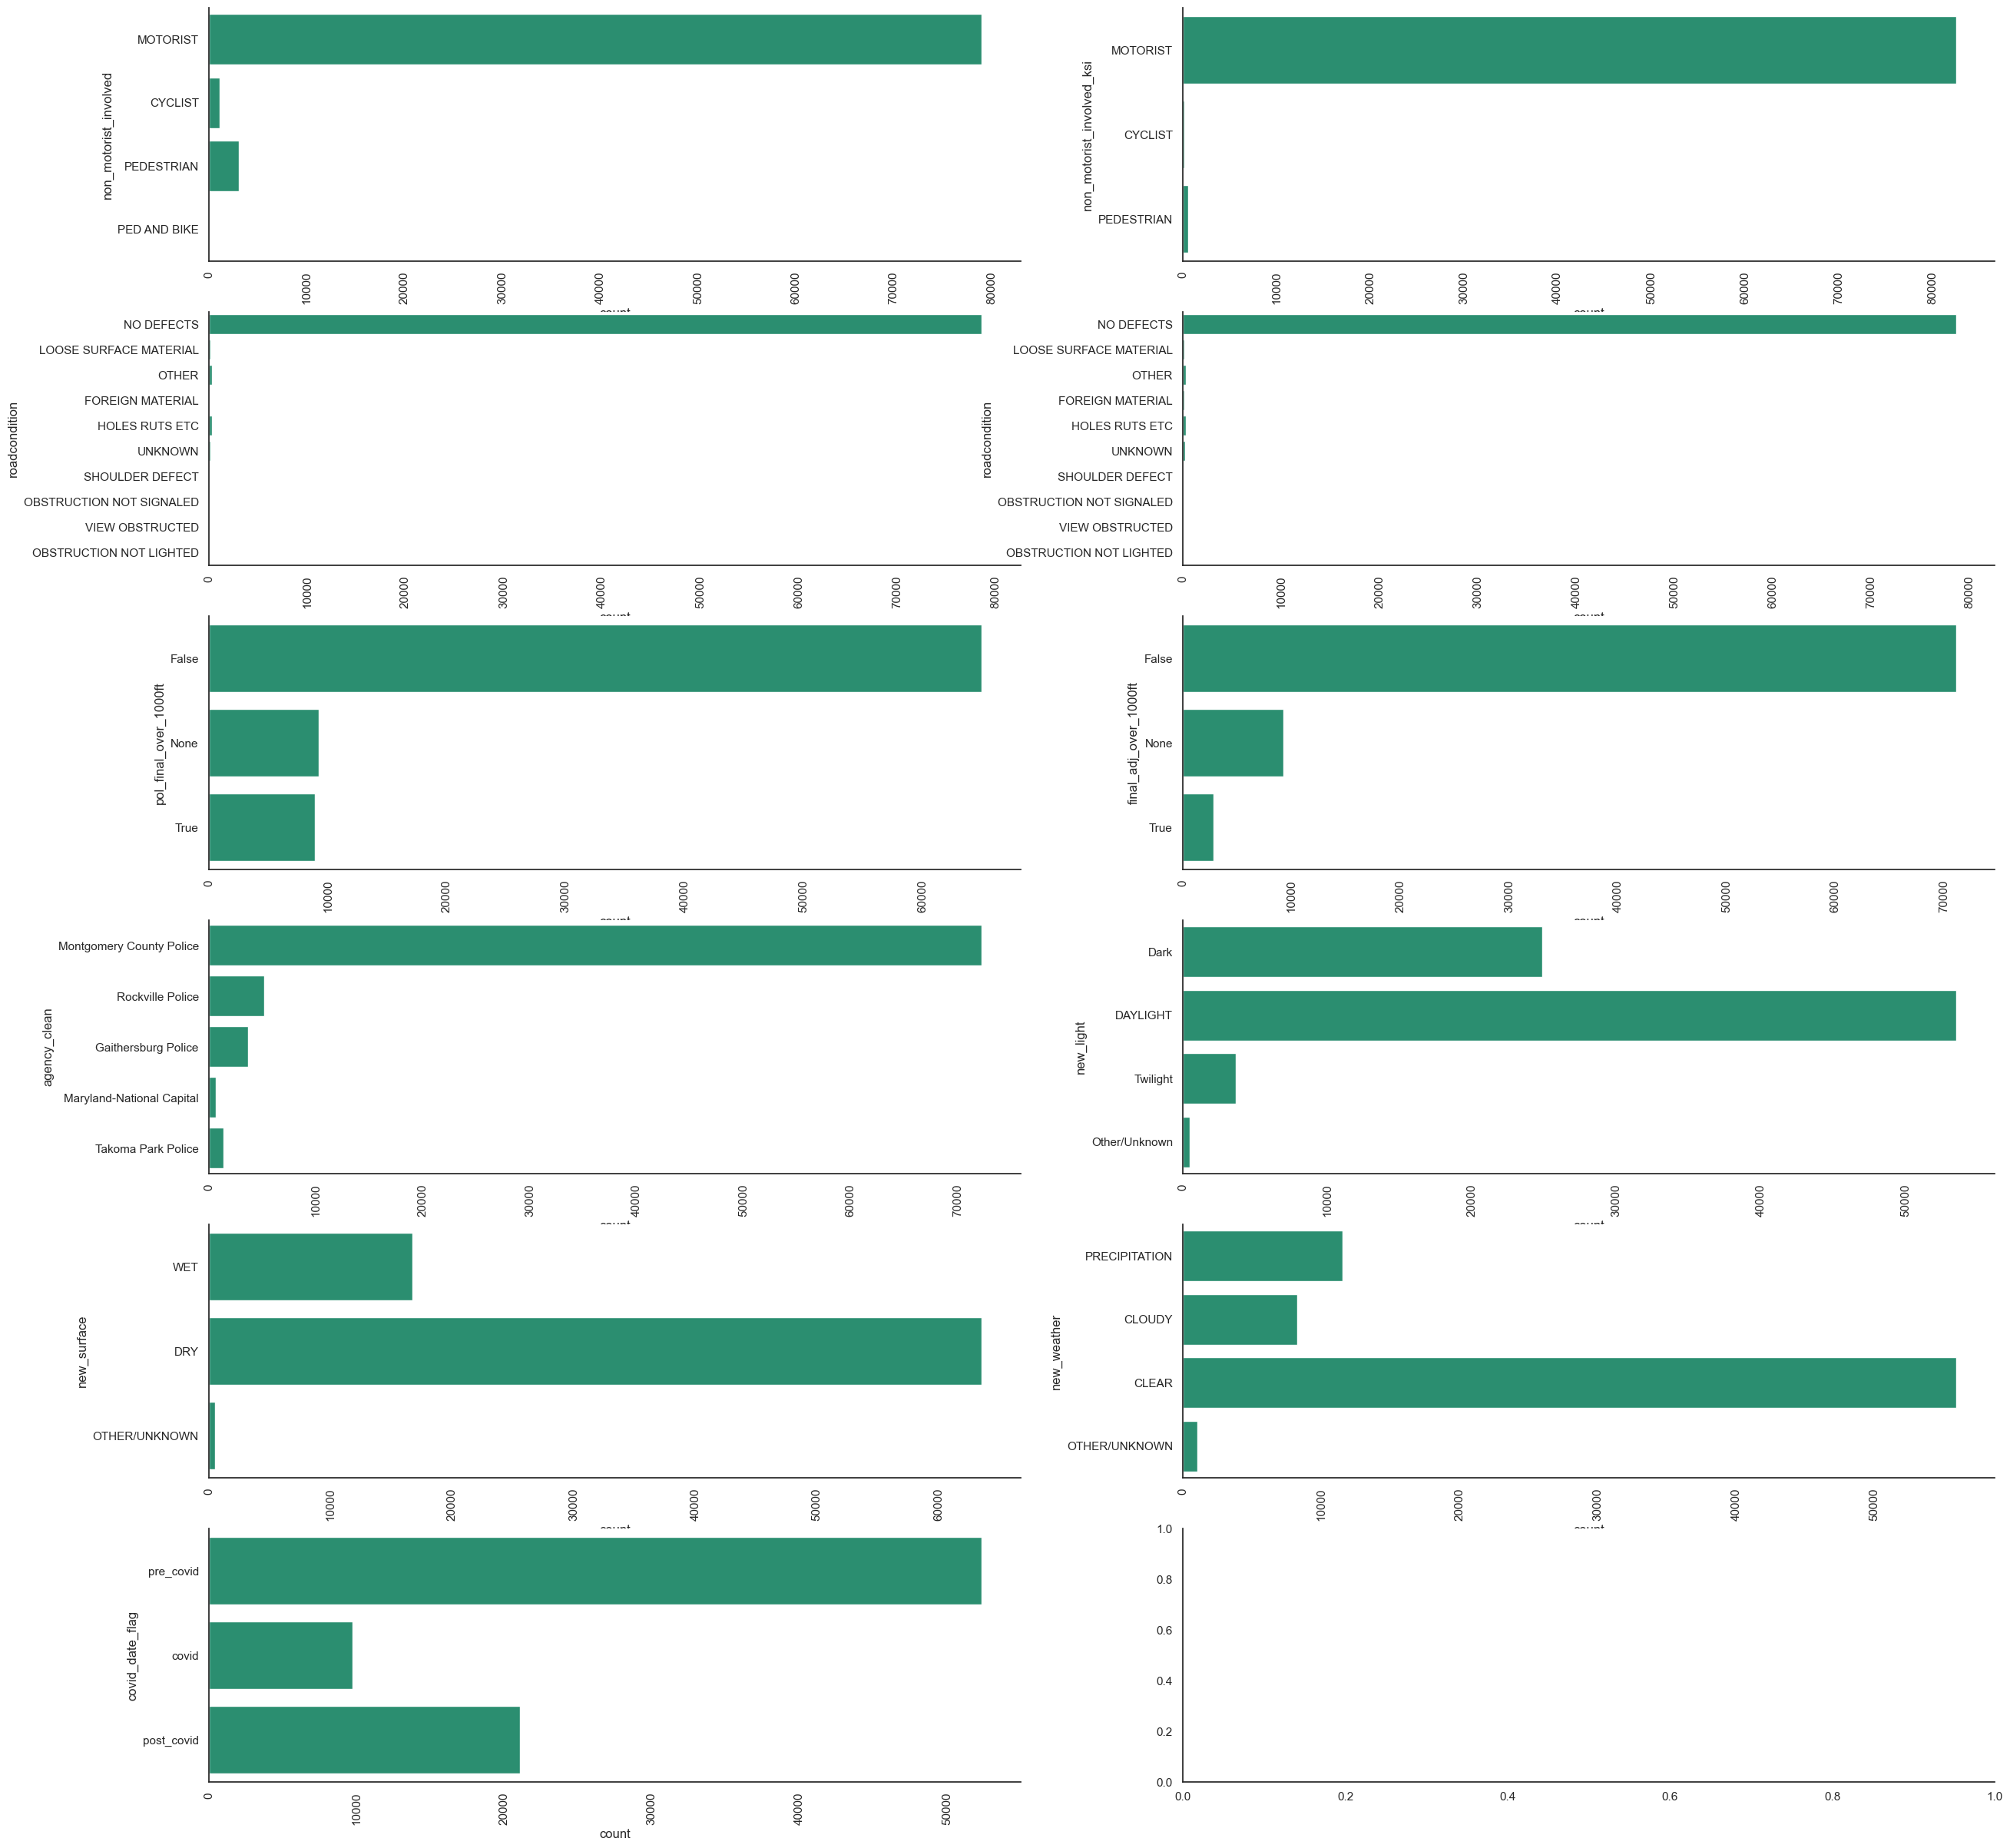

In [177]:
# Creating count plots of the  of the  categorical variables
#Source: Li, Lorraine. 19 Feb 2019. "How to Perform Exploratory Data Analysis with Seaborn." Toward Data Science. Https://towardsdatascience.com/how-to-perform-exploratory-data-analysis-with-seaborn-97e3413e841d

categorical = crash_sj[['non_motorist_involved','non_motorist_involved_ksi', 'roadcondition', 'roadcondition', 'pol_final_over_1000ft', 'final_adj_over_1000ft','agency_clean', 'new_light', 'new_surface', 'new_weather', 'covid_date_flag']]
fig, ax = plt.subplots(6, 2, figsize=(30, 30))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(crash_sj[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
sns.despine(top=True, right=True)

### Exploring flagged coordinates

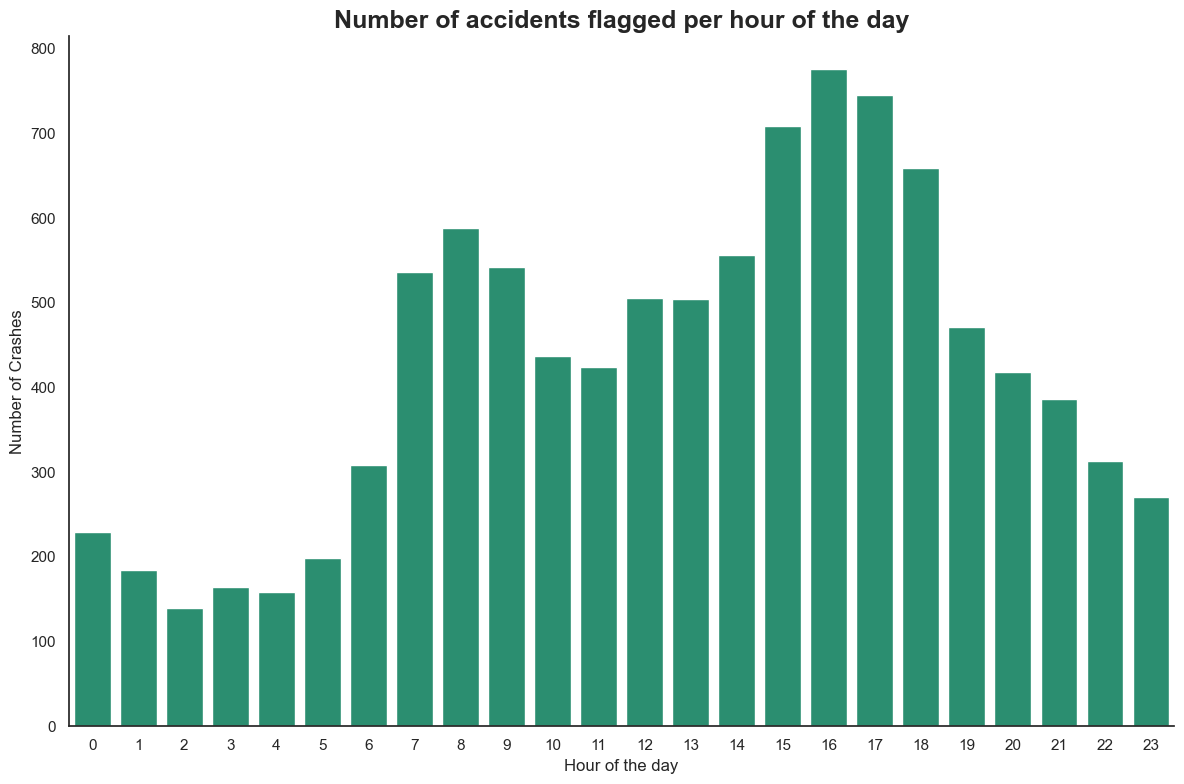

In [178]:
plt.figure(figsize = (12,8))

sns.barplot(crash_sj.query('pol_adj_over_1000ft==True')['hour'].value_counts()).set(
                                                                       xlabel="Hour of the day",
                                                                       ylabel="Number of Crashes")
sns.despine()

plt.title("Number of accidents flagged by hour of the day",fontweight='bold', fontsize=18)
plt.tight_layout()
plt.show()

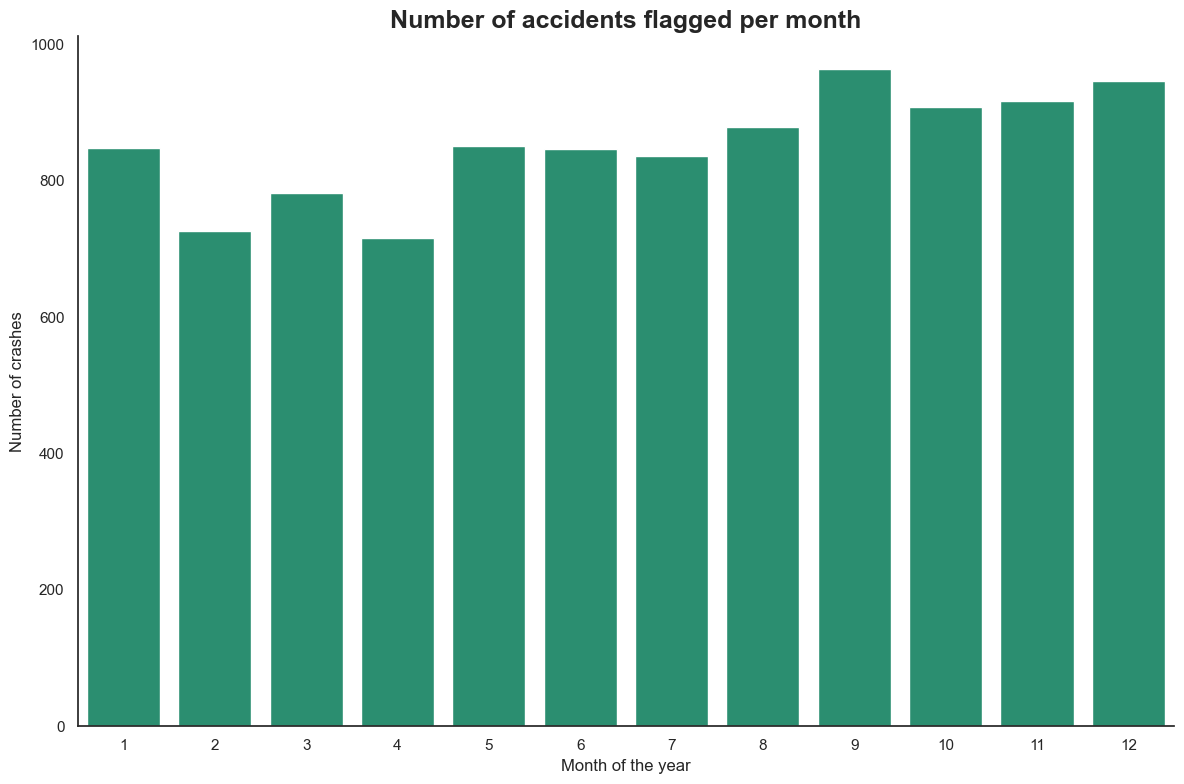

In [179]:
plt.figure(figsize = (12,8))

sns.barplot(crash_sj.query('pol_adj_over_1000ft==True')['month'].value_counts()).set(
                                                                       xlabel="Month of the year",
                                                                       ylabel="Number of crashes")
sns.despine()

plt.title("Number of accidents flagged by month of the year",fontweight='bold', fontsize=18)
plt.tight_layout()
plt.show()

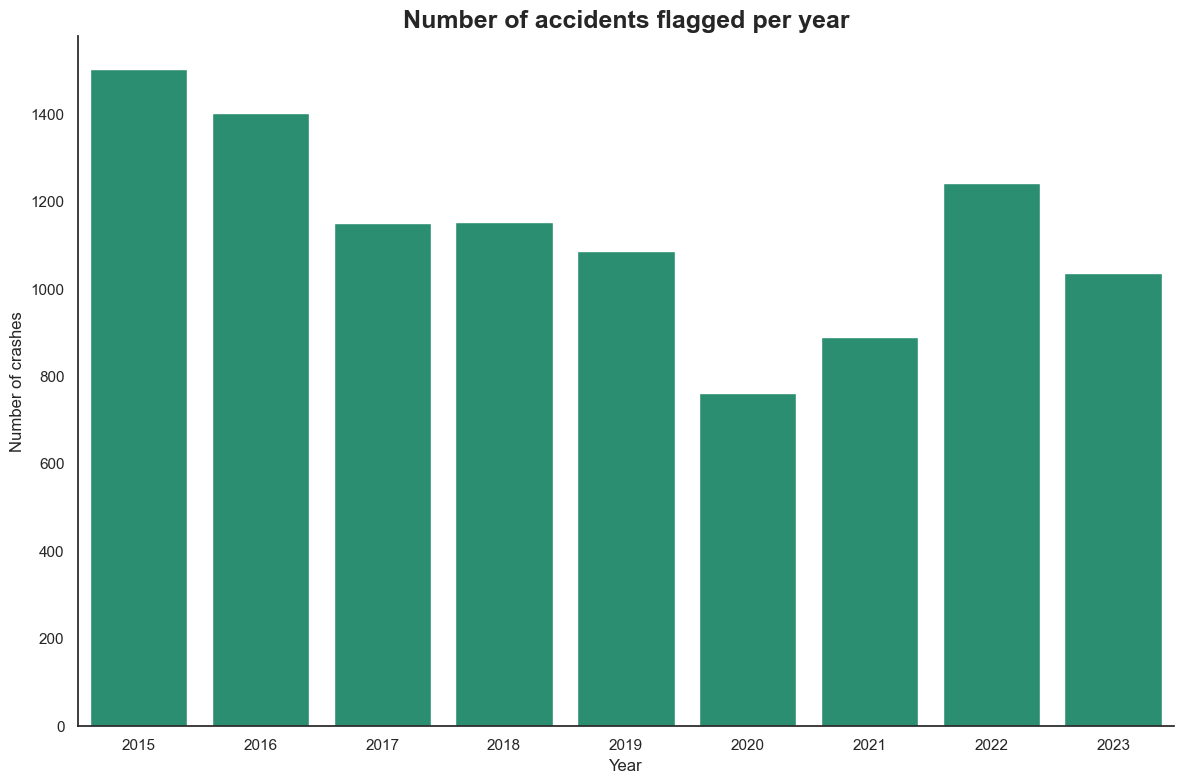

In [180]:
plt.figure(figsize = (12,8))

sns.barplot(crash_sj.query('pol_adj_over_1000ft==True')['year'].value_counts()).set(
                                                                       xlabel="Year",
                                                                       ylabel="Number of crashes")
sns.despine()

plt.title("Number of accidents flagged by year",fontweight='bold', fontsize=18)
plt.tight_layout()
plt.show()

What proportion of the ACRS crash locations were flagged as being over 1000 feet away from their final relocated coordinate?

In [181]:
#Calculating the percentage of crashes adjusted using mile points data
crash_sj['pol_adj_over_1000ft'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

pol_adj_over_1000ft
False    87.7%
True     12.3%
Name: proportion, dtype: object

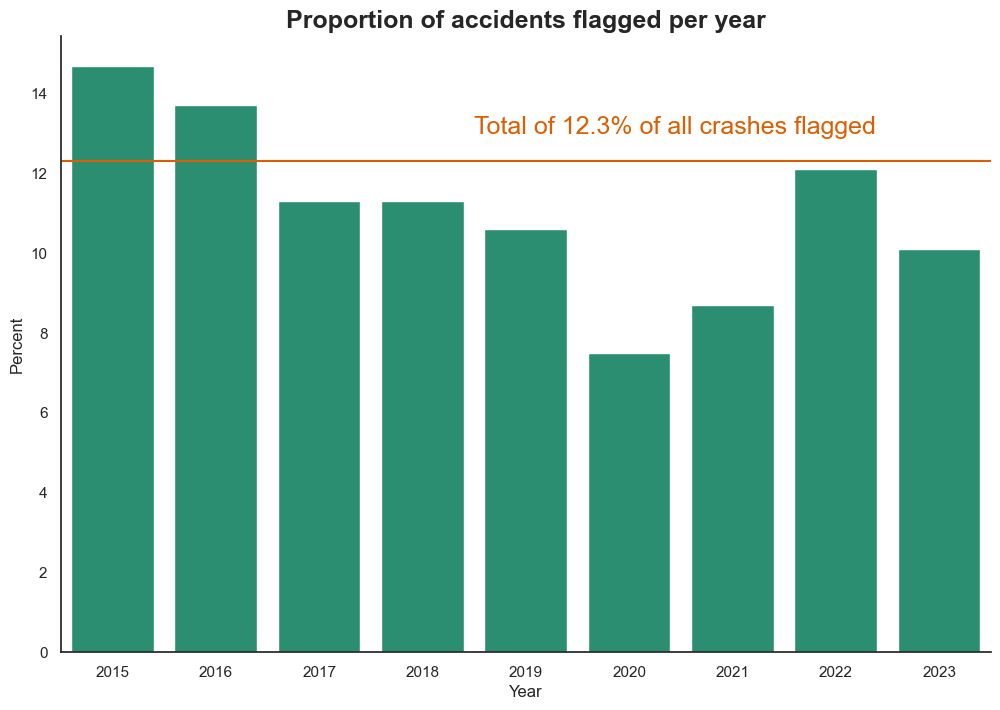

In [182]:
plt.figure(figsize = (12,8))

sns.barplot(crash_sj.query('pol_adj_over_1000ft==True')['year'].value_counts(normalize=True).mul(100).round(1)).set(
                                                                       xlabel="Year",
                                                                       ylabel="Percent")
sns.despine()
plt.axhline(y=12.3,color='#d95f02', linestyle='solid')
plt.title("Proportion of accidents flagged by year",fontweight='bold', fontsize=18)
plt.text(3.5, 13, 'Total of 12.3% of all crashes flagged', color='#d95f02', fontsize=18)


plt.show()

Overall, in 12.3% of the crash locations between 2015 to 2023, the distance between the original crash coordinates and the relocated coordinates was more than 1000 feet.

Where were flagged crashes located before relocation?

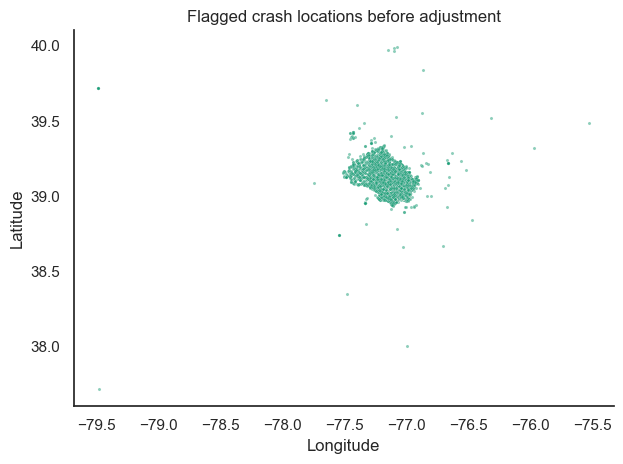

In [183]:
_=crash_sj.query('pol_adj_over_1000ft==True')
sns.scatterplot(_, x='pol_lon', y='pol_lat', s=5, alpha=.5).set(title="Flagged crash locations before adjustment",
                                                                       xlabel="Longitude",
                                                                       ylabel="Latitude")
plt.tight_layout()

sns.despine()

What percent of the ACRS crash locations were outside of the county boundaries?

In [184]:
crash_sj['in_moco'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

in_moco
True     99.75%
False     0.25%
Name: proportion, dtype: object

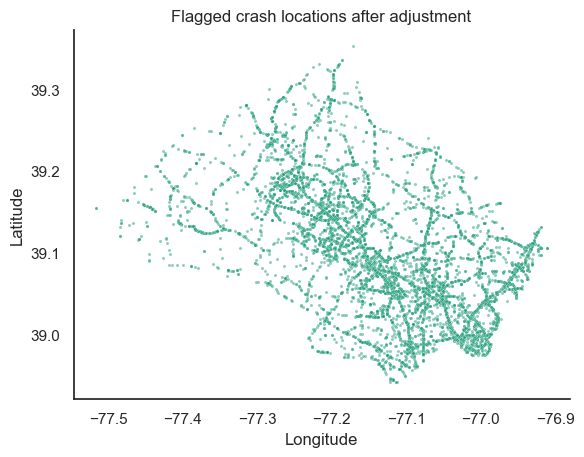

In [185]:

sns.scatterplot(_, x='longitude', y='latitude', s=5, alpha=.5).set(title="Flagged crash locations after adjustment",
                                                                       xlabel="Longitude",
                                                                       ylabel="Latitude")


sns.despine()



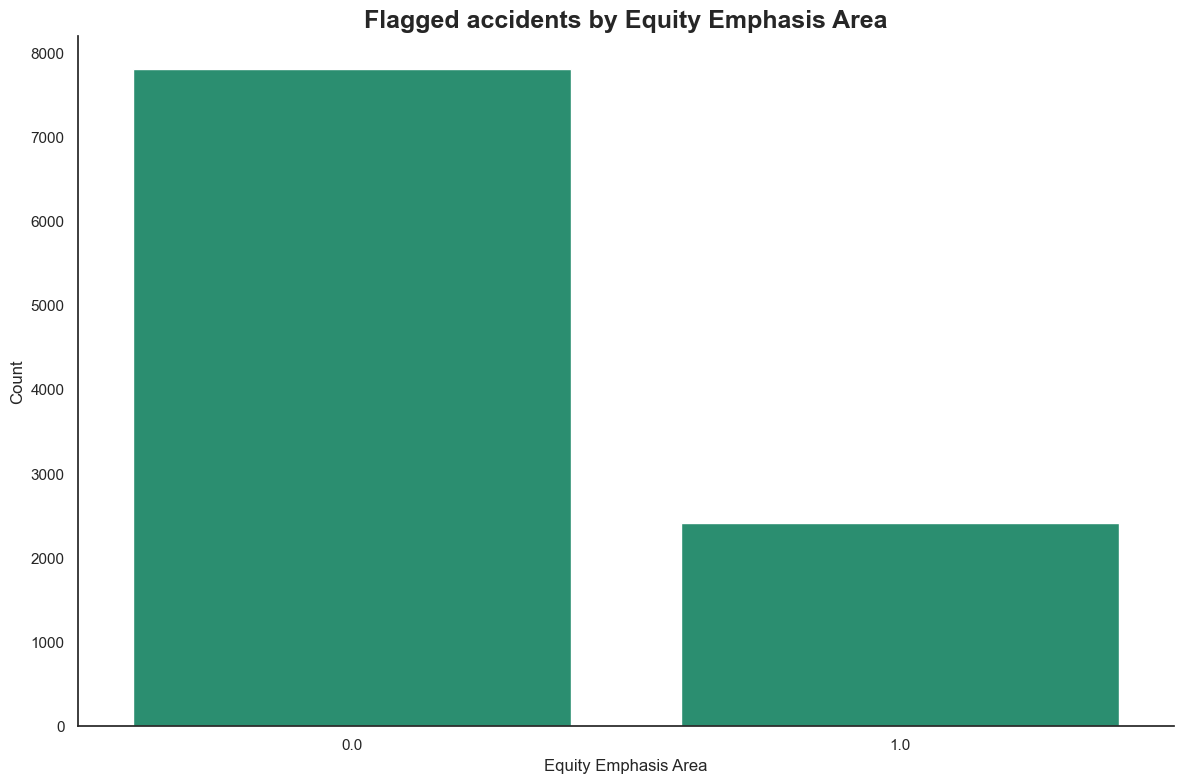

In [186]:
plt.figure(figsize = (12,8))

_=crash_sj.query('pol_adj_over_1000ft==True')
sns.barplot(_.groupby('EEA')['pol_final_over_1000ft'].count()).set(xlabel="Equity Emphasis Area",
                                                                       ylabel="Count")
sns.despine()

plt.title('Flagged accidents by equity emphasis area', fontweight = 'bold', fontsize=18)
plt.tight_layout()


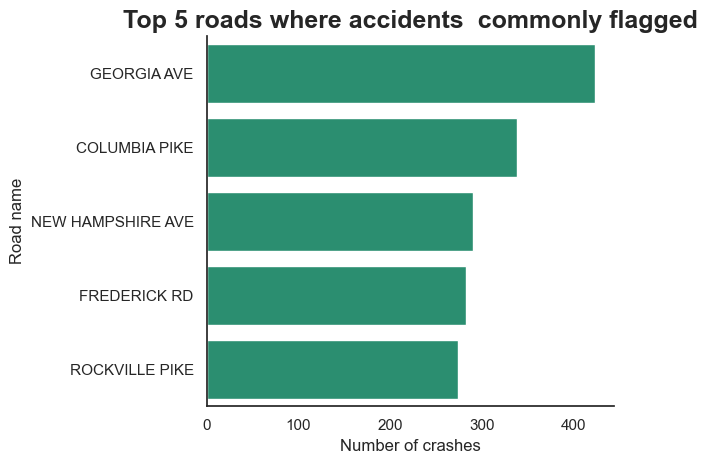

In [187]:
sns.barplot(_['road_name_clean'].value_counts().head(5), orient='h' ).set(title="Flagged crash locations before relocation",
                                                                       ylabel='Road name',
                                                                       xlabel="Number of crashes")
plt.title('Top 5 roads where accidents  commonly flagged', fontweight = 'bold', fontsize=18)

plt.tight_layout()

sns.despine()

## Hypothesis testing

The Chi-Square test for independence tests whether two categorical variables are independent or related.

$H0$: The two variables are independent.

$H1$: The two variables are not independent.

In [188]:
# Conducting test for independence of the flagged locations with several variables

chisqt1 = pd.crosstab(crash_sj.pol_adj_over_1000ft, crash_sj.agency_clean)
chisqt2 = pd.crosstab(crash_sj.pol_adj_over_1000ft, crash_sj.new_weather)
chisqt3 = pd.crosstab(crash_sj.pol_adj_over_1000ft, crash_sj.new_light)
chisqt4 = pd.crosstab(crash_sj.pol_adj_over_1000ft, crash_sj.new_surface)
chisqt5 = pd.crosstab(crash_sj.pol_adj_over_1000ft, crash_sj.acrsreporttype)
chisqt6 = pd.crosstab(crash_sj.pol_adj_over_1000ft, crash_sj.non_motorist_involved)
chisqt7 = pd.crosstab(crash_sj.pol_adj_over_1000ft, crash_sj.bike_involved)
chisqt8 = pd.crosstab(crash_sj.pol_adj_over_1000ft, crash_sj.ped_involved)
chisqt9 = pd.crosstab(crash_sj.pol_adj_over_1000ft, crash_sj.crash_highest_injury)


chi2_1, p_1, dof_1, _ = chi2_contingency(chisqt1)
chi2_2, p_2, dof_2, _ = chi2_contingency(chisqt2)
chi2_3, p_3, dof_3, _ = chi2_contingency(chisqt3)
chi2_4, p_4, dof_4, _ = chi2_contingency(chisqt4)
chi2_5, p_5, dof_5, _ = chi2_contingency(chisqt5)
chi2_6, p_6, dof_6, _ = chi2_contingency(chisqt6)
chi2_7, p_7, dof_7, _ = chi2_contingency(chisqt7)
chi2_8, p_8, dof_8, _ = chi2_contingency(chisqt8)
chi2_9, p_9, dof_9, _ = chi2_contingency(chisqt9)


# Printing the chi-square test statistic and p-values 
print(f"Chi-Square statistic for flagged locations and reporting agency: {chi2_1}, p-value: {p_1}")
print(f"Chi-Square statistic for flagged locations and weather: {chi2_2}, p-value: {p_2}")
print(f"Chi-Square statistic for flagged locations and light conditions: {chi2_3}, p-value: {p_3}")
print(f"Chi-Square statistic for flagged locations and surface conditions: {chi2_4}, p-value: {p_4}")
print(f"Chi-Square statistic for flagged locations and report type: {chi2_5}, p-value: {p_5}")
print(f"Chi-Square statistic for flagged locations and non_motorist_involved: {chi2_6}, p-value: {p_6}")
print(f"Chi-Square statistic for flagged locations and bike_involved: {chi2_7}, p-value: {p_7}")
print(f"Chi-Square statistic for flagged locations and ped_involved): {chi2_8}, p-value: {p_8}")
print(f"Chi-Square statistic for flagged locations and injury): {chi2_9}, p-value: {p_9}")


Chi-Square statistic for flagged locations and reporting agency: 143.03597551947027, p-value: 6.317980830107292e-30
Chi-Square statistic for flagged locations and weather: 89.90199438312686, p-value: 2.2993617891121496e-19
Chi-Square statistic for flagged locations and light conditions: 34.92422609193821, p-value: 1.2639929110743969e-07
Chi-Square statistic for flagged locations and surface conditions: 118.0717981802776, p-value: 2.2963325979635596e-26
Chi-Square statistic for flagged locations and report type: 40.19483799965465, p-value: 1.869828727536206e-09
Chi-Square statistic for flagged locations and non_motorist_involved: 8.499372700804567, p-value: 0.03674352351997154
Chi-Square statistic for flagged locations and bike_involved: 0.5695677266783006, p-value: 0.4504307414181883
Chi-Square statistic for flagged locations and ped_involved): 7.252141830080167, p-value: 0.007081649525476952
Chi-Square statistic for flagged locations and injury): 49.47907788480542, p-value: 4.63826455

With the exception of the bike involved, all p-values are less than 0.05. We can reject the null hypothesis that the flagged locations and all variables tested are independent except for bike involved.  

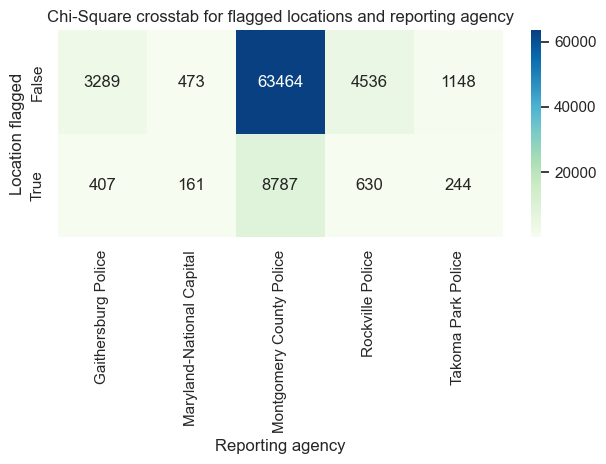

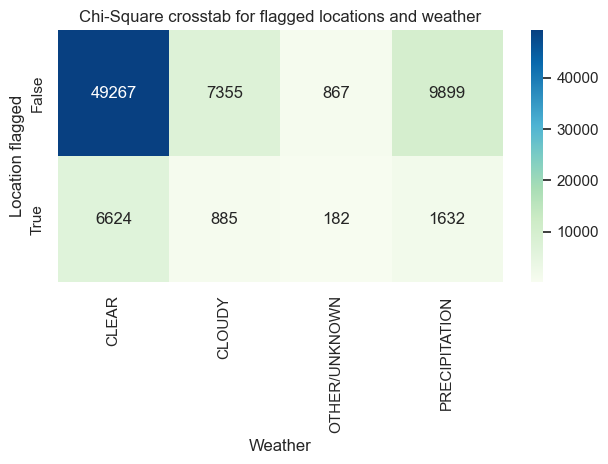

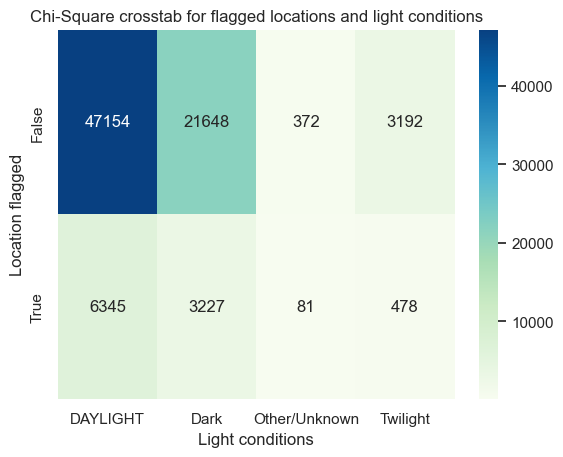

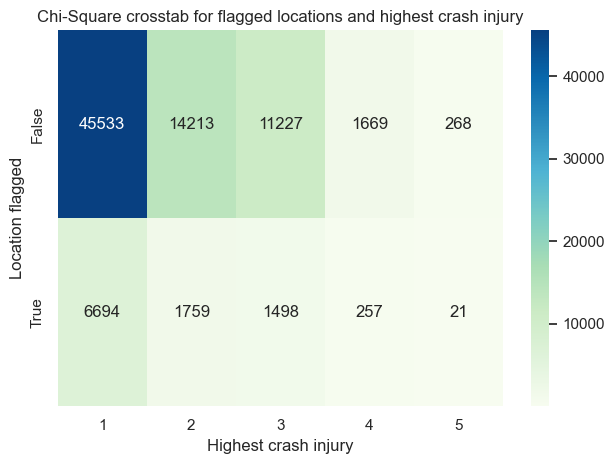

In [189]:

sns.heatmap(chisqt1, annot=True, fmt='d', cmap='GnBu').set(title="Chi-Square crosstab for flagged locations and reporting agency",
                                                                       ylabel='Location flagged',
                                                                       xlabel="Reporting agency")
plt.tight_layout()
plt.show()         

sns.heatmap(chisqt2, annot=True, fmt='d', cmap='GnBu').set(title="Chi-Square crosstab for flagged locations and weather",
                                                                       ylabel='Location flagged',
                                                                       xlabel="Weather")
plt.tight_layout()
plt.show()

sns.heatmap(chisqt3, annot=True, fmt='d', cmap='GnBu').set(title="Chi-Square crosstab for flagged locations and light conditions",
                                                                       ylabel='Location flagged',
                                                                       xlabel="Light conditions") 
plt.show()


sns.heatmap(chisqt9, annot=True, fmt='d', cmap='GnBu').set(title="Chi-Square crosstab for flagged locations and highest crash injury",
                                                                       ylabel='Location flagged',
                                                                       xlabel="Highest crash injury") 

plt.tight_layout()
plt.show()



In [190]:
# Calculating the measures of association 
v1 = stats.contingency.association(chisqt1)
v2 = stats.contingency.association(chisqt2)
v3 = stats.contingency.association(chisqt3)
v4 = stats.contingency.association(chisqt4)
v5 = stats.contingency.association(chisqt5)
v6 = stats.contingency.association(chisqt6)
v8 = stats.contingency.association(chisqt8)
v9 = stats.contingency.association(chisqt9)


print(f"Cramer’s V for flagged locationsand reporting agency: {v1}")
print(f"Cramer’s V for flagged locations and weather: {v2}")
print(f"Cramer’s V for flagged locationsand light conditions: {v3}")
print(f"Cramer’s V for flagged locations and surface conditions: {v4}")
print(f"Cramer’s V for flagged locations and non_motorist_involved: {v5}")
print(f"Cramer’s V for flagged locations and bike_involved: {v6}")
print(f"Cramer’s V for flagged locations and ped_involved: {v8}")
print(f"Cramer’s V for flagged locations and injury: {v9}")


Cramer’s V for flagged locationsand reporting agency: 0.04147823261822087
Cramer’s V for flagged locations and weather: 0.03423385769182335
Cramer’s V for flagged locationsand light conditions: 0.02057521195000477
Cramer’s V for flagged locations and surface conditions: 0.03821044119703464
Cramer’s V for flagged locations and non_motorist_involved: 0.02198784886104391
Cramer’s V for flagged locations and bike_involved: 0.010110928484056796
Cramer’s V for flagged locations and ped_involved: 0.009437153933815157
Cramer’s V for flagged locations and injury: 0.024395425669997802


Using Cramer's V test to measure the assocation between the flagged crash locations and the select variables shows that asociaion is weak in all cases.

## Clustering flagged locations

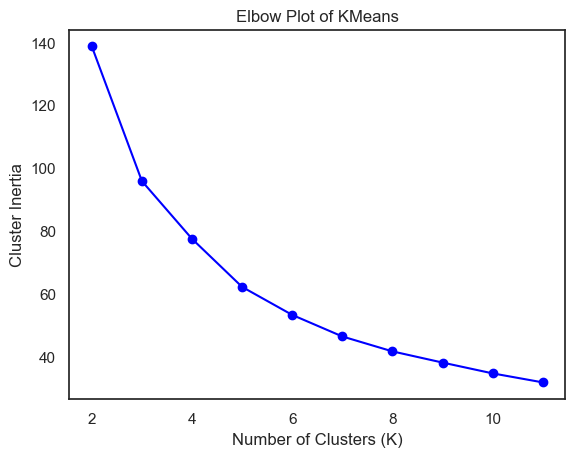

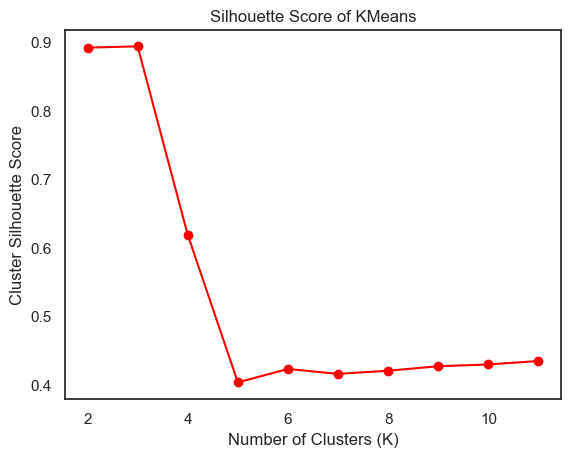

In [296]:
# Identifying optimal K and calculating silhouette scores

def optimal_clusters(data, maximum_K):
    
    clusters_centers = []
    k_values = []
    silhouette_scores = []
    
    for k in range(2, maximum_K):
        
        kmeans_model = KMeans(n_clusters = k, n_init=10, random_state=1)
        kmeans_model.fit(data)
        clusters_centers.append(kmeans_model.inertia_)
        cluster_labels = kmeans_model.labels_
        k_values.append(k)
        silhouette_scores.append(silhouette_score(data, cluster_labels))
    
    plt.plot(k_values, clusters_centers, 'o-', color = 'blue')
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Cluster Inertia")
    plt.title("Elbow Plot of KMeans")
    plt.show()
    
    plt.plot(k_values,  silhouette_scores, 'o-', color = 'red')
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Cluster Silhouette Score")
    plt.title("Silhouette Score of KMeans")
    plt.show()

optimal_clusters(flagged, 12)


In [297]:
# Applying kmeans based on optimal number of clusters identified
kmeans = KMeans(n_clusters=3)
flagged["Cluster"] = kmeans.fit_predict(flagged)
flagged["Cluster"] = flagged["Cluster"]

flagged.head()

pol_lat    pol_lon  Cluster
580  39.084611 -77.199848        0
580  39.103047 -77.190177        0
580  39.120055 -77.180452        0
580  39.052542 -77.117780        1
580  39.094978 -77.202238        0

In [298]:
flagged["Cluster"].value_counts()

Cluster
0    4492
1    3283
2    2454
Name: count, dtype: int64

In [299]:
centroids = kmeans.cluster_centers_
centroids 

array([[ 3.91660306e+01, -7.72376722e+01,  1.00155833e+00],
       [ 3.90520349e+01, -7.71007388e+01,  5.49560397e-15],
       [ 3.90483285e+01, -7.69863752e+01, -6.43929354e-15]])

Text(0, 0.5, 'Latitude')

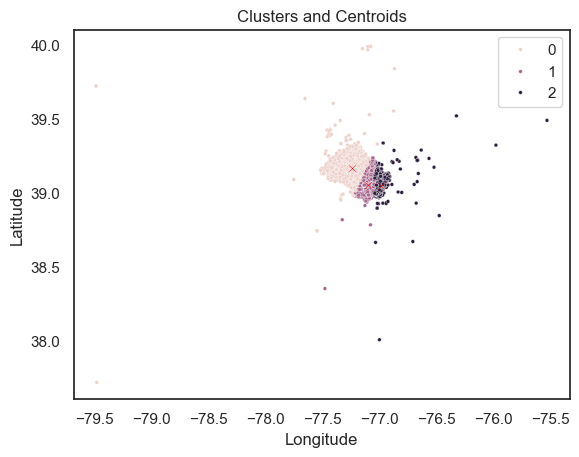

In [300]:
# Plotting the clusters and centroids
sns.scatterplot(x=flagged['pol_lon'], y=flagged['pol_lat'], hue=flagged['Cluster'], s=7)
sns.scatterplot(x=centroids[:,1], y= centroids[:,0], c='red', s=20, marker='x')
plt.title('Clusters and Centroids')
plt.xlabel("Longitude")
plt.ylabel("Latitude")


In [301]:
# Saving flagged coordinates and clusters for mapping 
flagged.to_csv('flagged_crashes.csv')
flagged=gpd.GeoDataFrame(flagged, geometry=gpd.points_from_xy(flagged['pol_lon'], flagged['pol_lat']))
flagged=flagged[['geometry', 'Cluster']]
flagged.to_file('flagged.geojson', driver='GeoJSON') 

In [302]:
flagged

geometry  Cluster
580   POINT (-77.19985 39.08461)        0
580   POINT (-77.19018 39.10305)        0
580   POINT (-77.18045 39.12006)        0
580   POINT (-77.11778 39.05254)        1
580   POINT (-77.20224 39.09498)        0
...                          ...      ...
1110  POINT (-77.13414 39.05132)        1
1110  POINT (-77.13354 39.05120)        1
1110  POINT (-77.13343 39.05140)        1
1110  POINT (-77.54700 38.74337)        0
1110  POINT (-77.12862 39.05288)        1

[10229 rows x 2 columns]

## Forcecasting

Sources for this section include:

Facebook Open Source. Date Unknown. Accessed from https://facebook.github.io/prophet/docs/quick_start.html#python-api.
Mulla, Rob. 2020. Time Series forecasting with Prophet. Accessed from https://www.kaggle.com/code/robikscube/time-series-forecasting-with-prophet.

In [303]:
# Splitting data set to investigate trends before, during and after COVID
covid_date_start = pd.to_datetime('2020-03-13')
covid_date_end = pd.to_datetime('2021-08-30')

pre_covid=crash_sj.query('crashdatetime < @covid_date_start')
covid_date= crash_sj.query('@covid_date_start <= crashdatetime <= @covid_date_end')
post_covid=crash_sj.query('crashdatetime > @covid_date_end')

In [304]:
# Making a frame of US holidays
us_holidays = make_holidays_df(
    year_list=[2015 + i for i in range(20)], country='US',
)
us_holidays.sort_values(by='ds')

ds                      holiday
0   2015-01-01               New Year's Day
8   2015-01-19   Martin Luther King Jr. Day
9   2015-02-16        Washington's Birthday
1   2015-05-25                 Memorial Day
3   2015-07-03  Independence Day (observed)
..         ...                          ...
242 2034-10-09                 Columbus Day
237 2034-11-10      Veterans Day (observed)
236 2034-11-11                 Veterans Day
238 2034-11-23                 Thanksgiving
239 2034-12-25                Christmas Day

[243 rows x 2 columns]

In [305]:
# Getting a daily count of crashes before COVID
pre_covid_prophet = pre_covid.copy().groupby('crashdatetime')[['acrsreporttype']].count()
pre_covid_prophet = pre_covid_prophet.resample('D').sum()
pre_covid_prophet = pre_covid_prophet.reset_index()
pre_covid_prophet.columns = ['ds', 'y']
pre_covid_prophet

ds   y
0    2015-01-01  26
1    2015-01-02  13
2    2015-01-03  32
3    2015-01-04  20
4    2015-01-05  24
...         ...  ..
1893 2020-03-08  16
1894 2020-03-09  34
1895 2020-03-10  21
1896 2020-03-11  25
1897 2020-03-12  23

[1898 rows x 2 columns]

[Text(0.5, 1.0, 'Daily Crashes Pre-COVID'),
 Text(0, 0.5, 'Number of crashes'),
 Text(0.5, 0, 'Date')]

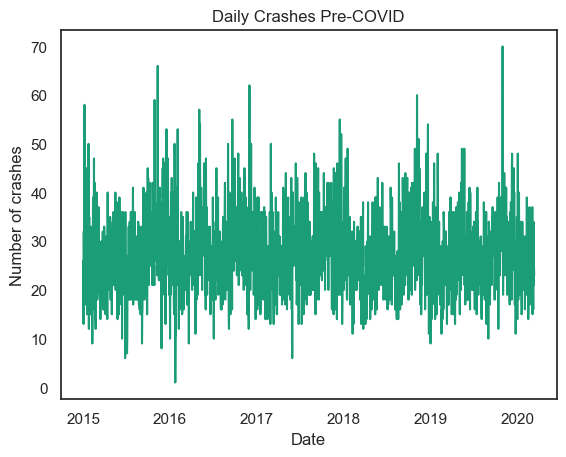

In [306]:
sns.lineplot(x='ds', y='y', data=pre_covid_prophet).set(title="Daily Crashes Pre-COVID",
                                                                       ylabel = 'Number of crashes',
                                                                       xlabel="Date")

In [307]:
split_date = '2019-3-13'
train = pre_covid_prophet[pre_covid_prophet['ds'] <= split_date]
test = pre_covid_prophet[pre_covid_prophet['ds'] > split_date]

# Checking the shape of the dataset
print(train.shape)
print(test.shape)

(1533, 2)
(365, 2)


21:26:02 - cmdstanpy - INFO - Chain [1] start processing
21:26:02 - cmdstanpy - INFO - Chain [1] done processing


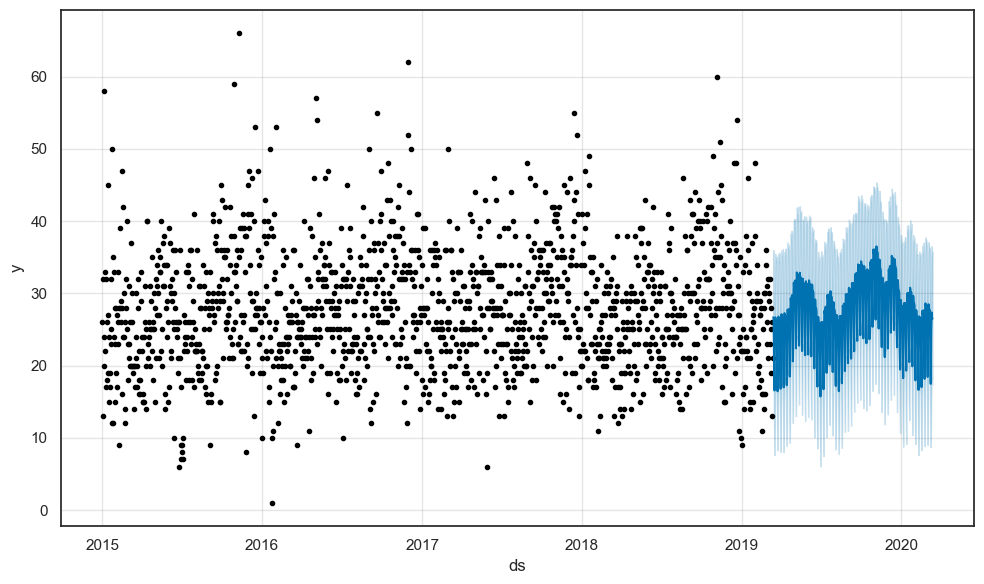

In [308]:
# Seting up and training model and fit
model_precvd = Prophet().fit(train)
forecast_precvd=model_precvd.predict(test)
model_precvd.plot(forecast_precvd);

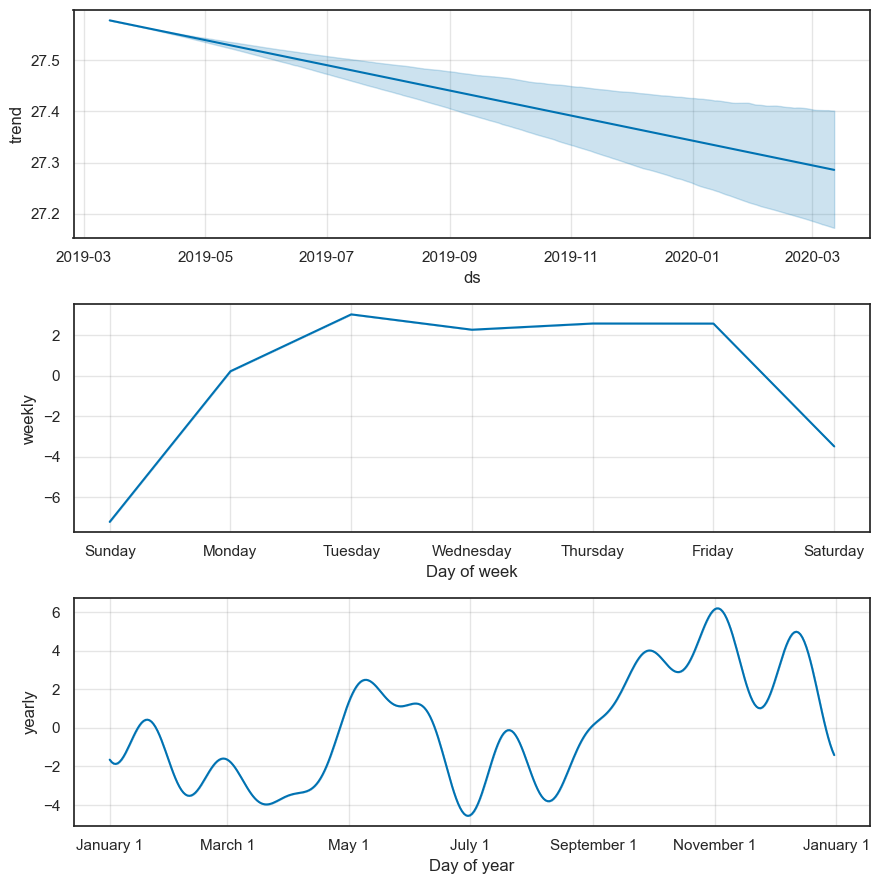

In [309]:
model_precvd.plot_components(forecast_precvd);

Text(0.5, 1.0, 'Forecast vs Actual Values')

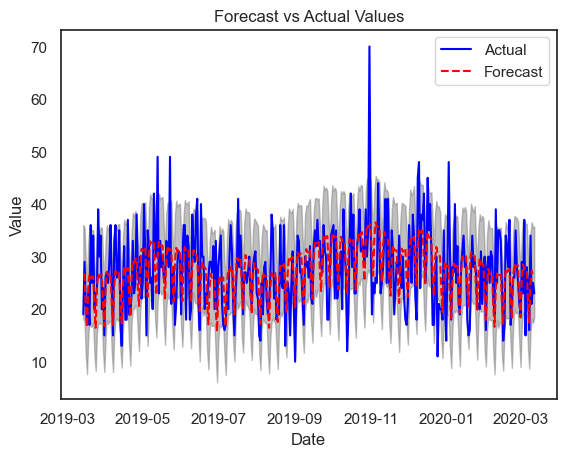

In [310]:
plt.plot(test['ds'], test['y'], label='Actual', color='blue')
plt.plot(test['ds'], forecast_precvd['yhat'], label='Forecast', color='red', linestyle='dashed')
plt.fill_between(test['ds'], forecast_precvd['yhat_lower'], forecast_precvd['yhat_upper'], color='grey', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs Actual Values')

In [311]:

print(f"The Mean Square Error is: {mean_squared_error(y_true=test['y'],y_pred=forecast_precvd['yhat'])}")
print(f"The Mean Absolute Error is : {mean_absolute_error(y_true=test['y'],y_pred=forecast_precvd['yhat'])}")
print(f"The Mean Absolute Percentage Error is: {mean_absolute_percentage_error(y_true=test['y'], y_pred=forecast_precvd['yhat'])}")

The Mean Square Error is: 42.70628024331117
The Mean Absolute Error is : 4.964494373821122
The Mean Absolute Percentage Error is: 0.19975595647851702


The initial model performed well. A mean absolute error between the forecast error and actual values is almost 5 crashes, but the model could likely perform better.

21:26:04 - cmdstanpy - INFO - Chain [1] start processing
21:26:04 - cmdstanpy - INFO - Chain [1] done processing


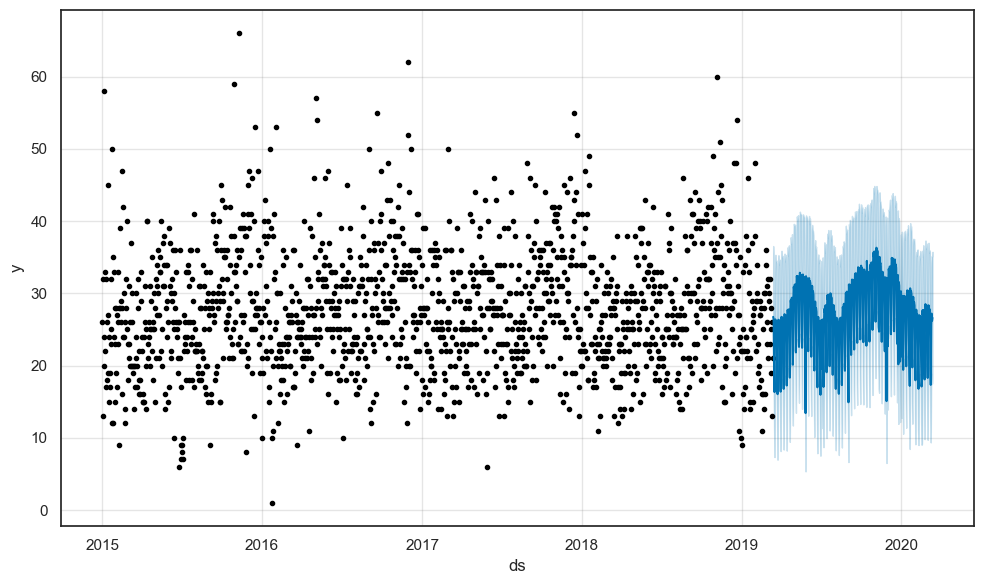

In [312]:
# New model with US holidays
model_precvd2=Prophet(holidays=us_holidays).fit(train)
forecast_precvd2 = model_precvd2.predict(test)
model_precvd2.plot(forecast_precvd2);

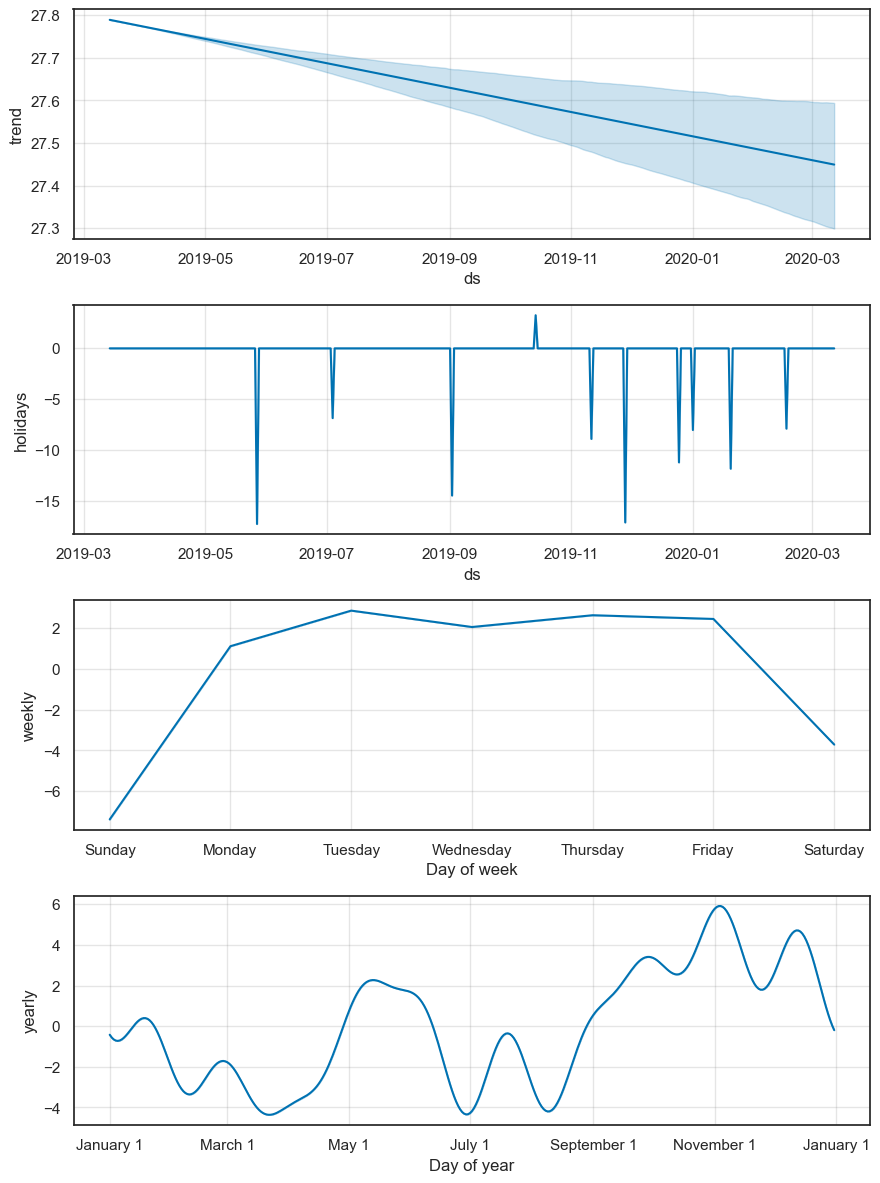

In [313]:
model_precvd2.plot_components(forecast_precvd2);

Text(0.5, 1.0, 'Forecast vs Actual Values')

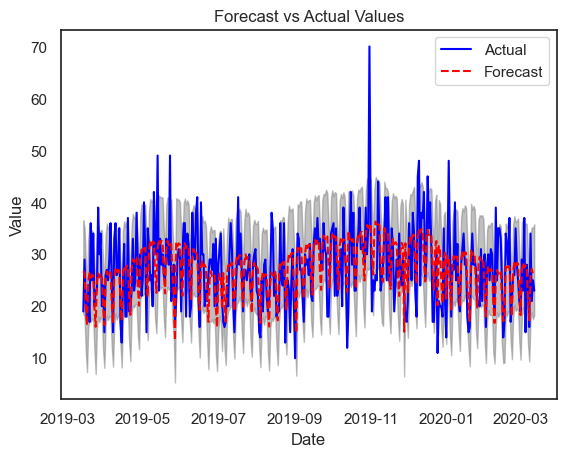

In [314]:
plt.plot(test['ds'], test['y'], label='Actual', color='blue')
plt.plot(test['ds'], forecast_precvd2['yhat'], label='Forecast', color='red', linestyle='dashed')
plt.fill_between(test['ds'], forecast_precvd2['yhat_lower'], forecast_precvd2['yhat_upper'], color='grey', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs Actual Values')

In [315]:
print(f"The Mean Square Error is: {mean_squared_error(y_true=test['y'],y_pred=forecast_precvd2['yhat'])}")
print(f"The Mean Absolute Error is : {mean_absolute_error(y_true=test['y'],y_pred=forecast_precvd2['yhat'])}")
print(f"The Mean Absolute Percentage Error is: {mean_absolute_percentage_error(y_true=test['y'], y_pred=forecast_precvd2['yhat'])}")

The Mean Square Error is: 40.61398843243521
The Mean Absolute Error is : 4.860694115925268
The Mean Absolute Percentage Error is: 0.19311517458567337


Adding US holidays, the model performs marginally better.

In [316]:
# Trying new model with seasonality added
model_precvd3=Prophet(holidays=us_holidays, yearly_seasonality=True)
model_precvd3 = model_precvd3.fit(train)

21:26:08 - cmdstanpy - INFO - Chain [1] start processing
21:26:08 - cmdstanpy - INFO - Chain [1] done processing


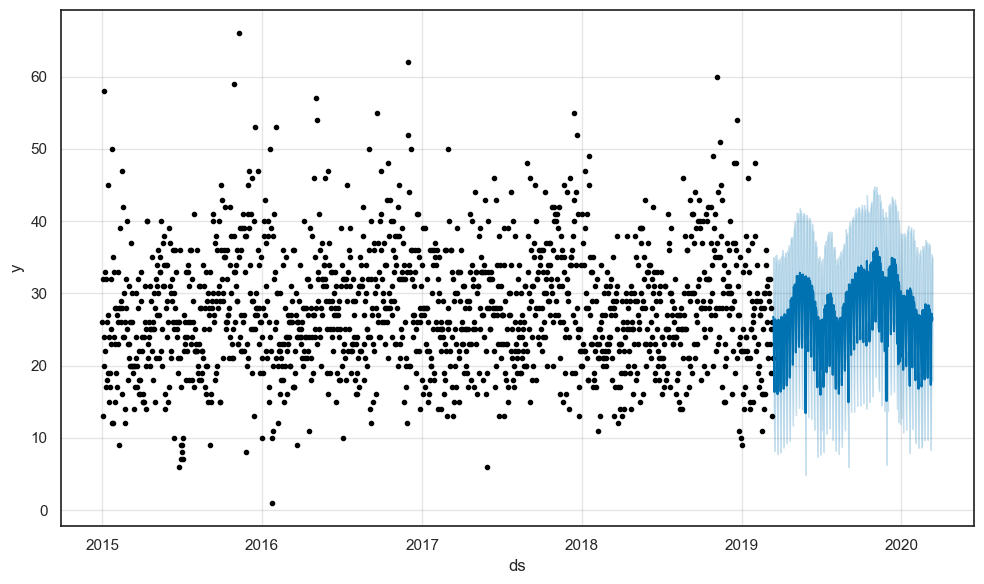

In [317]:
forecast_precvd3 = model_precvd3.predict(test)
model_precvd3.plot(forecast_precvd3);

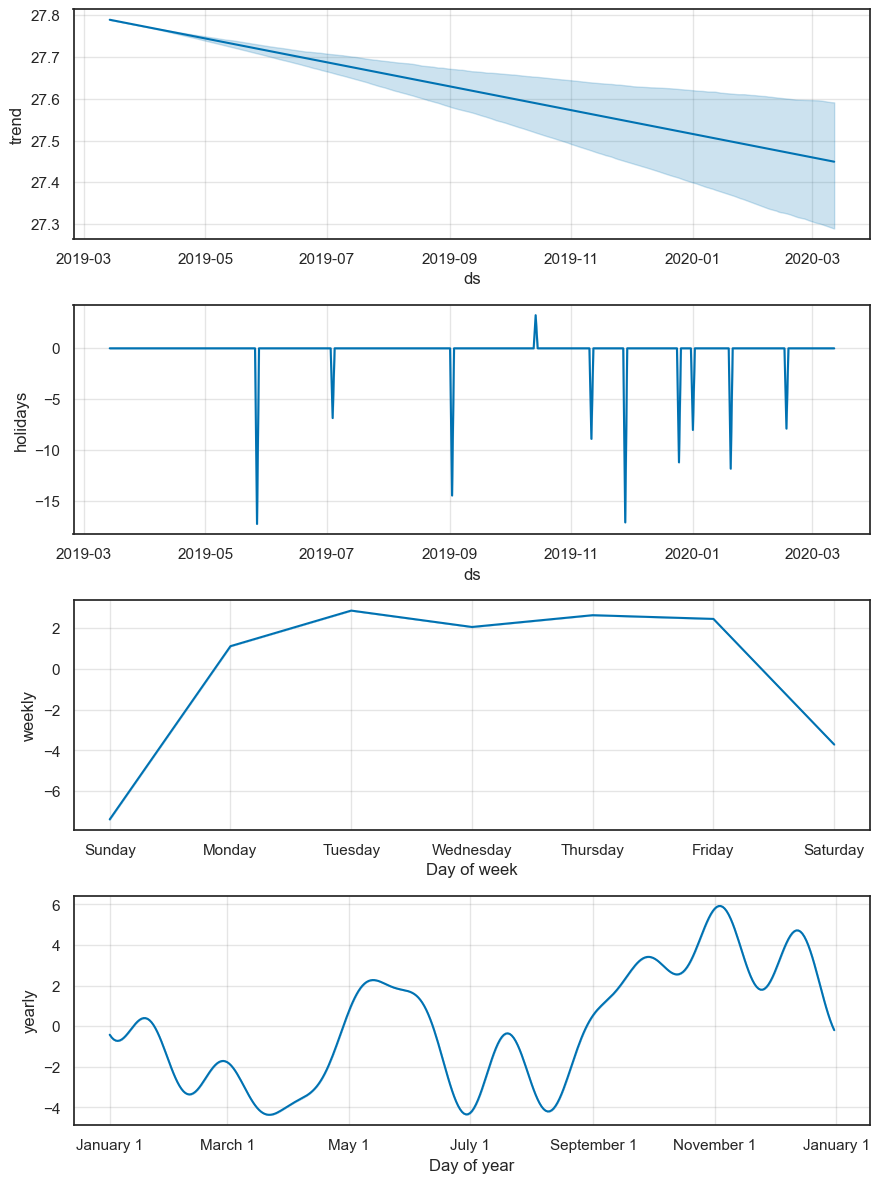

In [318]:
model_precvd3.plot_components(forecast_precvd3);


In [319]:
print(f"The Mean Square Error is: {mean_squared_error(y_true=test['y'],y_pred=forecast_precvd3['yhat'])}")
print(f"The Mean Absolute Error is : {mean_absolute_error(y_true=test['y'],y_pred=forecast_precvd3['yhat'])}")
print(f"The Mean Absolute Percentage Error is: {mean_absolute_percentage_error(y_true=test['y'], y_pred=forecast_precvd3['yhat'])}")

The Mean Square Error is: 40.61398843243521
The Mean Absolute Error is : 4.860694115925268
The Mean Absolute Percentage Error is: 0.19311517458567337


The three models that were tried on forecasting crashes pre-COVID performed well with predictions being off by about 5 crashes. 

Pre-COVID crashes stayed relatively high from from Tuesday to Friday. Crashes also seemed to peak around November 1. 

In [320]:
# During COVID Forecasting

In [321]:
covid_prophet = covid_date.copy().groupby('crashdatetime')[['acrsreporttype']].count()
covid_prophet = covid_prophet.resample('D').apply(sum)
covid_prophet = covid_prophet.reset_index()
covid_prophet.columns = ['ds', 'y']
covid_prophet

ds   y
0   2020-03-13  29
1   2020-03-14  17
2   2020-03-15  14
3   2020-03-16  12
4   2020-03-17  16
..         ...  ..
530 2021-08-25  13
531 2021-08-26  24
532 2021-08-27  28
533 2021-08-28  21
534 2021-08-29  18

[535 rows x 2 columns]

[Text(0.5, 1.0, 'Daily Crashes During COVID'),
 Text(0, 0.5, 'Number of crashes'),
 Text(0.5, 0, 'Date')]

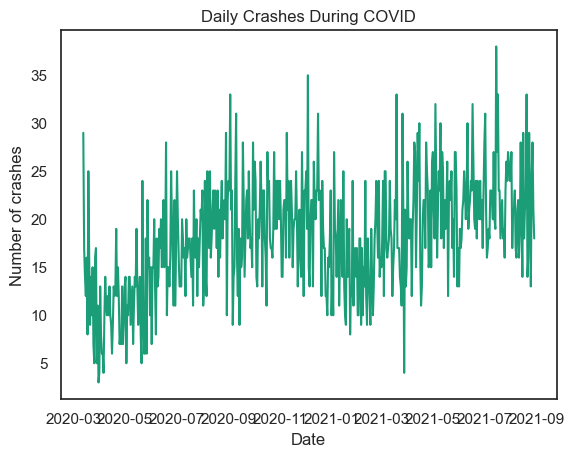

In [322]:
sns.lineplot(x='ds', y='y', data=covid_prophet).set(title="Daily Crashes During COVID",
                                                                       ylabel = 'Number of crashes',
                                                                       xlabel="Date")

In [323]:
split_date2 = '2021-3-13'
train2 = covid_prophet[covid_prophet['ds'] <= split_date2]
test2 = covid_prophet[covid_prophet['ds'] > split_date2]

# Check the shape of the dataset
print(train2.shape)
print(test2.shape)

(366, 2)
(169, 2)


21:26:10 - cmdstanpy - INFO - Chain [1] start processing
21:26:10 - cmdstanpy - INFO - Chain [1] done processing


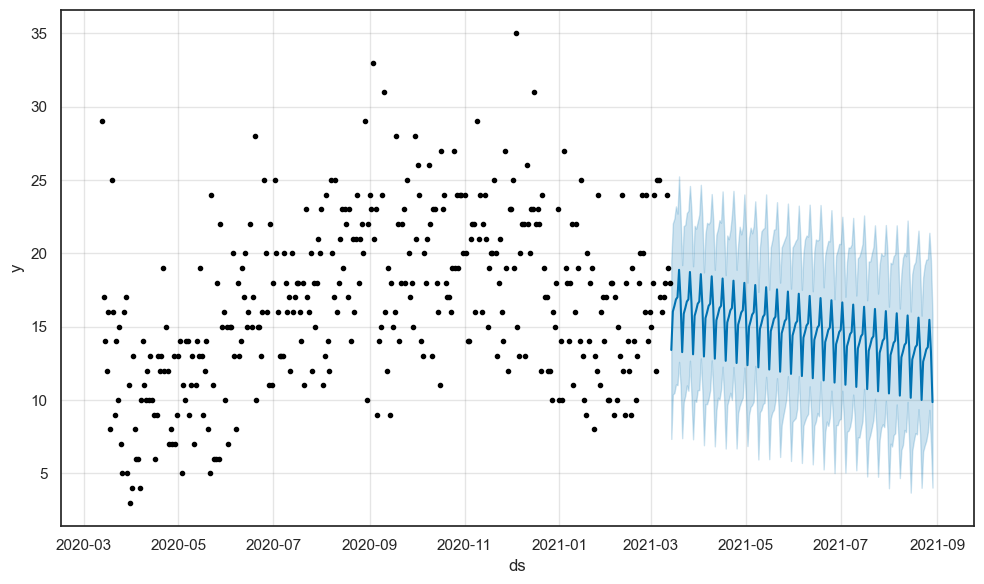

In [324]:
# Seting up and training model and fit
model_cvd = Prophet().fit(train2)
forecast_cvd=model_cvd.predict(test2)
model_cvd.plot(forecast_cvd);

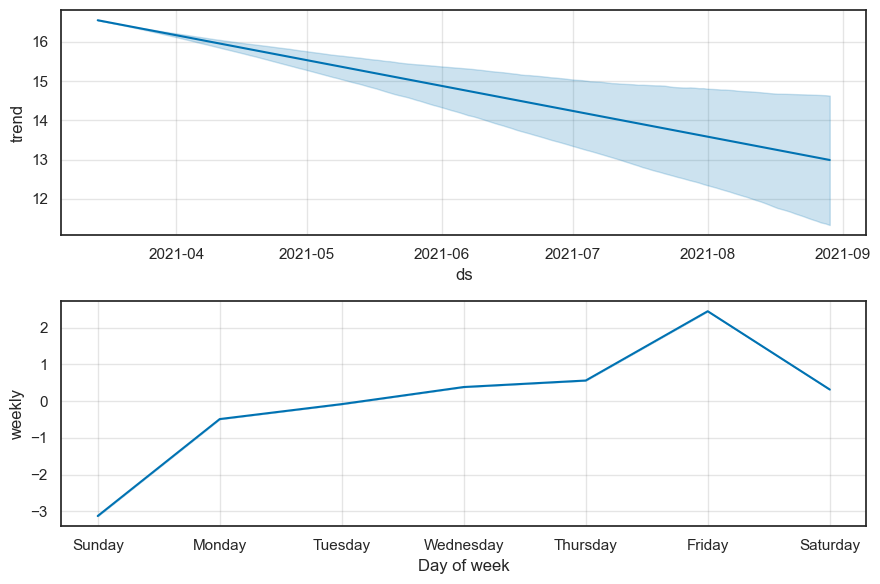

In [325]:
model_cvd.plot_components(forecast_cvd);


Text(0.5, 1.0, 'Forecast vs Actual Values')

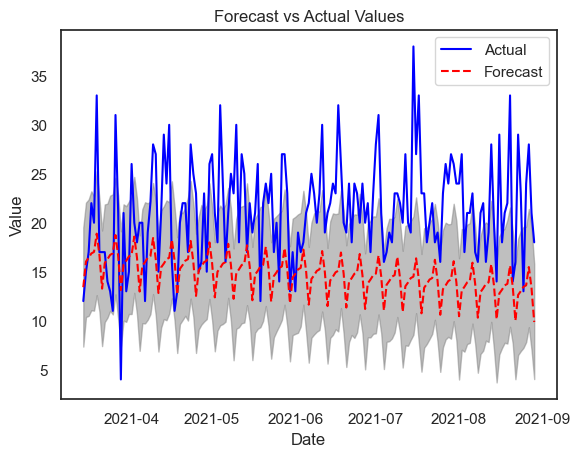

In [326]:
plt.plot(test2['ds'], test2['y'], label='Actual', color='blue')
plt.plot(test2['ds'], forecast_cvd['yhat'], label='Forecast', color='red', linestyle='dashed')
plt.fill_between(test2['ds'], forecast_cvd['yhat_lower'], forecast_cvd['yhat_upper'], color='grey', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs Actual Values')

In [327]:
print(f"The Mean Square Error is: {mean_squared_error(y_true=test2['y'],y_pred=forecast_cvd['yhat'])}")
print(f"The Mean Absolute Error is : {mean_absolute_error(y_true=test2['y'],y_pred=forecast_cvd['yhat'])}")
print(f"The Mean Absolute Percentage Error is: {mean_absolute_percentage_error(y_true=test2['y'], y_pred=forecast_cvd['yhat'])}")

The Mean Square Error is: 68.91301950631156
The Mean Absolute Error is : 7.063020374531062
The Mean Absolute Percentage Error is: 0.31834499103652436


The base model for crashes during COVID is off by about 7 crashes. However crashes now peak on Fridays. 

21:26:12 - cmdstanpy - INFO - Chain [1] start processing
21:26:12 - cmdstanpy - INFO - Chain [1] done processing


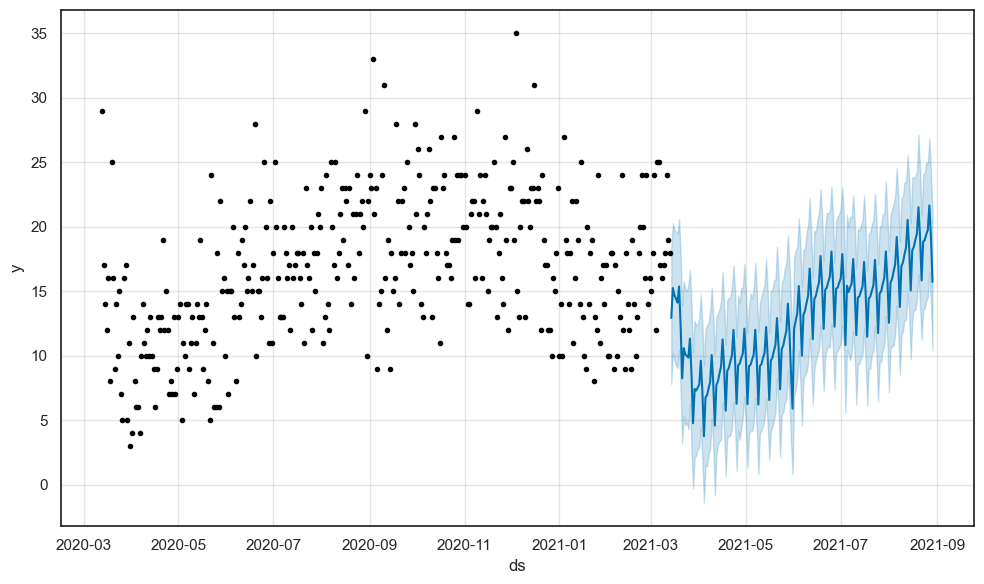

In [328]:
model_cvd2=Prophet(holidays=us_holidays, yearly_seasonality=True).fit(train2)
forecast_cvd2 = model_cvd2.predict(test2)
model_cvd2.plot(forecast_cvd2);

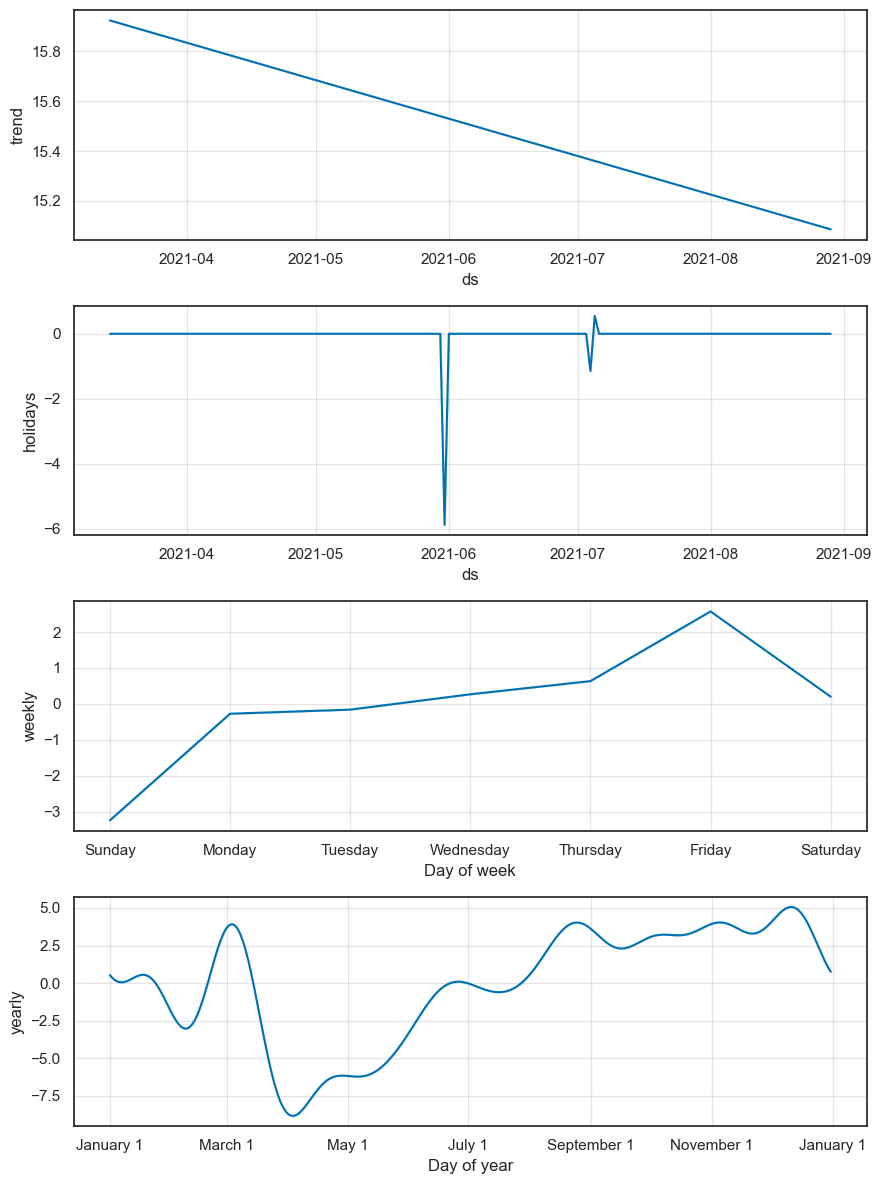

In [329]:
model_cvd2.plot_components(forecast_cvd2);

Text(0.5, 1.0, 'Forecast vs Actual Values')

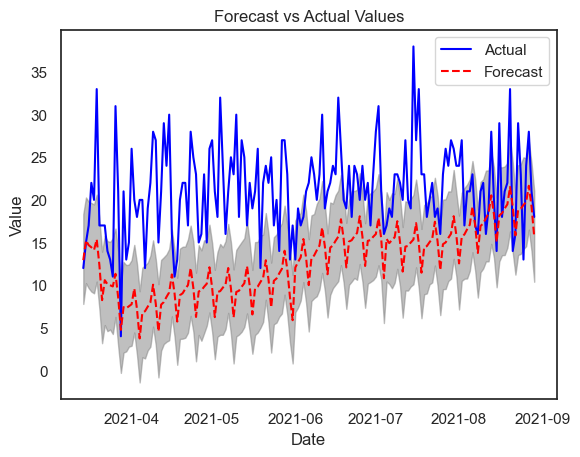

In [330]:
plt.plot(test2['ds'], test2['y'], label='Actual', color='blue')
plt.plot(test2['ds'], forecast_cvd2['yhat'], label='Forecast', color='red', linestyle='dashed')
plt.fill_between(test2['ds'], forecast_cvd2['yhat_lower'], forecast_cvd2['yhat_upper'], color='grey', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs Actual Values')

In [331]:
print(f"The Mean Square Error is: {mean_squared_error(y_true=test2['y'],y_pred=forecast_cvd2['yhat'])}")
print(f"The Mean Absolute Error is : {mean_absolute_error(y_true=test2['y'],y_pred=forecast_cvd2['yhat'])}")
print(f"The Mean Absolute Percentage Error is: {mean_absolute_percentage_error(y_true=test2['y'], y_pred=forecast_cvd2['yhat'])}")

The Mean Square Error is: 102.05163592550655
The Mean Absolute Error is : 8.562662485422592
The Mean Absolute Percentage Error is: 0.3817408681293392


Interestingly, adding seasonality makes the model perform worse. We also see crashes peaking in early March, late August and early December perhaps reflecting some of the chaos surrounding the early days of COVID and then easing of restrictions later in the year. 

In [332]:
# Post-Covid forecasting
post_covid_prophet = post_covid.copy().groupby('crashdatetime')[['acrsreporttype']].count()
post_covid_prophet = post_covid_prophet.resample('D').apply(sum)
post_covid_prophet = post_covid_prophet.reset_index()
post_covid_prophet.columns = ['ds', 'y']
post_covid_prophet

ds   y
0   2021-08-30  23
1   2021-08-31  20
2   2021-09-01  34
3   2021-09-02  38
4   2021-09-03  24
..         ...  ..
849 2023-12-27  27
850 2023-12-28  20
851 2023-12-29  21
852 2023-12-30  19
853 2023-12-31  18

[854 rows x 2 columns]

[Text(0.5, 1.0, 'Daily Crashes Post-COVID'),
 Text(0, 0.5, 'Number of crashes'),
 Text(0.5, 0, 'Date')]

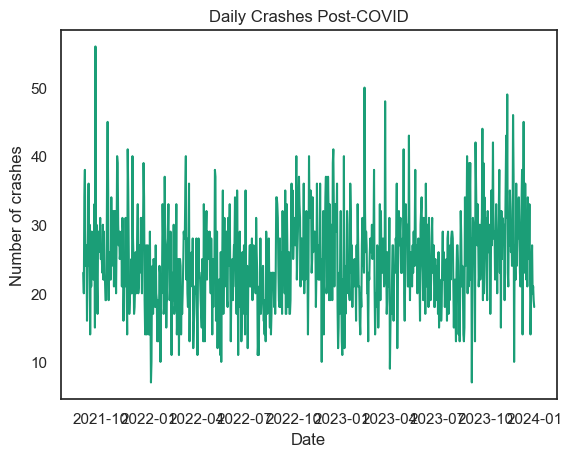

In [333]:
sns.lineplot(x='ds', y='y', data=post_covid_prophet).set(title="Daily Crashes Post-COVID",
                                                                       ylabel = 'Number of crashes',
                                                                       xlabel="Date")

In [334]:
split_date3 = '2023-3-13'
train3 = post_covid_prophet[post_covid_prophet['ds'] <= split_date3]
test3 = post_covid_prophet[post_covid_prophet['ds'] > split_date3]

# Checking the shape of the dataset
print(train3.shape)
print(test3.shape)

(561, 2)
(293, 2)


21:26:15 - cmdstanpy - INFO - Chain [1] start processing
21:26:15 - cmdstanpy - INFO - Chain [1] done processing


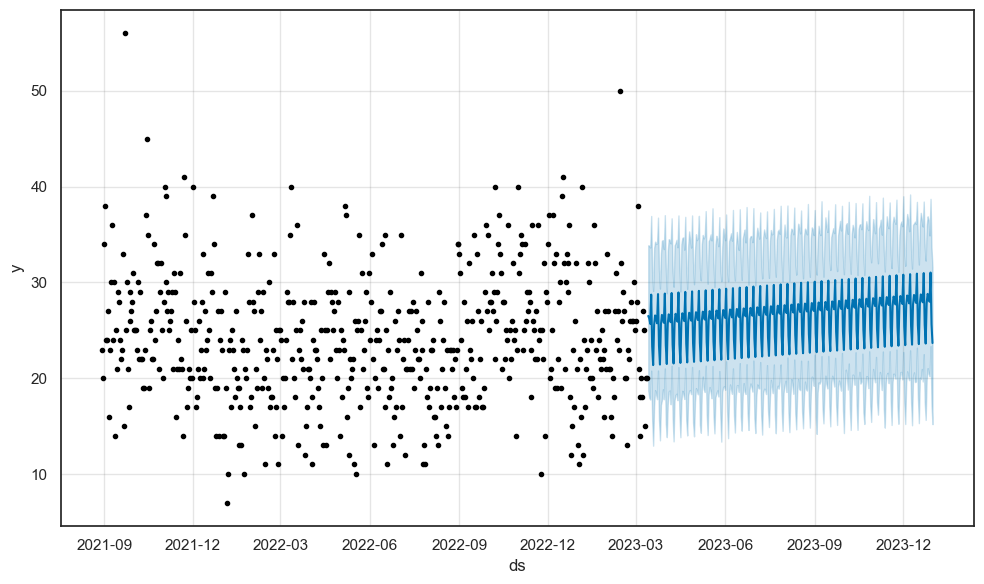

In [335]:
model_postcvd = Prophet().fit(train3)
forecast_postcvd=model_postcvd.predict(test3)
model_postcvd.plot(forecast_postcvd);

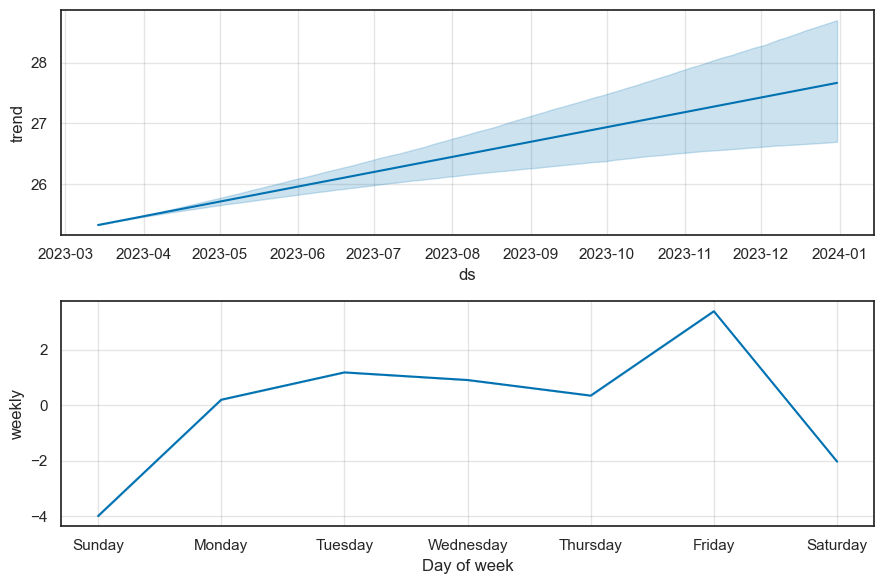

In [336]:
model_postcvd.plot_components(forecast_postcvd);

Text(0.5, 1.0, 'Forecast vs Actual Values')

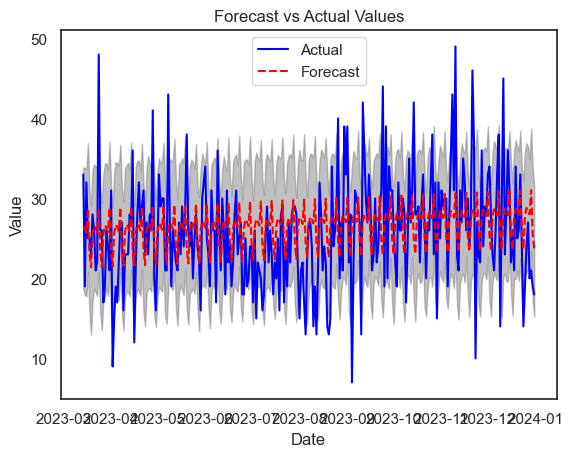

In [337]:
plt.plot(test3['ds'], test3['y'], label='Actual', color='blue')
plt.plot(test3['ds'], forecast_postcvd['yhat'], label='Forecast', color='red', linestyle='dashed')
plt.fill_between(test3['ds'], forecast_postcvd['yhat_lower'], forecast_postcvd['yhat_upper'], color='grey', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs Actual Values')

In [338]:
print(f"The Mean Square Error is: {mean_squared_error(y_true=test3['y'],y_pred=forecast_postcvd['yhat'])}")
print(f"The Mean Absolute Error is : {mean_absolute_error(y_true=test3['y'],y_pred=forecast_postcvd['yhat'])}")
print(f"The Mean Absolute Percentage Error is: {mean_absolute_percentage_error(y_true=test3['y'], y_pred=forecast_postcvd['yhat'])}")

The Mean Square Error is: 42.331473633403284
The Mean Absolute Error is : 4.999293296980663
The Mean Absolute Percentage Error is: 0.22567127658136987


This model is only off by 5 crashes.  

21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] done processing


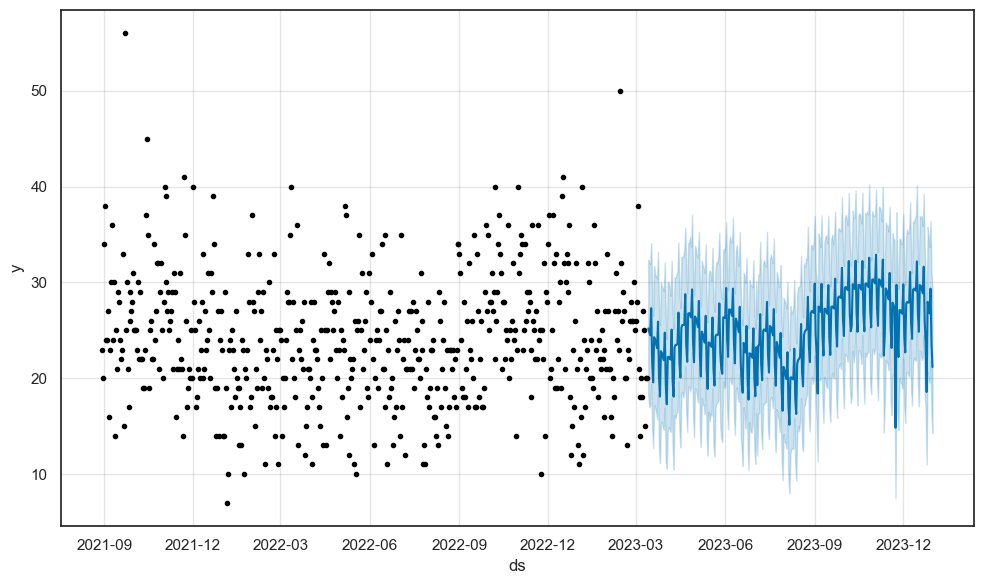

In [339]:
# Adding seasonality to the model
model_postcvd2=Prophet(holidays=us_holidays, yearly_seasonality=True).fit(train3)
forecast_postcvd2 = model_postcvd2.predict(test3)
model_postcvd2.plot(forecast_postcvd2);

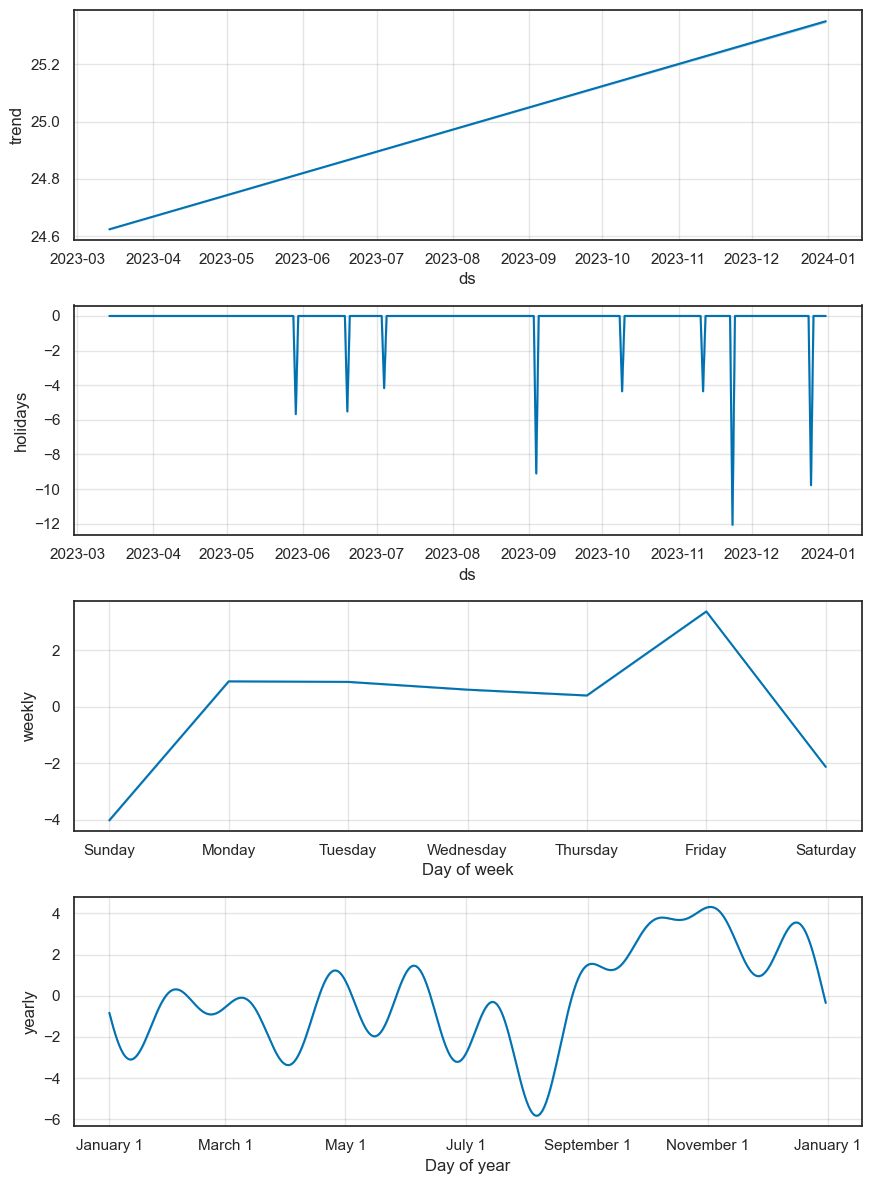

In [340]:
model_postcvd2.plot_components(forecast_postcvd2);

Text(0.5, 1.0, 'Forecast vs Actual Values')

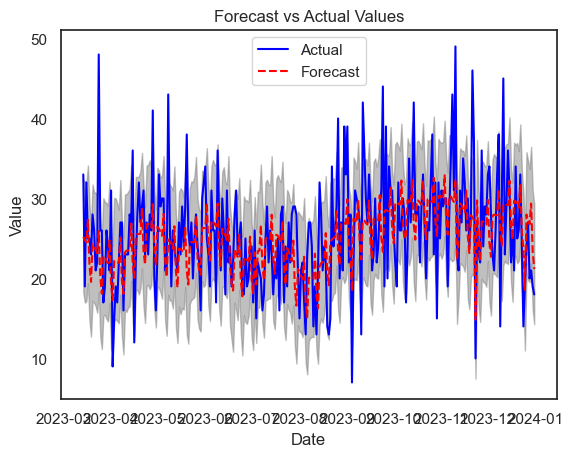

In [341]:
plt.plot(test3['ds'], test3['y'], label='Actual', color='blue')
plt.plot(test3['ds'], forecast_postcvd2['yhat'], label='Forecast', color='red', linestyle='dashed')
plt.fill_between(test3['ds'], forecast_postcvd2['yhat_lower'], forecast_postcvd2['yhat_upper'], color='grey', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs Actual Values')

In [342]:
print(f"The Mean Square Error is: {mean_squared_error(y_true=test3['y'],y_pred=forecast_postcvd2['yhat'])}")
print(f"The Mean Absolute Error is : {mean_absolute_error(y_true=test3['y'],y_pred=forecast_postcvd2['yhat'])}")
print(f"The Mean Absolute Percentage Error is: {mean_absolute_percentage_error(y_true=test3['y'], y_pred=forecast_postcvd2['yhat'])}")



The Mean Square Error is: 35.57737525202981
The Mean Absolute Error is : 4.551742640779654
The Mean Absolute Percentage Error is: 0.18809271982655737


In [343]:
# Predicting using the mdodel with seasonality
future = model_postcvd2.make_future_dataframe(periods=366*2)
forecast = model_postcvd2.predict(future)

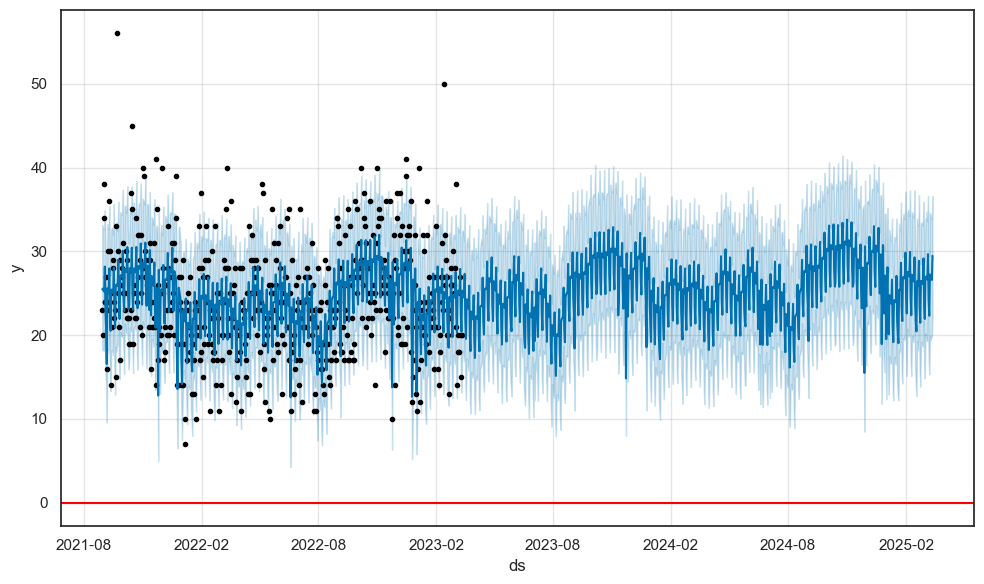

In [344]:
model_postcvd2.plot(forecast)
plt.axhline(y=0, color='red')

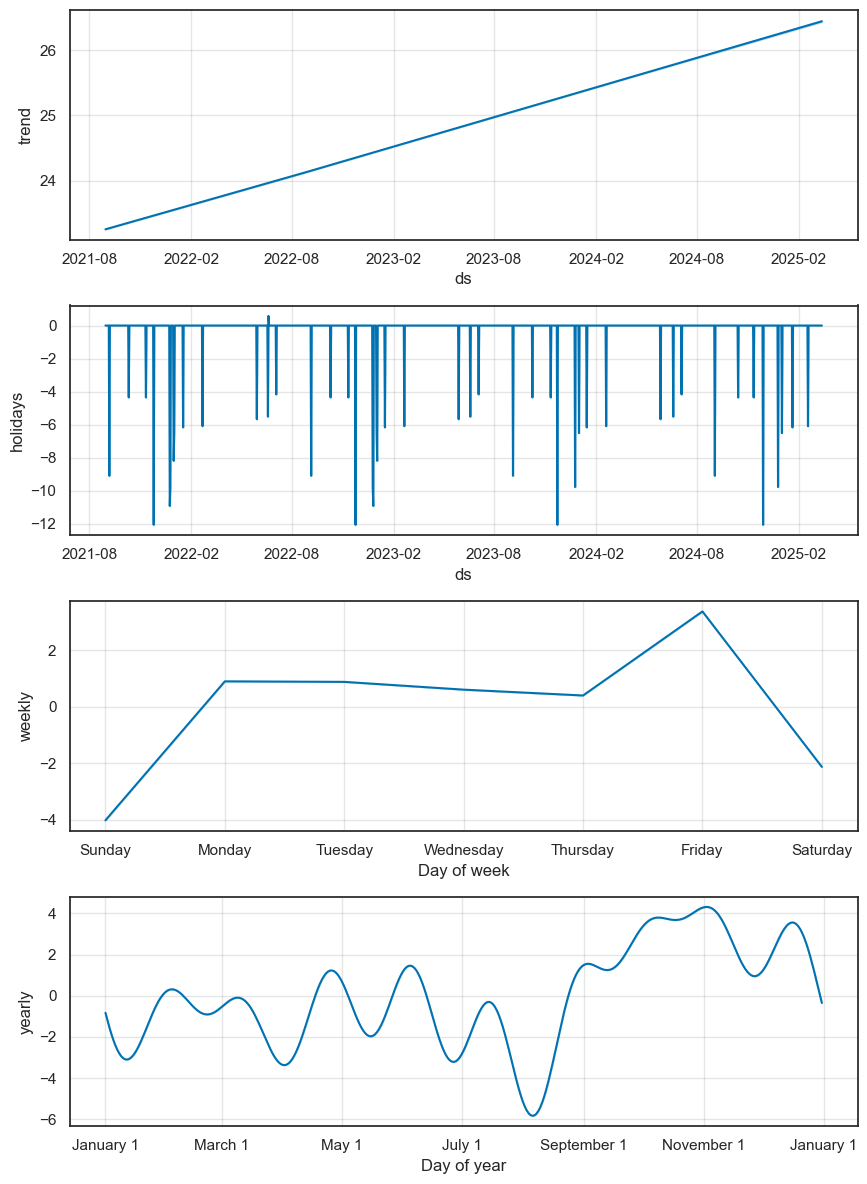

In [345]:
model_postcvd2.plot_components(forecast);


The model suggests that crashes continue to peak on Fridays and around late October/Early November. 

In [346]:
# Selecting EEA to see what changes, if any have occurred pre and post COVID

In [347]:
pre_covid_prophet_eea = crash_sj.copy().query('EEA==1').query('covid_date_flag=="pre_covid"').groupby('crashdatetime')[['acrsreporttype']].count()
pre_covid_prophet_eea = pre_covid_prophet_eea.resample('D').apply(sum)
pre_covid_prophet_eea = pre_covid_prophet_eea.reset_index()
pre_covid_prophet_eea.columns = ['ds', 'y']

In [348]:
pre_covid_prophet_eea

ds   y
0    2015-01-01   9
1    2015-01-02   7
2    2015-01-03  10
3    2015-01-04   6
4    2015-01-05   3
...         ...  ..
1893 2020-03-08   5
1894 2020-03-09  11
1895 2020-03-10   7
1896 2020-03-11   6
1897 2020-03-12   4

[1898 rows x 2 columns]

[Text(0.5, 1.0, 'Daily Crashes in Equity Emphasis Areas Pre-COVID'),
 Text(0, 0.5, 'Number of crashes'),
 Text(0.5, 0, 'Date')]

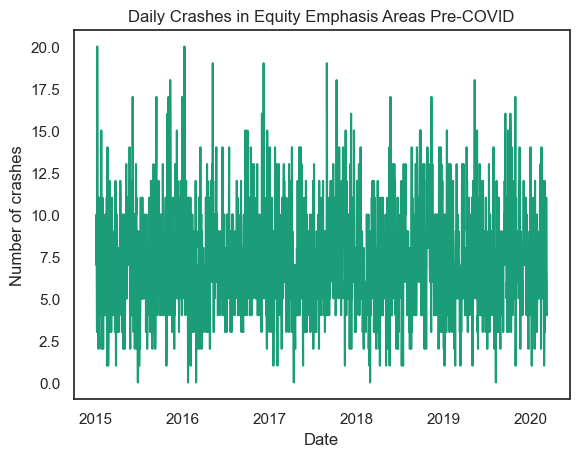

In [349]:
sns.lineplot(x='ds', y='y', data=pre_covid_prophet_eea).set(title="Daily Crashes in Equity Emphasis Areas Pre-COVID",
                                                                       ylabel = 'Number of crashes',
                                                                       xlabel="Date")

In [350]:
train_eea = pre_covid_prophet_eea[pre_covid_prophet_eea['ds'] <= split_date]
test_eea = pre_covid_prophet_eea[pre_covid_prophet_eea['ds'] > split_date]


# Checking the shape of the dataset
print(train_eea.shape)
print(test_eea.shape)

(1533, 2)
(365, 2)


21:26:22 - cmdstanpy - INFO - Chain [1] start processing
21:26:22 - cmdstanpy - INFO - Chain [1] done processing


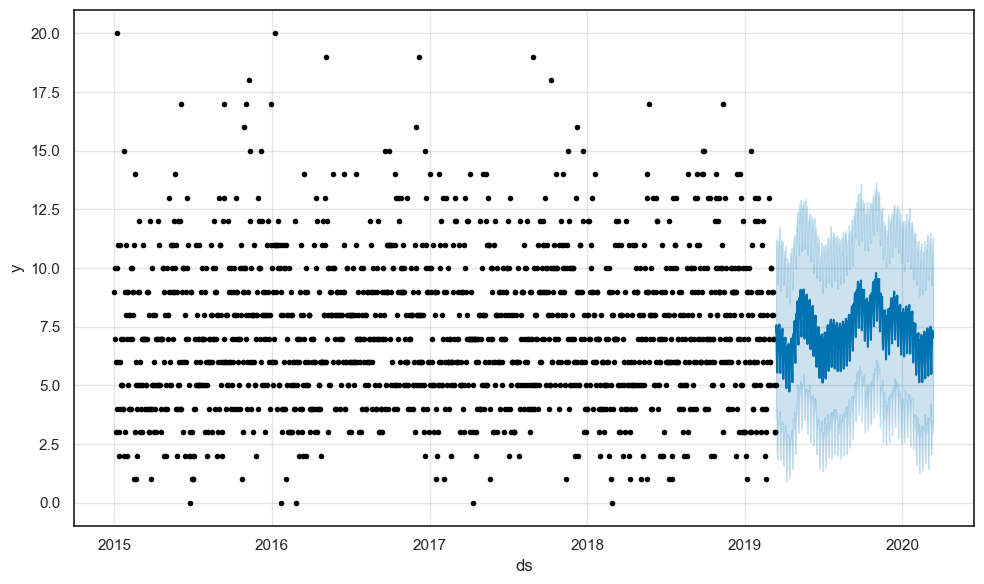

In [351]:
model_eea = Prophet()
forecast_eea=model_eea.fit(train_eea).predict(test_eea)
model_eea.plot(forecast_eea);

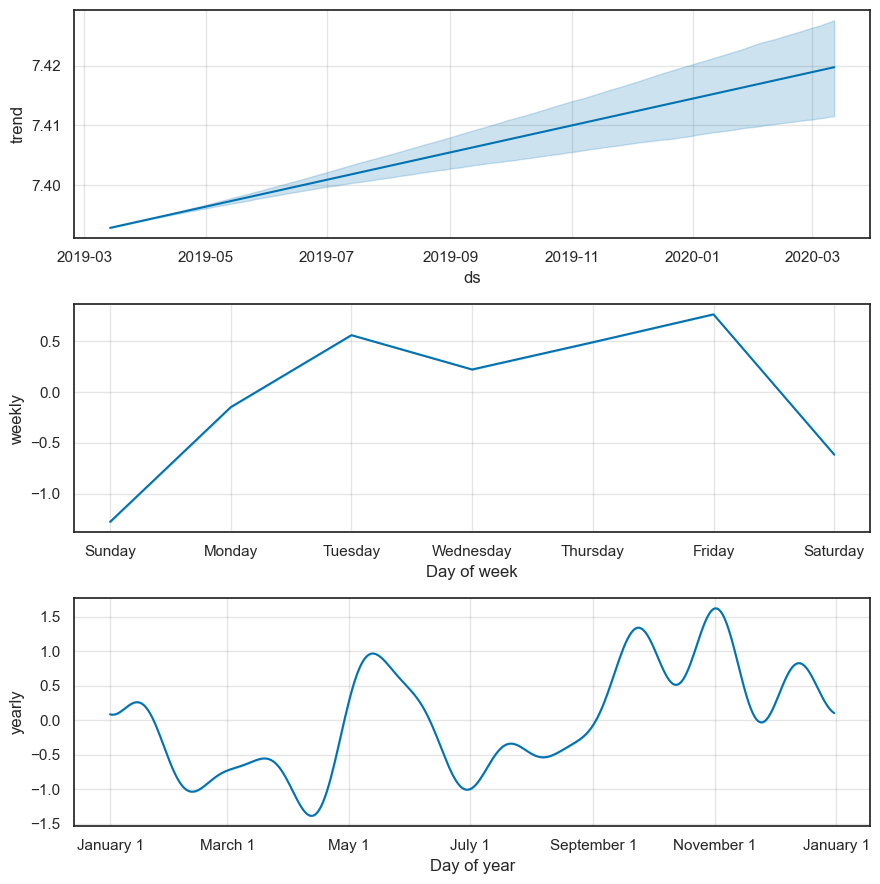

In [352]:
model_eea.plot_components(forecast_eea);

Text(0.5, 1.0, 'Forecast vs Actual Values')

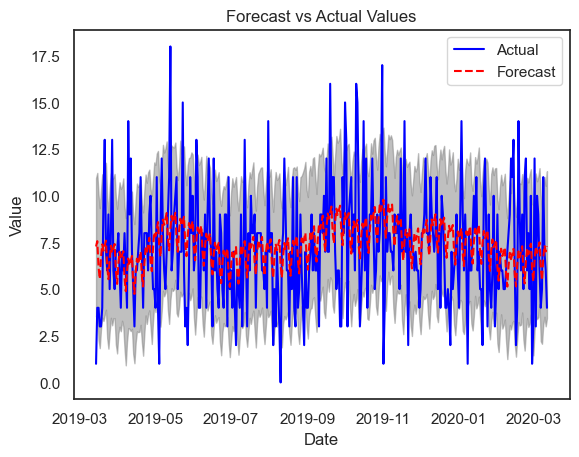

In [353]:
plt.plot(test_eea['ds'], test_eea['y'], label='Actual', color='blue')
plt.plot(test_eea['ds'], forecast_eea['yhat'], label='Forecast', color='red', linestyle='dashed')
plt.fill_between(test_eea['ds'], forecast_eea['yhat_lower'], forecast_eea['yhat_upper'], color='grey', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs Actual Values')

In [354]:
print(f"The Mean Square Error is: {mean_squared_error(y_true=test_eea['y'], y_pred=forecast_eea['yhat'])}")
print(f"The Mean Absolute Error is : {mean_absolute_error(y_true=test_eea['y'], y_pred=forecast_eea['yhat'])}")
print(f"The Mean Absolute Percentage Error is: {mean_absolute_percentage_error(y_true=test_eea['y'], y_pred=forecast_eea['yhat'])}")

The Mean Square Error is: 8.926549278253855
The Mean Absolute Error is : 2.3682941216760733
The Mean Absolute Percentage Error is: 77285536906721.75


This model is off by roughly two crashes although the high mean absolute error suggests a very inaccurate model.

21:26:24 - cmdstanpy - INFO - Chain [1] start processing
21:26:24 - cmdstanpy - INFO - Chain [1] done processing


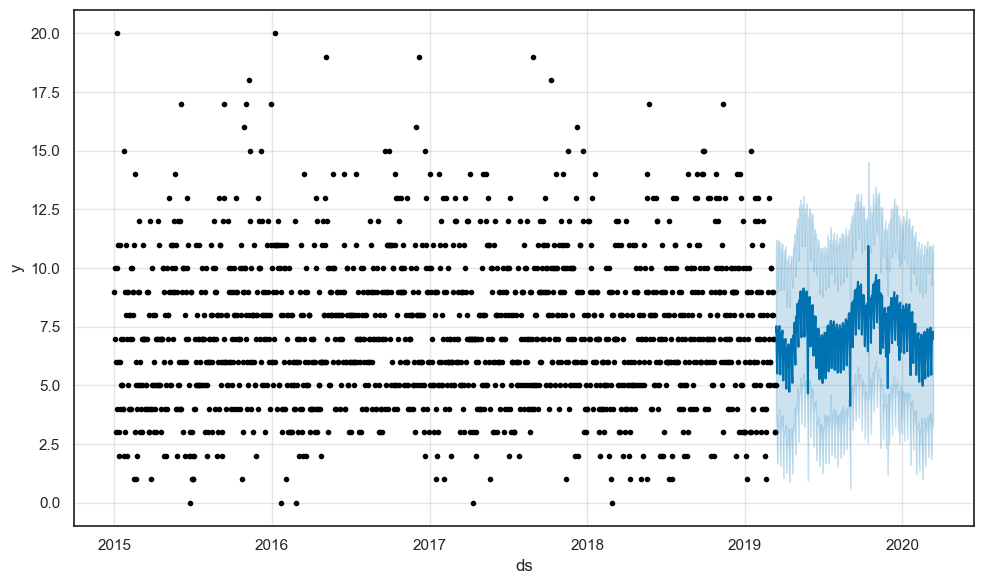

In [355]:
# Training model with holiday and seasonality
model_eea2=Prophet(holidays=us_holidays, yearly_seasonality=True)
forecast_eea2  = model_eea2.fit(train_eea).predict(test_eea)
model_eea2.plot(forecast_eea2);

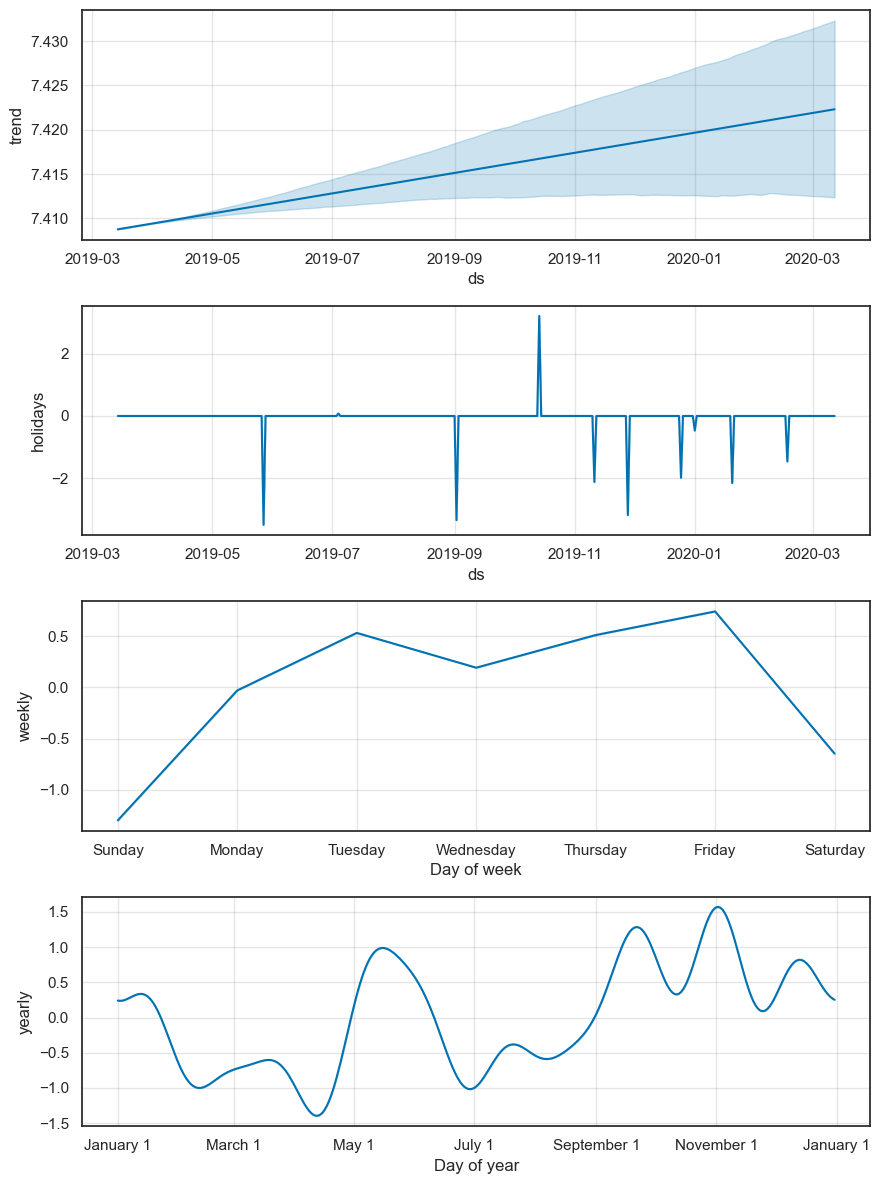

In [356]:
model_eea2.plot_components(forecast_eea2);

Text(0.5, 1.0, 'Forecast vs Actual Values')

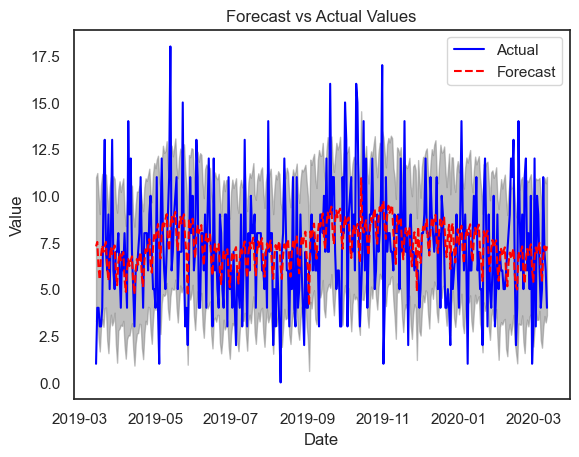

In [357]:
plt.plot(test_eea['ds'], test_eea['y'], label='Actual', color='blue')
plt.plot(test_eea['ds'], forecast_eea2['yhat'], label='Forecast', color='red', linestyle='dashed')
plt.fill_between(test_eea['ds'], forecast_eea2['yhat_lower'], forecast_eea2['yhat_upper'], color='grey', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs Actual Values')

In [358]:
print(f"The Mean Square Error is: {mean_squared_error(y_true=test_eea['y'], y_pred=forecast_eea2['yhat'])}")
print(f"The Mean Absolute Error is : {mean_absolute_error(y_true=test_eea['y'], y_pred=forecast_eea2['yhat'])}")
print(f"The Mean Absolute Percentage Error is: {mean_absolute_percentage_error(y_true=test_eea['y'], y_pred=forecast_eea2['yhat'])}")


The Mean Square Error is: 8.813725271859068
The Mean Absolute Error is : 2.360003579328115
The Mean Absolute Percentage Error is: 76379542039430.03


There isn't much change adding seasonality; however, crashes stay relatively high from Tuesday to Friday with a slight dip on Wednesdays. While crashes also peak in November, one also another peak around mid-May. 

In [359]:
# During COVID Forecasting - EEA

In [360]:
covid_prophet_eea = crash_sj.copy().query('EEA==1').query('covid_date_flag=="covid"').groupby('crashdatetime')[['acrsreporttype']].count()
covid_prophet_eea = covid_prophet_eea.resample('D').apply(sum)
covid_prophet_eea = covid_prophet_eea.reset_index()
covid_prophet_eea.columns = ['ds', 'y']

In [361]:
covid_prophet_eea

ds  y
0   2020-03-13  5
1   2020-03-14  5
2   2020-03-15  8
3   2020-03-16  0
4   2020-03-17  3
..         ... ..
530 2021-08-25  3
531 2021-08-26  2
532 2021-08-27  6
533 2021-08-28  7
534 2021-08-29  3

[535 rows x 2 columns]

[Text(0.5, 1.0, 'Daily Crashes in Equity Emphasis Areas During COVID'),
 Text(0, 0.5, 'Number of crashes'),
 Text(0.5, 0, 'Date')]

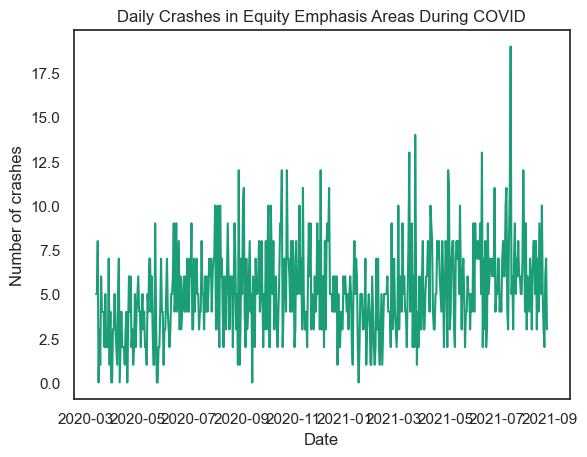

In [362]:
sns.lineplot(x='ds', y='y', data=covid_prophet_eea).set(title="Daily Crashes in Equity Emphasis Areas During COVID",
                                                                       ylabel = 'Number of crashes',
                                                                       xlabel="Date")

In [363]:
train_eea2 = covid_prophet_eea[covid_prophet_eea['ds'] <= split_date2]
test_eea2 = covid_prophet_eea[covid_prophet_eea['ds'] > split_date2]

# Checking the shape of the dataset
print(train_eea2.shape)
print(test_eea2.shape)

(366, 2)
(169, 2)


In [364]:
model_cvd_eea = Prophet()
model_cvd_eea.fit(train_eea2)

21:26:28 - cmdstanpy - INFO - Chain [1] start processing
21:26:28 - cmdstanpy - INFO - Chain [1] done processing


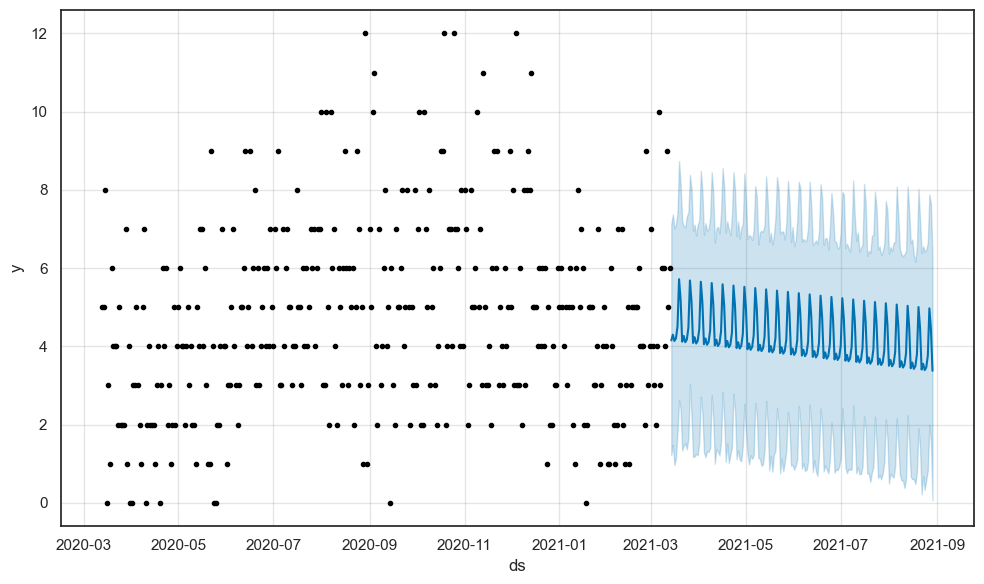

In [365]:
forecast_cvd_eea=model_cvd_eea.predict(test_eea2)

model_cvd_eea.plot(forecast_cvd_eea);

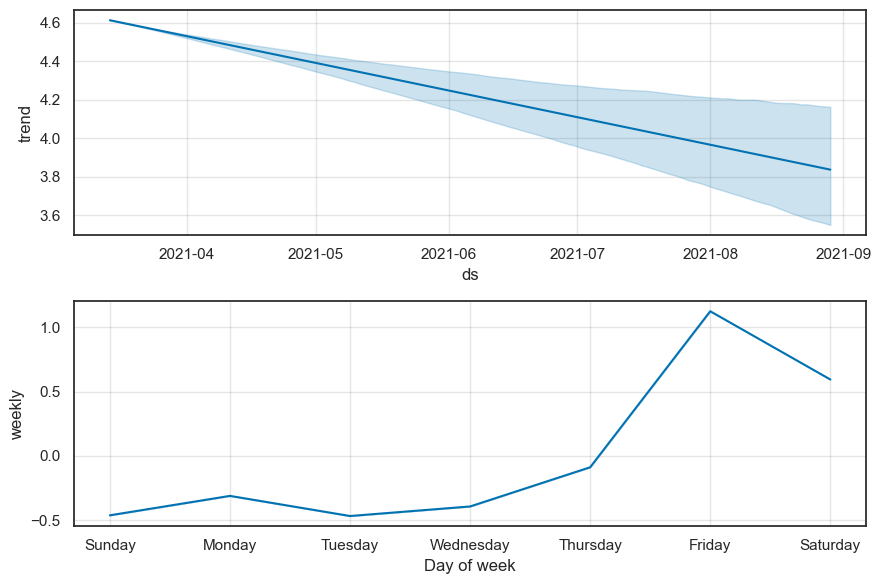

In [366]:
model_cvd_eea.plot_components(forecast_cvd_eea);

Text(0.5, 1.0, 'Forecast vs Actual Values')

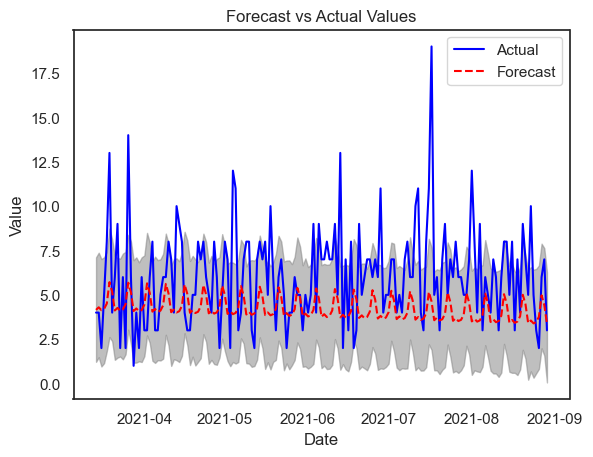

In [367]:
plt.plot(test_eea2['ds'], test_eea2['y'], label='Actual', color='blue')
plt.plot(test_eea2['ds'], forecast_cvd_eea['yhat'], label='Forecast', color='red', linestyle='dashed')
plt.fill_between(test_eea2['ds'], forecast_cvd_eea['yhat_lower'], forecast_cvd_eea['yhat_upper'], color='grey', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs Actual Values')

In [368]:
print(f"The Mean Square Error is: {mean_squared_error(y_true=test_eea2['y'],y_pred=forecast_cvd_eea['yhat'])}")
print(f"The Mean Absolute Error is : {mean_absolute_error(y_true=test_eea2['y'],y_pred=forecast_cvd_eea['yhat'])}")
print(f"The Mean Absolute Percentage Error is: {mean_absolute_percentage_error(y_true=test_eea2['y'], y_pred=forecast_cvd_eea['yhat'])}")

The Mean Square Error is: 10.62652250028931
The Mean Absolute Error is : 2.473241030403825
The Mean Absolute Percentage Error is: 0.4075854917609262


In [369]:
model_cvd_eea2=Prophet(holidays=us_holidays, yearly_seasonality=True)
model_cvd_eea2 = model_cvd_eea2.fit(train_eea2)

21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] done processing


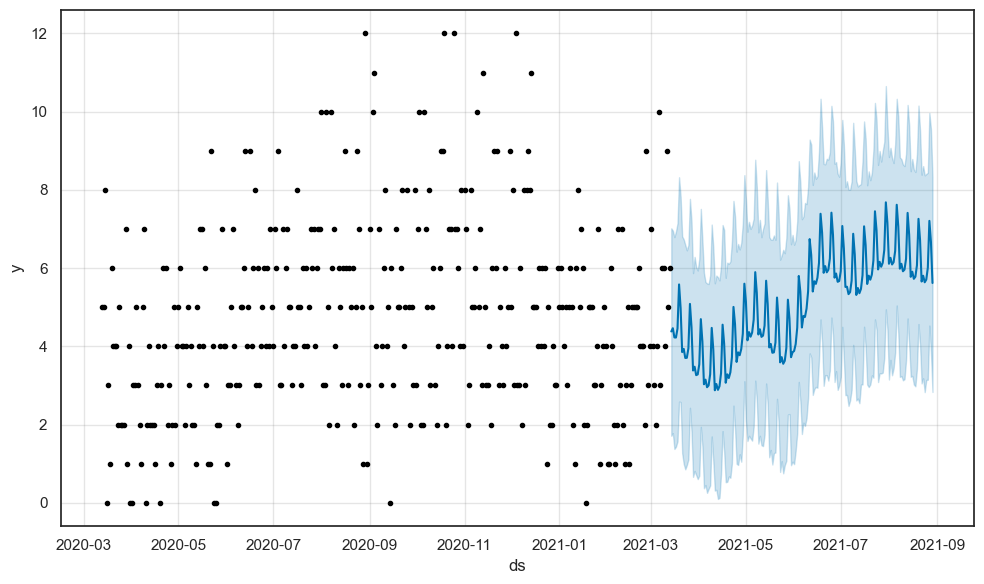

In [370]:
forecast_cvd_eea2 = model_cvd_eea2.predict(test_eea2)
model_cvd_eea2.plot(forecast_cvd_eea2);

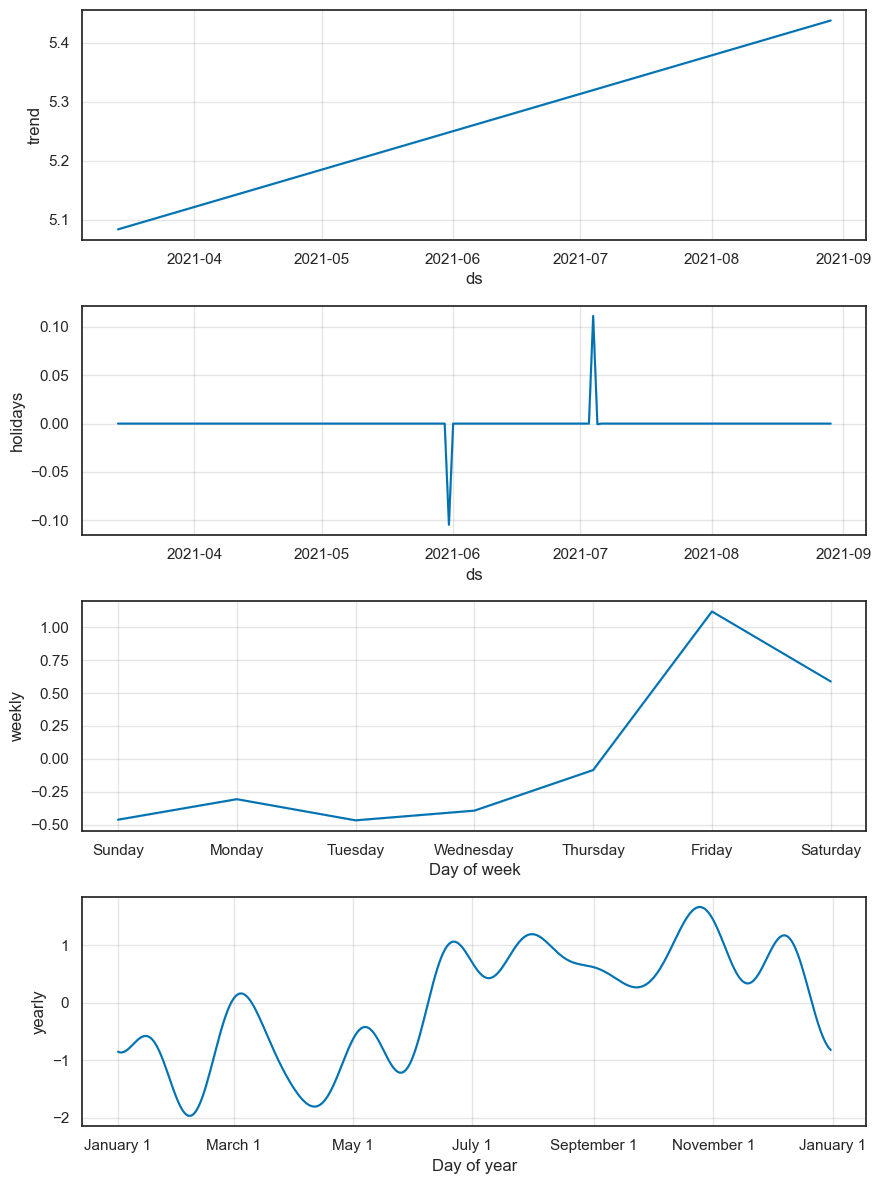

In [371]:
model_cvd_eea2.plot_components(forecast_cvd_eea2);


Text(0.5, 1.0, 'Forecast vs Actual Values')

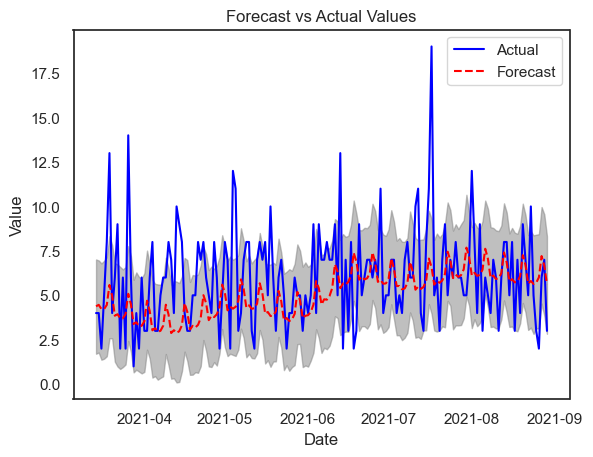

In [372]:
plt.plot(test_eea2['ds'], test_eea2['y'], label='Actual', color='blue')
plt.plot(test_eea2['ds'], forecast_cvd_eea2['yhat'], label='Forecast', color='red', linestyle='dashed')
plt.fill_between(test_eea2['ds'], forecast_cvd_eea2['yhat_lower'], forecast_cvd_eea2['yhat_upper'], color='grey', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs Actual Values')

In [373]:
print(f"The Mean Square Error is: {mean_squared_error(y_true=test_eea2['y'],y_pred=forecast_cvd_eea2['yhat'])}")
print(f"The Mean Absolute Error is : {mean_absolute_error(y_true=test_eea2['y'],y_pred=forecast_cvd_eea2['yhat'])}")
print(f"The Mean Absolute Percentage Error is: {mean_absolute_percentage_error(y_true=test_eea2['y'], y_pred=forecast_cvd_eea2['yhat'])}")

The Mean Square Error is: 8.464269410715442
The Mean Absolute Error is : 2.1888911264180178
The Mean Absolute Percentage Error is: 0.40610514577146306


During COVID, crashes peak on Fridays and in late October.

In [374]:
# Forecasting crashes in EEAs post-COVID
post_covid_prophet_eea = crash_sj.copy().query('EEA==1').query('covid_date_flag=="post_covid"').groupby('crashdatetime')[['acrsreporttype']].count()
post_covid_prophet_eea = post_covid_prophet_eea.resample('D').apply(sum)
post_covid_prophet_eea = post_covid_prophet_eea.reset_index()
post_covid_prophet_eea.columns = ['ds', 'y']

[Text(0.5, 1.0, 'Daily Crashes in Equity Emphasis Areas Post-COVID'),
 Text(0, 0.5, 'Number of crashes'),
 Text(0.5, 0, 'Date')]

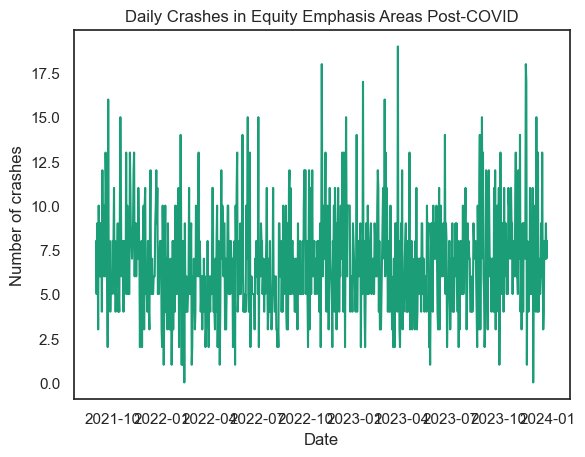

In [375]:
sns.lineplot(x='ds', y='y', data=post_covid_prophet_eea).set(title="Daily Crashes in Equity Emphasis Areas Post-COVID",
                                                                       ylabel = 'Number of crashes',
                                                                       xlabel="Date")

In [376]:
split_date4="2022-12-15"
train_eea3 = post_covid_prophet_eea[post_covid_prophet_eea['ds'] <= split_date4]
test_eea3 = post_covid_prophet_eea[post_covid_prophet_eea['ds'] > split_date4]

# Checking the shape of the dataset
print(train_eea3.shape)
print(test_eea3.shape)

(473, 2)
(381, 2)


In [377]:
post_covid_prophet_eea

ds  y
0   2021-08-30  8
1   2021-08-31  5
2   2021-09-01  9
3   2021-09-02  8
4   2021-09-03  3
..         ... ..
849 2023-12-27  7
850 2023-12-28  7
851 2023-12-29  9
852 2023-12-30  7
853 2023-12-31  8

[854 rows x 2 columns]

21:26:33 - cmdstanpy - INFO - Chain [1] start processing
21:26:33 - cmdstanpy - INFO - Chain [1] done processing


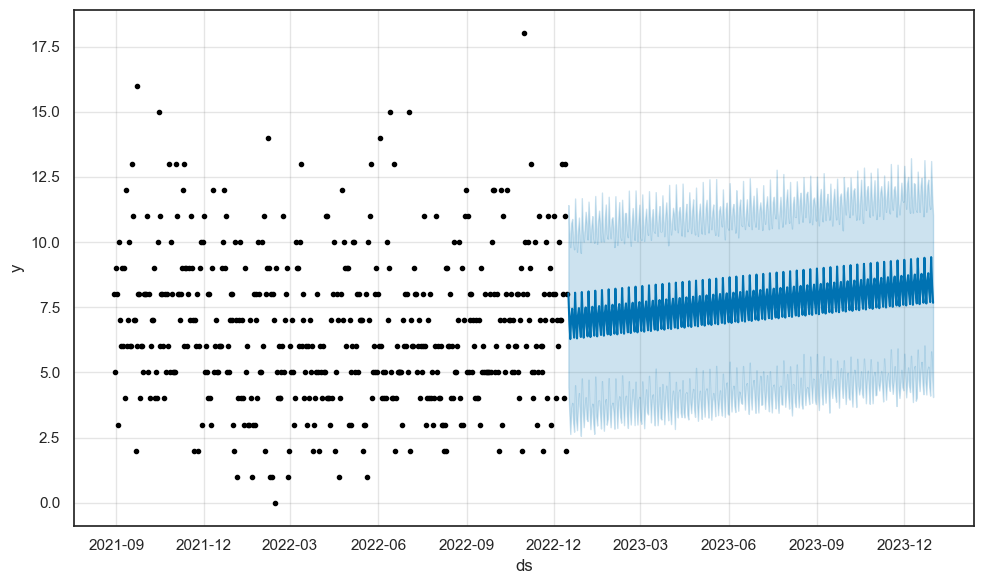

In [378]:
model_postcvd_eea = Prophet().fit(train_eea3)
forecast_postcvd_eea=model_postcvd_eea.predict(test_eea3)
model_postcvd_eea.plot(forecast_postcvd_eea);

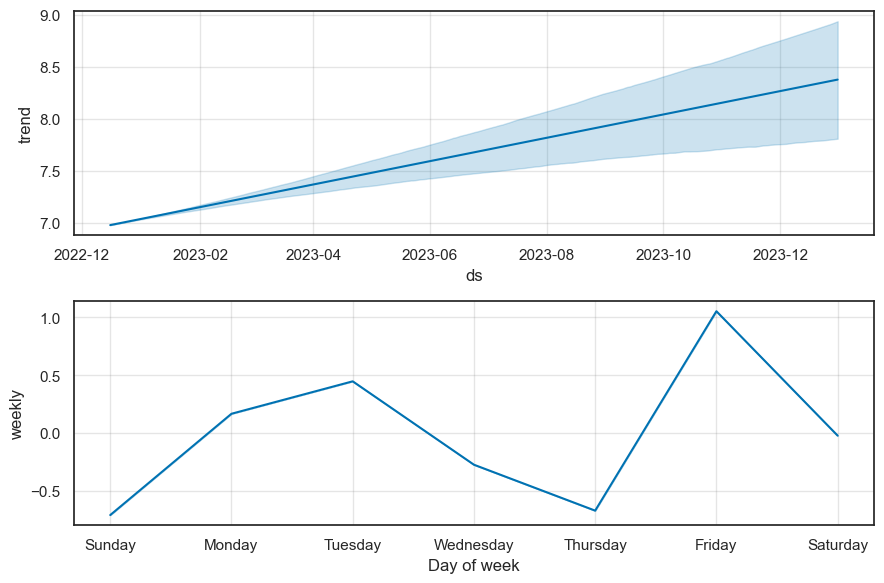

In [379]:
model_postcvd_eea.plot_components(forecast_postcvd_eea);

Text(0.5, 1.0, 'Forecast vs Actual Values')

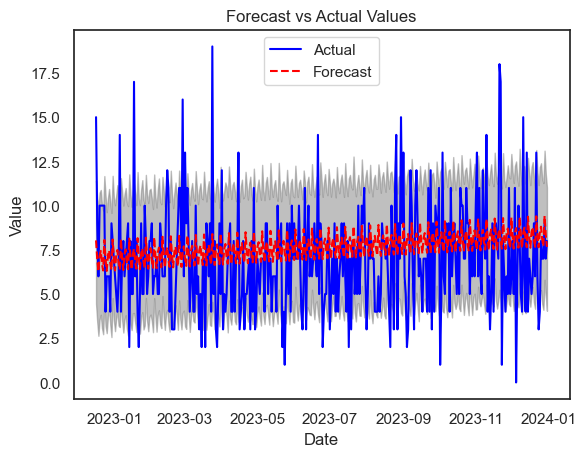

In [380]:
plt.plot(test_eea3['ds'], test_eea3['y'], label='Actual', color='blue')
plt.plot(test_eea3['ds'], forecast_postcvd_eea['yhat'], label='Forecast', color='red', linestyle='dashed')
plt.fill_between(test_eea3['ds'], forecast_postcvd_eea['yhat_lower'], forecast_postcvd_eea['yhat_upper'], color='grey', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs Actual Values')

In [381]:
print(f"The Mean Square Error is: {mean_squared_error(y_true=test_eea3['y'],y_pred=forecast_postcvd_eea['yhat'])}")
print(f"The Mean Absolute Error is : {mean_absolute_error(y_true=test_eea3['y'],y_pred=forecast_postcvd_eea['yhat'])}")
print(f"The Mean Absolute Percentage Error is: {mean_absolute_percentage_error(y_true=test_eea3['y'], y_pred=forecast_postcvd_eea['yhat'])}")

The Mean Square Error is: 9.324177835359992
The Mean Absolute Error is : 2.4458612137036133
The Mean Absolute Percentage Error is: 103180155232793.78


In [382]:
model_postcvd_eea2=Prophet(holidays=us_holidays, yearly_seasonality=True)
model_postcvd_eea2 = model_postcvd_eea2.fit(train_eea3)
forecast_postcvd_eea2=model_postcvd_eea2.predict(test_eea3)

21:26:36 - cmdstanpy - INFO - Chain [1] start processing
21:26:36 - cmdstanpy - INFO - Chain [1] done processing


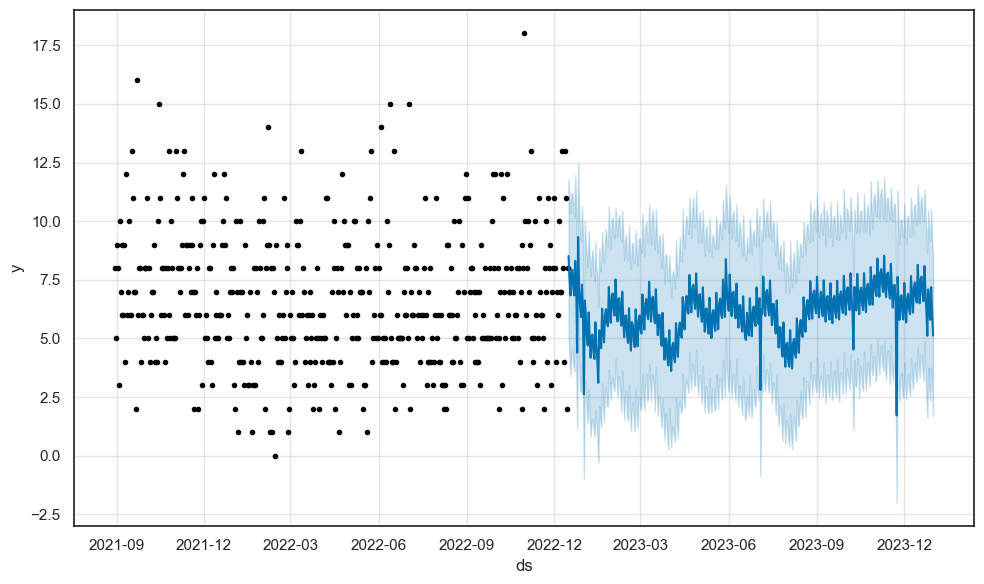

In [383]:
model_postcvd_eea2.plot(forecast_postcvd_eea2);

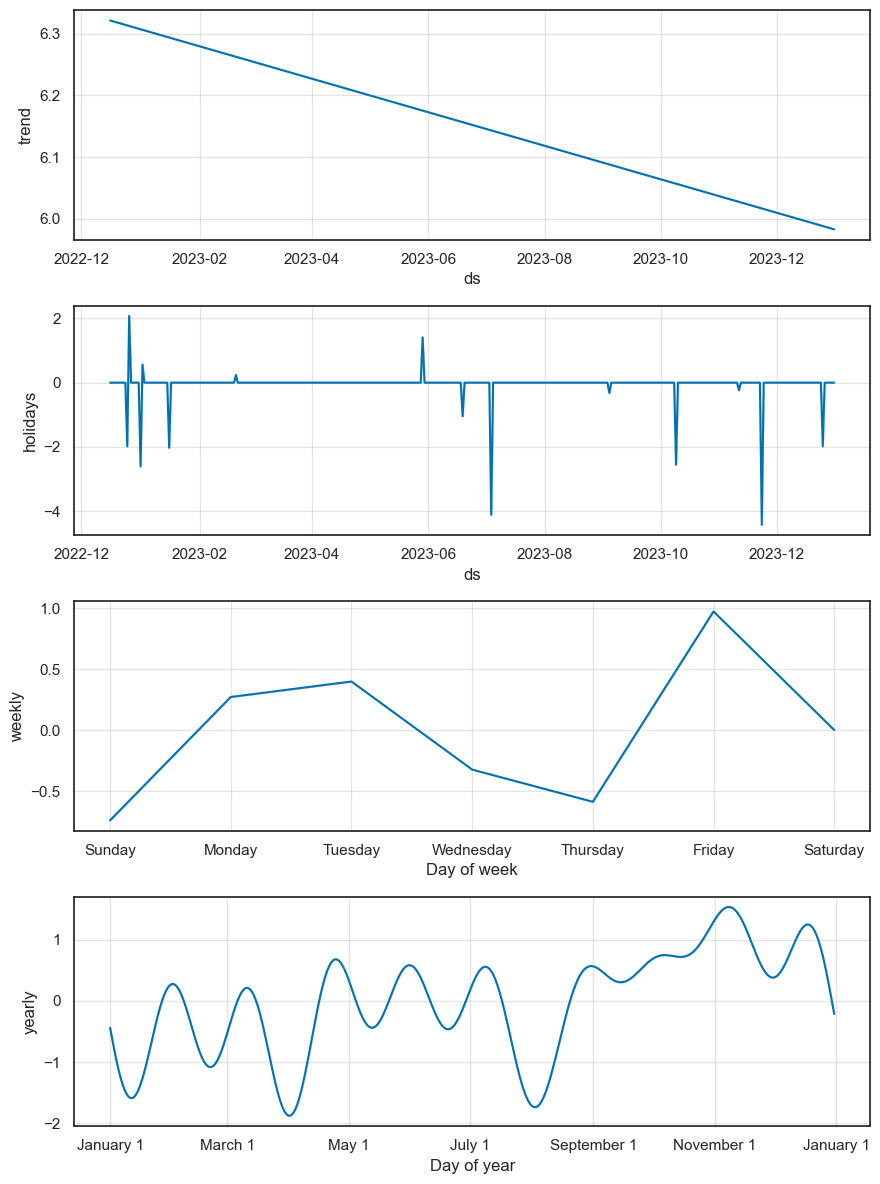

In [384]:
model_postcvd_eea2.plot_components(forecast_postcvd_eea2);

Text(0.5, 1.0, 'Forecast vs Actual Values')

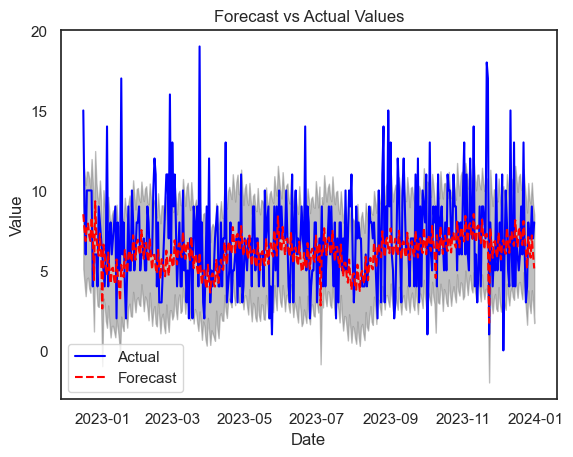

In [385]:
plt.plot(test_eea3['ds'], test_eea3['y'], label='Actual', color='blue')
plt.plot(test_eea3['ds'], forecast_postcvd_eea2['yhat'], label='Forecast', color='red', linestyle='dashed')
plt.fill_between(test_eea3['ds'], forecast_postcvd_eea2['yhat_lower'], forecast_postcvd_eea2['yhat_upper'], color='grey', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs Actual Values')

In [386]:
print(f"The Mean Square Error is: {mean_squared_error(y_true=test_eea3['y'],y_pred=forecast_postcvd_eea2['yhat'])}")
print(f"The Mean Absolute Error is : {mean_absolute_error(y_true=test_eea3['y'],y_pred=forecast_postcvd_eea2['yhat'])}")
print(f"The Mean Absolute Percentage Error is: {mean_absolute_percentage_error(y_true=test_eea3['y'], y_pred=forecast_postcvd_eea2['yhat'])}")

The Mean Square Error is: 9.670414087596205
The Mean Absolute Error is : 2.361642238607748
The Mean Absolute Percentage Error is: 81598023473396.34


In [387]:
future = model_postcvd_eea2.make_future_dataframe(periods=366*2)
forecast = model_postcvd_eea2.predict(future)

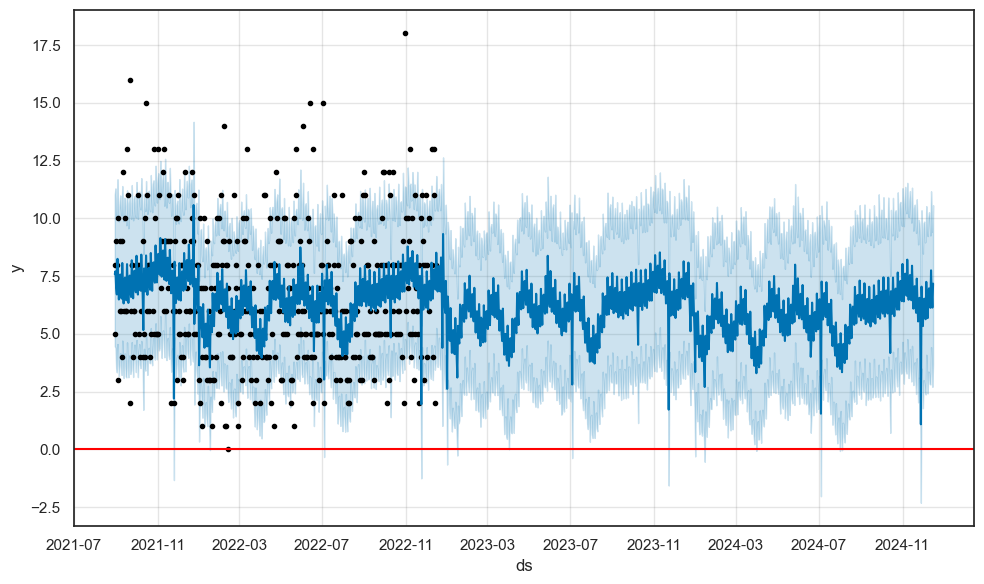

In [388]:
model_postcvd_eea2.plot(forecast)
plt.axhline(y=0, color='red')

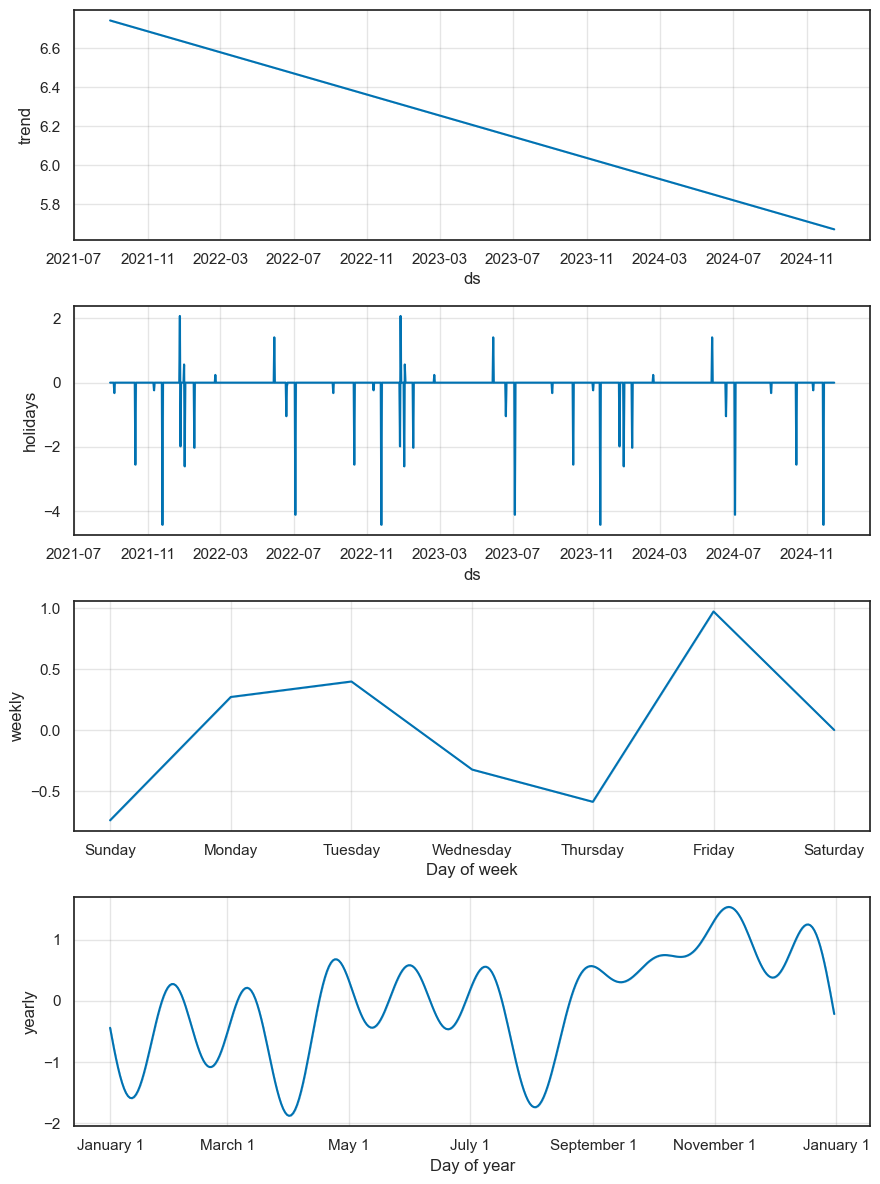

In [389]:
model_postcvd_eea2.plot_components(forecast);

Although the model performs poorly with this data, analyzing crashes in EEAs post-COVID suggests that accidents peak on Fridays. Crashes also peak around mid-November.